## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (1476, 256)
Hypercube shape: (1476, 256, 145)


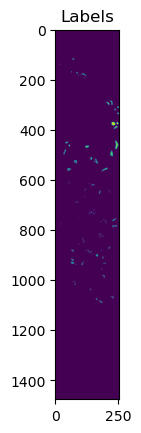

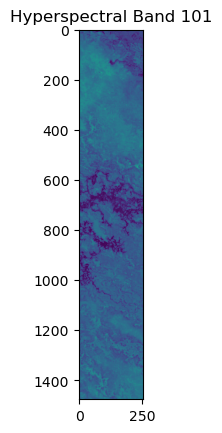

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'Botswana_gt.mat'
data_files = 'Botswana.mat'
label_files = 'Botswana_gt'
hypercube_files = 'Botswana'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels


Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 3248
Extracted windows shape: (3248, 5, 5, 145)
Corresponding labels shape: (3248,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 5)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 270 samples
Shuffled class indices for class '1'
Selected 5 training samples and 5 validation samples for class '1'

Class: 2: Found 101 samples
Shuffled class indices for class '2'
Selected 5 training samples and 5 validation samples for class '2'

Class: 3: Found 251 samples
Shuffled class indices for class '3'
Selected 5 training samples and 5 validation samples for class '3'

Class: 4: Found 215 samples
Shuffled class indices for class '4'
Selected 5 training samples and 5 validation samples for class '4'

Class: 5: Found 269 samples
Shuffled class indices for class '5'
Selected 5 training samples and 5 validation samples for class '5'

Class: 6: Found 269 samples
Shuffled class indices for class '6'
Selected 5 training samples and 5 validation samples for class '6'

Class: 7: Found 259 samples
Shuffled class indices for class '7'
Selecte

In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 1 applied
DataLoaders created successfully!
Training batch size: 70
Class distribution in batch: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5, 9: 5, 10: 5, 11: 5, 12: 5, 13: 5}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (2598, 5, 5, 145)
Validation data shape: (650, 5, 5, 145)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

145


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/41], Loss: 0.2224, PSNR: -9.3597


Epoch [1/50] Training Loss: 0.2135, PSNR: -8.9470
	[Val]   Batch [1/11] Loss: 0.2049, PSNR: -6.1520
	[Val]   Batch [10/11] Loss: 0.2050, PSNR: -8.3907
Epoch [1/50] Validation Loss: 0.2049, PSNR: -8.0828

LOG: Epoch [2/50]
	 Training Batch [1/41], Loss: 0.1994, PSNR: -9.4571


Epoch [2/50] Training Loss: 0.1919, PSNR: -8.3563
	[Val]   Batch [1/11] Loss: 0.1784, PSNR: -5.5513
	[Val]   Batch [10/11] Loss: 0.1784, PSNR: -7.7873
Epoch [2/50] Validation Loss: 0.1783, PSNR: -7.4789

LOG: Epoch [3/50]
	 Training Batch [1/41], Loss: 0.1792, PSNR: -8.4219


Epoch [3/50] Training Loss: 0.1716, PSNR: -7.7351
	[Val]   Batch [1/11] Loss: 0.1573, PSNR: -5.0050
	[Val]   Batch [10/11] Loss: 0.1574, PSNR: -7.2418
Epoch [3/50] Validation Loss: 0.1573, PSNR: -6.9346

LOG: Epoch [4/50]
	 Training Batch [1/41], Loss: 0.1569, PSNR: -4.9927


Epoch [4/50] Training Loss: 0.1518, PSNR: -7.4402
	[Val]   Batch [1/11] Loss: 0.1372, PSNR: -4.4113
	[Val]   Batch [10/11] Loss: 0.1373, PSNR: -6.6493
Epoch [4/50] Validation Loss: 0.1373, PSNR: -6.3443

LOG: Epoch [5/50]
	 Training Batch [1/41], Loss: 0.1388, PSNR: -6.0992


Epoch [5/50] Training Loss: 0.1328, PSNR: -6.8129
	[Val]   Batch [1/11] Loss: 0.1191, PSNR: -3.7963
	[Val]   Batch [10/11] Loss: 0.1191, PSNR: -6.0335
Epoch [5/50] Validation Loss: 0.1191, PSNR: -5.7256

LOG: Epoch [6/50]
	 Training Batch [1/41], Loss: 0.1211, PSNR: -5.4513


Epoch [6/50] Training Loss: 0.1151, PSNR: -6.0423
	[Val]   Batch [1/11] Loss: 0.1017, PSNR: -3.1113
	[Val]   Batch [10/11] Loss: 0.1018, PSNR: -5.3485
Epoch [6/50] Validation Loss: 0.1017, PSNR: -5.0408

LOG: Epoch [7/50]
	 Training Batch [1/41], Loss: 0.1045, PSNR: -4.8107


Epoch [7/50] Training Loss: 0.0991, PSNR: -5.3160
	[Val]   Batch [1/11] Loss: 0.0870, PSNR: -2.4346
	[Val]   Batch [10/11] Loss: 0.0871, PSNR: -4.6718
Epoch [7/50] Validation Loss: 0.0870, PSNR: -4.3636

LOG: Epoch [8/50]
	 Training Batch [1/41], Loss: 0.0892, PSNR: -5.3946


Epoch [8/50] Training Loss: 0.0851, PSNR: -4.8020
	[Val]   Batch [1/11] Loss: 0.0752, PSNR: -1.7979
	[Val]   Batch [10/11] Loss: 0.0752, PSNR: -4.0365
Epoch [8/50] Validation Loss: 0.0751, PSNR: -3.7263

LOG: Epoch [9/50]
	 Training Batch [1/41], Loss: 0.0768, PSNR: -1.8916


Epoch [9/50] Training Loss: 0.0732, PSNR: -4.1851
	[Val]   Batch [1/11] Loss: 0.0654, PSNR: -1.1958
	[Val]   Batch [10/11] Loss: 0.0655, PSNR: -3.4347
Epoch [9/50] Validation Loss: 0.0654, PSNR: -3.1245

LOG: Epoch [10/50]
	 Training Batch [1/41], Loss: 0.0662, PSNR: -4.1860


Epoch [10/50] Training Loss: 0.0632, PSNR: -3.4570
	[Val]   Batch [1/11] Loss: 0.0568, PSNR: -0.5786
	[Val]   Batch [10/11] Loss: 0.0568, PSNR: -2.8180
Epoch [10/50] Validation Loss: 0.0567, PSNR: -2.5072

LOG: Epoch [11/50]
	 Training Batch [1/41], Loss: 0.0579, PSNR: -0.6663


Epoch [11/50] Training Loss: 0.0549, PSNR: -2.8405
	[Val]   Batch [1/11] Loss: 0.0507, PSNR: -0.0852
	[Val]   Batch [10/11] Loss: 0.0507, PSNR: -2.3242
Epoch [11/50] Validation Loss: 0.0507, PSNR: -2.0142

LOG: Epoch [12/50]
	 Training Batch [1/41], Loss: 0.0497, PSNR: -3.0115


Epoch [12/50] Training Loss: 0.0479, PSNR: -2.4594
	[Val]   Batch [1/11] Loss: 0.0441, PSNR: 0.5164
	[Val]   Batch [10/11] Loss: 0.0442, PSNR: -1.7236
Epoch [12/50] Validation Loss: 0.0441, PSNR: -1.4125

LOG: Epoch [13/50]
	 Training Batch [1/41], Loss: 0.0440, PSNR: 0.5281


Epoch [13/50] Training Loss: 0.0422, PSNR: -1.5858
	[Val]   Batch [1/11] Loss: 0.0399, PSNR: 0.9575
	[Val]   Batch [10/11] Loss: 0.0399, PSNR: -1.2834
Epoch [13/50] Validation Loss: 0.0398, PSNR: -0.9717

LOG: Epoch [14/50]
	 Training Batch [1/41], Loss: 0.0386, PSNR: -0.8413


Epoch [14/50] Training Loss: 0.0374, PSNR: -1.3468
	[Val]   Batch [1/11] Loss: 0.0351, PSNR: 1.5144
	[Val]   Batch [10/11] Loss: 0.0351, PSNR: -0.7260
Epoch [14/50] Validation Loss: 0.0350, PSNR: -0.4141

LOG: Epoch [15/50]
	 Training Batch [1/41], Loss: 0.0338, PSNR: 1.6713


Epoch [15/50] Training Loss: 0.0335, PSNR: -0.6449
	[Val]   Batch [1/11] Loss: 0.0320, PSNR: 1.9062
	[Val]   Batch [10/11] Loss: 0.0321, PSNR: -0.3339
Epoch [15/50] Validation Loss: 0.0320, PSNR: -0.0214

LOG: Epoch [16/50]
	 Training Batch [1/41], Loss: 0.0307, PSNR: 2.0969


Epoch [16/50] Training Loss: 0.0301, PSNR: -0.4173
	[Val]   Batch [1/11] Loss: 0.0289, PSNR: 2.3535
	[Val]   Batch [10/11] Loss: 0.0289, PSNR: 0.1152
Epoch [16/50] Validation Loss: 0.0289, PSNR: 0.4262

LOG: Epoch [17/50]
	 Training Batch [1/41], Loss: 0.0280, PSNR: -0.9332


Epoch [17/50] Training Loss: 0.0272, PSNR: 0.3229
	[Val]   Batch [1/11] Loss: 0.0262, PSNR: 2.7872
	[Val]   Batch [10/11] Loss: 0.0262, PSNR: 0.5496
Epoch [17/50] Validation Loss: 0.0261, PSNR: 0.8599

LOG: Epoch [18/50]
	 Training Batch [1/41], Loss: 0.0256, PSNR: 2.8862


Epoch [18/50] Training Loss: 0.0247, PSNR: 0.4608
	[Val]   Batch [1/11] Loss: 0.0238, PSNR: 3.2014
	[Val]   Batch [10/11] Loss: 0.0238, PSNR: 0.9639
Epoch [18/50] Validation Loss: 0.0238, PSNR: 1.2737

LOG: Epoch [19/50]
	 Training Batch [1/41], Loss: 0.0229, PSNR: -0.0508


Epoch [19/50] Training Loss: 0.0226, PSNR: 1.0007
	[Val]   Batch [1/11] Loss: 0.0219, PSNR: 3.5560
	[Val]   Batch [10/11] Loss: 0.0219, PSNR: 1.3187
Epoch [19/50] Validation Loss: 0.0219, PSNR: 1.6276

LOG: Epoch [20/50]
	 Training Batch [1/41], Loss: 0.0216, PSNR: -0.6439


Epoch [20/50] Training Loss: 0.0207, PSNR: 1.2639
	[Val]   Batch [1/11] Loss: 0.0202, PSNR: 3.9144
	[Val]   Batch [10/11] Loss: 0.0202, PSNR: 1.6776
Epoch [20/50] Validation Loss: 0.0202, PSNR: 1.9868

LOG: Epoch [21/50]
	 Training Batch [1/41], Loss: 0.0195, PSNR: 4.0549


Epoch [21/50] Training Loss: 0.0191, PSNR: 1.5411
	[Val]   Batch [1/11] Loss: 0.0185, PSNR: 4.2865
	[Val]   Batch [10/11] Loss: 0.0185, PSNR: 2.0478
Epoch [21/50] Validation Loss: 0.0185, PSNR: 2.3605

LOG: Epoch [22/50]
	 Training Batch [1/41], Loss: 0.0181, PSNR: 0.1240


Epoch [22/50] Training Loss: 0.0176, PSNR: 1.9517
	[Val]   Batch [1/11] Loss: 0.0173, PSNR: 4.5775
	[Val]   Batch [10/11] Loss: 0.0173, PSNR: 2.3383
Epoch [22/50] Validation Loss: 0.0173, PSNR: 2.6518

LOG: Epoch [23/50]
	 Training Batch [1/41], Loss: 0.0163, PSNR: 3.5297


Epoch [23/50] Training Loss: 0.0163, PSNR: 2.2541
	[Val]   Batch [1/11] Loss: 0.0160, PSNR: 4.9227
	[Val]   Batch [10/11] Loss: 0.0160, PSNR: 2.6853
Epoch [23/50] Validation Loss: 0.0160, PSNR: 2.9972

LOG: Epoch [24/50]
	 Training Batch [1/41], Loss: 0.0154, PSNR: 3.4967


Epoch [24/50] Training Loss: 0.0152, PSNR: 2.6991
	[Val]   Batch [1/11] Loss: 0.0149, PSNR: 5.2438
	[Val]   Batch [10/11] Loss: 0.0149, PSNR: 3.0073
Epoch [24/50] Validation Loss: 0.0148, PSNR: 3.3184

LOG: Epoch [25/50]
	 Training Batch [1/41], Loss: 0.0145, PSNR: 3.7656


Epoch [25/50] Training Loss: 0.0141, PSNR: 3.0824
	[Val]   Batch [1/11] Loss: 0.0139, PSNR: 5.5442
	[Val]   Batch [10/11] Loss: 0.0139, PSNR: 3.3084
Epoch [25/50] Validation Loss: 0.0138, PSNR: 3.6189

LOG: Epoch [26/50]
	 Training Batch [1/41], Loss: 0.0133, PSNR: 2.8646


Epoch [26/50] Training Loss: 0.0132, PSNR: 3.3174
	[Val]   Batch [1/11] Loss: 0.0130, PSNR: 5.8253
	[Val]   Batch [10/11] Loss: 0.0130, PSNR: 3.5898
Epoch [26/50] Validation Loss: 0.0130, PSNR: 3.9007

LOG: Epoch [27/50]
	 Training Batch [1/41], Loss: 0.0124, PSNR: 3.1826


Epoch [27/50] Training Loss: 0.0123, PSNR: 3.4323
	[Val]   Batch [1/11] Loss: 0.0122, PSNR: 6.0987
	[Val]   Batch [10/11] Loss: 0.0122, PSNR: 3.8638
Epoch [27/50] Validation Loss: 0.0122, PSNR: 4.1748

LOG: Epoch [28/50]
	 Training Batch [1/41], Loss: 0.0121, PSNR: 1.8213


Epoch [28/50] Training Loss: 0.0115, PSNR: 3.8685
	[Val]   Batch [1/11] Loss: 0.0114, PSNR: 6.3858
	[Val]   Batch [10/11] Loss: 0.0114, PSNR: 4.1502
Epoch [28/50] Validation Loss: 0.0114, PSNR: 4.4622

LOG: Epoch [29/50]
	 Training Batch [1/41], Loss: 0.0111, PSNR: 4.9068


Epoch [29/50] Training Loss: 0.0109, PSNR: 4.2270
	[Val]   Batch [1/11] Loss: 0.0108, PSNR: 6.6258
	[Val]   Batch [10/11] Loss: 0.0108, PSNR: 4.3892
Epoch [29/50] Validation Loss: 0.0108, PSNR: 4.7026

LOG: Epoch [30/50]
	 Training Batch [1/41], Loss: 0.0102, PSNR: 3.0991


Epoch [30/50] Training Loss: 0.0102, PSNR: 4.2841
	[Val]   Batch [1/11] Loss: 0.0102, PSNR: 6.8899
	[Val]   Batch [10/11] Loss: 0.0102, PSNR: 4.6544
Epoch [30/50] Validation Loss: 0.0102, PSNR: 4.9665

LOG: Epoch [31/50]
	 Training Batch [1/41], Loss: 0.0097, PSNR: 3.3581


Epoch [31/50] Training Loss: 0.0096, PSNR: 4.5766
	[Val]   Batch [1/11] Loss: 0.0095, PSNR: 7.1933
	[Val]   Batch [10/11] Loss: 0.0095, PSNR: 4.9583
Epoch [31/50] Validation Loss: 0.0095, PSNR: 5.2704

LOG: Epoch [32/50]
	 Training Batch [1/41], Loss: 0.0091, PSNR: 4.4420


Epoch [32/50] Training Loss: 0.0091, PSNR: 4.9144
	[Val]   Batch [1/11] Loss: 0.0090, PSNR: 7.4013
	[Val]   Batch [10/11] Loss: 0.0090, PSNR: 5.1670
Epoch [32/50] Validation Loss: 0.0090, PSNR: 5.4779

LOG: Epoch [33/50]
	 Training Batch [1/41], Loss: 0.0086, PSNR: 3.3744


Epoch [33/50] Training Loss: 0.0086, PSNR: 5.1081
	[Val]   Batch [1/11] Loss: 0.0086, PSNR: 7.6339
	[Val]   Batch [10/11] Loss: 0.0086, PSNR: 5.4007
Epoch [33/50] Validation Loss: 0.0086, PSNR: 5.7099

LOG: Epoch [34/50]
	 Training Batch [1/41], Loss: 0.0084, PSNR: 6.1191


Epoch [34/50] Training Loss: 0.0082, PSNR: 5.3518
	[Val]   Batch [1/11] Loss: 0.0081, PSNR: 7.8569
	[Val]   Batch [10/11] Loss: 0.0081, PSNR: 5.6235
Epoch [34/50] Validation Loss: 0.0081, PSNR: 5.9334

LOG: Epoch [35/50]
	 Training Batch [1/41], Loss: 0.0078, PSNR: 5.1202


Epoch [35/50] Training Loss: 0.0077, PSNR: 5.6892
	[Val]   Batch [1/11] Loss: 0.0077, PSNR: 8.0832
	[Val]   Batch [10/11] Loss: 0.0077, PSNR: 5.8487
Epoch [35/50] Validation Loss: 0.0077, PSNR: 6.1607

LOG: Epoch [36/50]
	 Training Batch [1/41], Loss: 0.0074, PSNR: 6.7125


Epoch [36/50] Training Loss: 0.0074, PSNR: 5.7667
	[Val]   Batch [1/11] Loss: 0.0073, PSNR: 8.3170
	[Val]   Batch [10/11] Loss: 0.0073, PSNR: 6.0826
Epoch [36/50] Validation Loss: 0.0073, PSNR: 6.3946

LOG: Epoch [37/50]
	 Training Batch [1/41], Loss: 0.0072, PSNR: 5.4764


Epoch [37/50] Training Loss: 0.0070, PSNR: 5.9544
	[Val]   Batch [1/11] Loss: 0.0070, PSNR: 8.5258
	[Val]   Batch [10/11] Loss: 0.0070, PSNR: 6.2915
Epoch [37/50] Validation Loss: 0.0070, PSNR: 6.6042

LOG: Epoch [38/50]
	 Training Batch [1/41], Loss: 0.0068, PSNR: 4.4257


Epoch [38/50] Training Loss: 0.0067, PSNR: 6.2337
	[Val]   Batch [1/11] Loss: 0.0067, PSNR: 8.7304
	[Val]   Batch [10/11] Loss: 0.0067, PSNR: 6.4956
Epoch [38/50] Validation Loss: 0.0066, PSNR: 6.8088

LOG: Epoch [39/50]
	 Training Batch [1/41], Loss: 0.0065, PSNR: 5.9809


Epoch [39/50] Training Loss: 0.0063, PSNR: 6.4502
	[Val]   Batch [1/11] Loss: 0.0063, PSNR: 8.9363
	[Val]   Batch [10/11] Loss: 0.0063, PSNR: 6.7015
Epoch [39/50] Validation Loss: 0.0063, PSNR: 7.0153

LOG: Epoch [40/50]
	 Training Batch [1/41], Loss: 0.0062, PSNR: 6.1157


Epoch [40/50] Training Loss: 0.0061, PSNR: 6.4874
	[Val]   Batch [1/11] Loss: 0.0061, PSNR: 9.1176
	[Val]   Batch [10/11] Loss: 0.0061, PSNR: 6.8834
Epoch [40/50] Validation Loss: 0.0061, PSNR: 7.1964

LOG: Epoch [41/50]
	 Training Batch [1/41], Loss: 0.0056, PSNR: 6.5043


Epoch [41/50] Training Loss: 0.0058, PSNR: 7.0707
	[Val]   Batch [1/11] Loss: 0.0058, PSNR: 9.3503
	[Val]   Batch [10/11] Loss: 0.0058, PSNR: 7.1172
Epoch [41/50] Validation Loss: 0.0058, PSNR: 7.4292

LOG: Epoch [42/50]
	 Training Batch [1/41], Loss: 0.0054, PSNR: 7.2259


Epoch [42/50] Training Loss: 0.0055, PSNR: 7.0358
	[Val]   Batch [1/11] Loss: 0.0055, PSNR: 9.5552
	[Val]   Batch [10/11] Loss: 0.0055, PSNR: 7.3219
Epoch [42/50] Validation Loss: 0.0055, PSNR: 7.6348

LOG: Epoch [43/50]
	 Training Batch [1/41], Loss: 0.0053, PSNR: 4.8958


Epoch [43/50] Training Loss: 0.0053, PSNR: 7.3051
	[Val]   Batch [1/11] Loss: 0.0053, PSNR: 9.6921
	[Val]   Batch [10/11] Loss: 0.0053, PSNR: 7.4594
Epoch [43/50] Validation Loss: 0.0053, PSNR: 7.7721

LOG: Epoch [44/50]
	 Training Batch [1/41], Loss: 0.0052, PSNR: 6.8969


Epoch [44/50] Training Loss: 0.0051, PSNR: 7.5542
	[Val]   Batch [1/11] Loss: 0.0051, PSNR: 9.8731
	[Val]   Batch [10/11] Loss: 0.0051, PSNR: 7.6414
Epoch [44/50] Validation Loss: 0.0051, PSNR: 7.9526

LOG: Epoch [45/50]
	 Training Batch [1/41], Loss: 0.0049, PSNR: 5.5314


Epoch [45/50] Training Loss: 0.0049, PSNR: 7.6000
	[Val]   Batch [1/11] Loss: 0.0049, PSNR: 10.0900
	[Val]   Batch [10/11] Loss: 0.0049, PSNR: 7.8594
Epoch [45/50] Validation Loss: 0.0049, PSNR: 8.1707

LOG: Epoch [46/50]
	 Training Batch [1/41], Loss: 0.0046, PSNR: 6.0462


Epoch [46/50] Training Loss: 0.0047, PSNR: 7.7223
	[Val]   Batch [1/11] Loss: 0.0047, PSNR: 10.2384
	[Val]   Batch [10/11] Loss: 0.0047, PSNR: 8.0083
Epoch [46/50] Validation Loss: 0.0047, PSNR: 8.3196

LOG: Epoch [47/50]
	 Training Batch [1/41], Loss: 0.0044, PSNR: 6.2286


Epoch [47/50] Training Loss: 0.0045, PSNR: 7.9983
	[Val]   Batch [1/11] Loss: 0.0045, PSNR: 10.4084
	[Val]   Batch [10/11] Loss: 0.0045, PSNR: 8.1784
Epoch [47/50] Validation Loss: 0.0045, PSNR: 8.4901

LOG: Epoch [48/50]
	 Training Batch [1/41], Loss: 0.0043, PSNR: 8.7275


Epoch [48/50] Training Loss: 0.0043, PSNR: 7.9860
	[Val]   Batch [1/11] Loss: 0.0043, PSNR: 10.6104
	[Val]   Batch [10/11] Loss: 0.0043, PSNR: 8.3807
Epoch [48/50] Validation Loss: 0.0043, PSNR: 8.6932

LOG: Epoch [49/50]
	 Training Batch [1/41], Loss: 0.0042, PSNR: 8.7508


Epoch [49/50] Training Loss: 0.0042, PSNR: 8.2432
	[Val]   Batch [1/11] Loss: 0.0042, PSNR: 10.7691
	[Val]   Batch [10/11] Loss: 0.0042, PSNR: 8.5397
Epoch [49/50] Validation Loss: 0.0042, PSNR: 8.8515

LOG: Epoch [50/50]
	 Training Batch [1/41], Loss: 0.0040, PSNR: 6.3328


Epoch [50/50] Training Loss: 0.0040, PSNR: 8.4257
	[Val]   Batch [1/11] Loss: 0.0040, PSNR: 10.9099
	[Val]   Batch [10/11] Loss: 0.0040, PSNR: 8.6803
Epoch [50/50] Validation Loss: 0.0040, PSNR: 8.9930


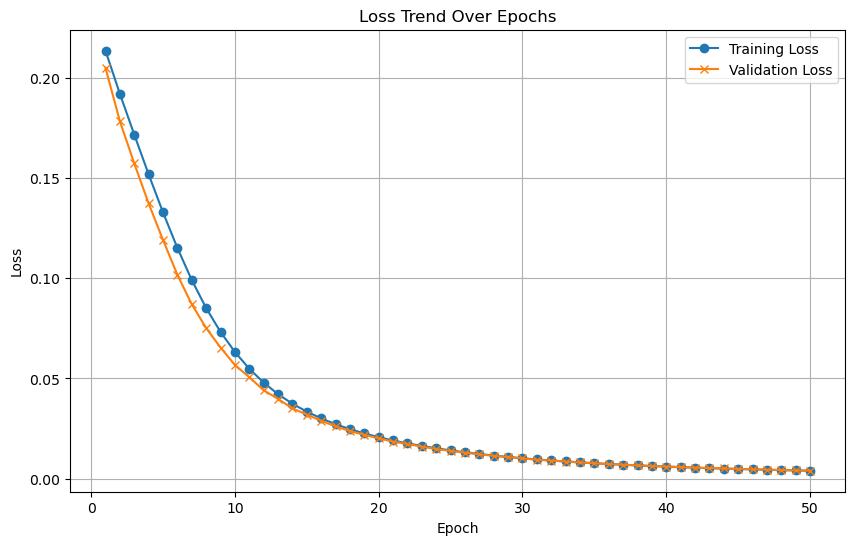

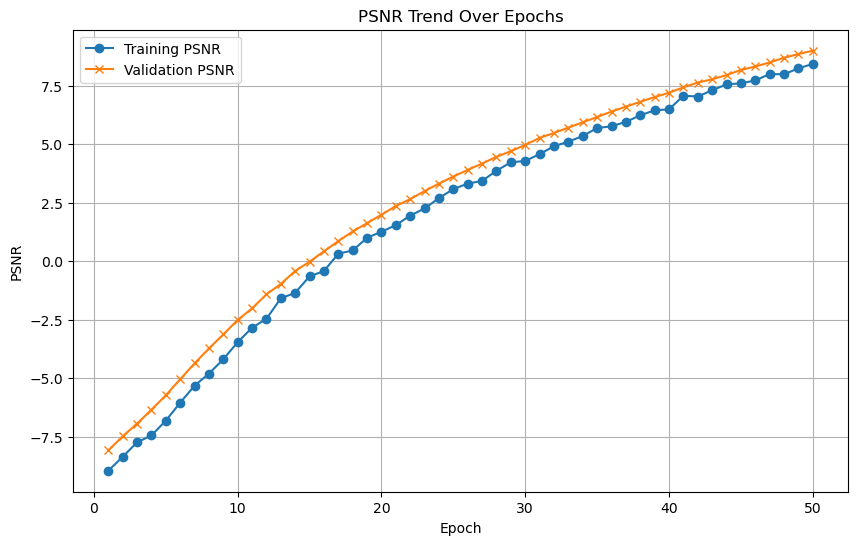

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/1 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/13 for test dataset.
Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training


Epoch [1/1000] completed, Average Training Loss: 2.6579
    Validation Batch [1/1], Loss: 2.6433
Validation Loss: 2.6433, Validation Accuracy: 7.14%
Validation loss improved from inf to 2.6433. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.6177
    Validation Batch [1/1], Loss: 2.6433
Validation Loss: 2.6433, Validation Accuracy: 7.14%
Validation loss improved from 2.6433 to 2.6433. Saving model...

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.5835
    Validation Batch [1/1], Loss: 2.6433
Validation Loss: 2.6433, Validation Accuracy: 7.14%
Validation loss improved from 2.6433 to 2.6433. Saving model...

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.5686
    Validation Batch [1/1], Loss: 2.6433
Validation Loss: 2.6433, Validation Accuracy: 7.14%
Validation loss improved from 2.6433 to 2.6433. Saving model...

LOG: Epoch [5/1000] - Training
Epoch [5/1000] complete

Epoch [24/1000] completed, Average Training Loss: 2.3521
    Validation Batch [1/1], Loss: 2.6418
Validation Loss: 2.6418, Validation Accuracy: 7.14%
Validation loss improved from 2.6421 to 2.6418. Saving model...

LOG: Epoch [25/1000] - Training
Epoch [25/1000] completed, Average Training Loss: 2.3371
    Validation Batch [1/1], Loss: 2.6415
Validation Loss: 2.6415, Validation Accuracy: 7.14%
Validation loss improved from 2.6418 to 2.6415. Saving model...

LOG: Epoch [26/1000] - Training
Epoch [26/1000] completed, Average Training Loss: 2.3096
    Validation Batch [1/1], Loss: 2.6412
Validation Loss: 2.6412, Validation Accuracy: 7.14%
Validation loss improved from 2.6415 to 2.6412. Saving model...

LOG: Epoch [27/1000] - Training
Epoch [27/1000] completed, Average Training Loss: 2.3005
    Validation Batch [1/1], Loss: 2.6409
Validation Loss: 2.6409, Validation Accuracy: 7.14%
Validation loss improved from 2.6412 to 2.6409. Saving model...

LOG: Epoch [28/1000] - Training
Epoch [28/10

Epoch [30/1000] completed, Average Training Loss: 2.2920
    Validation Batch [1/1], Loss: 2.6397
Validation Loss: 2.6397, Validation Accuracy: 7.14%
Validation loss improved from 2.6402 to 2.6397. Saving model...

LOG: Epoch [31/1000] - Training
Epoch [31/1000] completed, Average Training Loss: 2.3031
    Validation Batch [1/1], Loss: 2.6392
Validation Loss: 2.6392, Validation Accuracy: 7.14%
Validation loss improved from 2.6397 to 2.6392. Saving model...

LOG: Epoch [32/1000] - Training
Epoch [32/1000] completed, Average Training Loss: 2.2717
    Validation Batch [1/1], Loss: 2.6387
Validation Loss: 2.6387, Validation Accuracy: 7.14%
Validation loss improved from 2.6392 to 2.6387. Saving model...

LOG: Epoch [33/1000] - Training
Epoch [33/1000] completed, Average Training Loss: 2.2665
    Validation Batch [1/1], Loss: 2.6379
Validation Loss: 2.6379, Validation Accuracy: 7.14%
Validation loss improved from 2.6387 to 2.6379. Saving model...

LOG: Epoch [34/1000] - Training
Epoch [34/10

Epoch [53/1000] completed, Average Training Loss: 2.1062
    Validation Batch [1/1], Loss: 2.5946
Validation Loss: 2.5946, Validation Accuracy: 14.29%
Validation loss improved from 2.5990 to 2.5946. Saving model...

LOG: Epoch [54/1000] - Training
Epoch [54/1000] completed, Average Training Loss: 2.1172
    Validation Batch [1/1], Loss: 2.5908
Validation Loss: 2.5908, Validation Accuracy: 14.29%
Validation loss improved from 2.5946 to 2.5908. Saving model...

LOG: Epoch [55/1000] - Training
Epoch [55/1000] completed, Average Training Loss: 2.1134
    Validation Batch [1/1], Loss: 2.5870
Validation Loss: 2.5870, Validation Accuracy: 14.29%
Validation loss improved from 2.5908 to 2.5870. Saving model...

LOG: Epoch [56/1000] - Training
Epoch [56/1000] completed, Average Training Loss: 2.0649
    Validation Batch [1/1], Loss: 2.5827
Validation Loss: 2.5827, Validation Accuracy: 14.29%
Validation loss improved from 2.5870 to 2.5827. Saving model...

LOG: Epoch [57/1000] - Training
Epoch [5

    Validation Batch [1/1], Loss: 2.5635
Validation Loss: 2.5635, Validation Accuracy: 14.29%
Validation loss improved from 2.5692 to 2.5635. Saving model...

LOG: Epoch [61/1000] - Training
Epoch [61/1000] completed, Average Training Loss: 2.0466
    Validation Batch [1/1], Loss: 2.5569
Validation Loss: 2.5569, Validation Accuracy: 14.29%
Validation loss improved from 2.5635 to 2.5569. Saving model...

LOG: Epoch [62/1000] - Training
Epoch [62/1000] completed, Average Training Loss: 2.0299
    Validation Batch [1/1], Loss: 2.5490
Validation Loss: 2.5490, Validation Accuracy: 14.29%
Validation loss improved from 2.5569 to 2.5490. Saving model...

LOG: Epoch [63/1000] - Training
Epoch [63/1000] completed, Average Training Loss: 2.0452
    Validation Batch [1/1], Loss: 2.5389
Validation Loss: 2.5389, Validation Accuracy: 14.29%
Validation loss improved from 2.5490 to 2.5389. Saving model...

LOG: Epoch [64/1000] - Training
Epoch [64/1000] completed, Average Training Loss: 2.0469
    Vali

Epoch [81/1000] completed, Average Training Loss: 1.9241
    Validation Batch [1/1], Loss: 2.2778
Validation Loss: 2.2778, Validation Accuracy: 47.14%
Validation loss improved from 2.2994 to 2.2778. Saving model...

LOG: Epoch [82/1000] - Training
Epoch [82/1000] completed, Average Training Loss: 1.8677
    Validation Batch [1/1], Loss: 2.2593
Validation Loss: 2.2593, Validation Accuracy: 48.57%
Validation loss improved from 2.2778 to 2.2593. Saving model...

LOG: Epoch [83/1000] - Training
Epoch [83/1000] completed, Average Training Loss: 1.8897
    Validation Batch [1/1], Loss: 2.2504
Validation Loss: 2.2504, Validation Accuracy: 48.57%
Validation loss improved from 2.2593 to 2.2504. Saving model...

LOG: Epoch [84/1000] - Training
Epoch [84/1000] completed, Average Training Loss: 1.8559
    Validation Batch [1/1], Loss: 2.2348
Validation Loss: 2.2348, Validation Accuracy: 51.43%
Validation loss improved from 2.2504 to 2.2348. Saving model...

LOG: Epoch [85/1000] - Training
Epoch [8

Epoch [89/1000] completed, Average Training Loss: 1.8588
    Validation Batch [1/1], Loss: 2.1141
Validation Loss: 2.1141, Validation Accuracy: 57.14%
Validation loss improved from 2.1266 to 2.1141. Saving model...

LOG: Epoch [90/1000] - Training
Epoch [90/1000] completed, Average Training Loss: 1.8056
    Validation Batch [1/1], Loss: 2.1053
Validation Loss: 2.1053, Validation Accuracy: 61.43%
Validation loss improved from 2.1141 to 2.1053. Saving model...

LOG: Epoch [91/1000] - Training
Epoch [91/1000] completed, Average Training Loss: 1.8461
    Validation Batch [1/1], Loss: 2.1052
Validation Loss: 2.1052, Validation Accuracy: 61.43%
Validation loss improved from 2.1053 to 2.1052. Saving model...

LOG: Epoch [92/1000] - Training
Epoch [92/1000] completed, Average Training Loss: 1.8415
    Validation Batch [1/1], Loss: 2.0849
Validation Loss: 2.0849, Validation Accuracy: 65.71%
Validation loss improved from 2.1052 to 2.0849. Saving model...

LOG: Epoch [93/1000] - Training
Epoch [9

    Validation Batch [1/1], Loss: 1.9133
Validation Loss: 1.9133, Validation Accuracy: 75.71%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [111/1000] - Training
Epoch [111/1000] completed, Average Training Loss: 1.6327
    Validation Batch [1/1], Loss: 1.9206
Validation Loss: 1.9206, Validation Accuracy: 72.86%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [112/1000] - Training
Epoch [112/1000] completed, Average Training Loss: 1.6331
    Validation Batch [1/1], Loss: 1.8813
Validation Loss: 1.8813, Validation Accuracy: 70.00%
Validation loss improved from 1.8835 to 1.8813. Saving model...

LOG: Epoch [113/1000] - Training
Epoch [113/1000] completed, Average Training Loss: 1.6345
    Validation Batch [1/1], Loss: 1.8535
Validation Loss: 1.8535, Validation Accuracy: 67.14%
Validation loss improved from 1.8813 to 1.8535. Saving model...

LOG: Epoch [114/1000] - Training
Epoch [114/1000] completed, Average Training Loss: 1.6153
    Validation Batch [1/1], Lo

Epoch [119/1000] completed, Average Training Loss: 1.5771
    Validation Batch [1/1], Loss: 1.7987
Validation Loss: 1.7987, Validation Accuracy: 75.71%
Validation loss improved from 1.8110 to 1.7987. Saving model...

LOG: Epoch [120/1000] - Training
Epoch [120/1000] completed, Average Training Loss: 1.5643
    Validation Batch [1/1], Loss: 1.7943
Validation Loss: 1.7943, Validation Accuracy: 77.14%
Validation loss improved from 1.7987 to 1.7943. Saving model...

LOG: Epoch [121/1000] - Training
Epoch [121/1000] completed, Average Training Loss: 1.5549
    Validation Batch [1/1], Loss: 1.7839
Validation Loss: 1.7839, Validation Accuracy: 78.57%
Validation loss improved from 1.7943 to 1.7839. Saving model...

LOG: Epoch [122/1000] - Training
Epoch [122/1000] completed, Average Training Loss: 1.5760
    Validation Batch [1/1], Loss: 1.7650
Validation Loss: 1.7650, Validation Accuracy: 78.57%
Validation loss improved from 1.7839 to 1.7650. Saving model...

LOG: Epoch [123/1000] - Training


    Validation Batch [1/1], Loss: 1.6607
Validation Loss: 1.6607, Validation Accuracy: 80.00%
Validation loss improved from 1.6717 to 1.6607. Saving model...

LOG: Epoch [140/1000] - Training
Epoch [140/1000] completed, Average Training Loss: 1.4203
    Validation Batch [1/1], Loss: 1.6291
Validation Loss: 1.6291, Validation Accuracy: 82.86%
Validation loss improved from 1.6607 to 1.6291. Saving model...

LOG: Epoch [141/1000] - Training
Epoch [141/1000] completed, Average Training Loss: 1.3889
    Validation Batch [1/1], Loss: 1.6077
Validation Loss: 1.6077, Validation Accuracy: 81.43%
Validation loss improved from 1.6291 to 1.6077. Saving model...

LOG: Epoch [142/1000] - Training
Epoch [142/1000] completed, Average Training Loss: 1.4959
    Validation Batch [1/1], Loss: 1.6138
Validation Loss: 1.6138, Validation Accuracy: 81.43%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [143/1000] - Training
Epoch [143/1000] completed, Average Training Loss: 1.3909
    Validation 

    Validation Batch [1/1], Loss: 1.5780
Validation Loss: 1.5780, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [150/1000] - Training
Epoch [150/1000] completed, Average Training Loss: 1.2867
    Validation Batch [1/1], Loss: 1.5660
Validation Loss: 1.5660, Validation Accuracy: 84.29%
Validation loss improved from 1.5728 to 1.5660. Saving model...

LOG: Epoch [151/1000] - Training
Epoch [151/1000] completed, Average Training Loss: 1.3326
    Validation Batch [1/1], Loss: 1.5464
Validation Loss: 1.5464, Validation Accuracy: 82.86%
Validation loss improved from 1.5660 to 1.5464. Saving model...

LOG: Epoch [152/1000] - Training
Epoch [152/1000] completed, Average Training Loss: 1.2981
    Validation Batch [1/1], Loss: 1.5535
Validation Loss: 1.5535, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [153/1000] - Training
Epoch [153/1000] completed, Average Training Loss: 1.3953
    Validation Batch [1/1], Lo

Epoch [167/1000] completed, Average Training Loss: 1.1874
    Validation Batch [1/1], Loss: 1.4747
Validation Loss: 1.4747, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [168/1000] - Training
Epoch [168/1000] completed, Average Training Loss: 1.1787
    Validation Batch [1/1], Loss: 1.4654
Validation Loss: 1.4654, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [169/1000] - Training
Epoch [169/1000] completed, Average Training Loss: 1.1296
    Validation Batch [1/1], Loss: 1.4368
Validation Loss: 1.4368, Validation Accuracy: 87.14%
Validation loss improved from 1.4595 to 1.4368. Saving model...

LOG: Epoch [170/1000] - Training
Epoch [170/1000] completed, Average Training Loss: 1.1927
    Validation Batch [1/1], Loss: 1.4193
Validation Loss: 1.4193, Validation Accuracy: 85.71%
Validation loss improved from 1.4368 to 1.4193. Saving model...

LOG: Epoch [171/1000] - Training
Epoch [171/1000] completed, Av

Epoch [177/1000] completed, Average Training Loss: 1.1464
    Validation Batch [1/1], Loss: 1.3868
Validation Loss: 1.3868, Validation Accuracy: 85.71%
Validation loss improved from 1.4032 to 1.3868. Saving model...

LOG: Epoch [178/1000] - Training
Epoch [178/1000] completed, Average Training Loss: 1.1814
    Validation Batch [1/1], Loss: 1.4038
Validation Loss: 1.4038, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [179/1000] - Training
Epoch [179/1000] completed, Average Training Loss: 1.0951
    Validation Batch [1/1], Loss: 1.3965
Validation Loss: 1.3965, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [180/1000] - Training
Epoch [180/1000] completed, Average Training Loss: 1.1464
    Validation Batch [1/1], Loss: 1.3873
Validation Loss: 1.3873, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [181/1000] - Training
Epoch [181/1000] completed, Average Training 

    Validation Batch [1/1], Loss: 1.2644
Validation Loss: 1.2644, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [198/1000] - Training
Epoch [198/1000] completed, Average Training Loss: 0.9887
    Validation Batch [1/1], Loss: 1.2642
Validation Loss: 1.2642, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [199/1000] - Training
Epoch [199/1000] completed, Average Training Loss: 0.9372
    Validation Batch [1/1], Loss: 1.2686
Validation Loss: 1.2686, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [200/1000] - Training
Epoch [200/1000] completed, Average Training Loss: 0.8954
    Validation Batch [1/1], Loss: 1.2510
Validation Loss: 1.2510, Validation Accuracy: 84.29%
Validation loss improved from 1.2635 to 1.2510. Saving model...

LOG: Epoch [201/1000] - Training
Epoch [201/1000] completed, Average Training Loss: 0.9781
    Validation Batch [1/1], Loss: 1.2437
Vali

Epoch [203/1000] completed, Average Training Loss: 0.9586
    Validation Batch [1/1], Loss: 1.2822
Validation Loss: 1.2822, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [204/1000] - Training
Epoch [204/1000] completed, Average Training Loss: 0.9451
    Validation Batch [1/1], Loss: 1.2617
Validation Loss: 1.2617, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [205/1000] - Training
Epoch [205/1000] completed, Average Training Loss: 0.9192
    Validation Batch [1/1], Loss: 1.2245
Validation Loss: 1.2245, Validation Accuracy: 87.14%
Validation loss improved from 1.2437 to 1.2245. Saving model...

LOG: Epoch [206/1000] - Training
Epoch [206/1000] completed, Average Training Loss: 0.8911
    Validation Batch [1/1], Loss: 1.2199
Validation Loss: 1.2199, Validation Accuracy: 84.29%
Validation loss improved from 1.2245 to 1.2199. Saving model...

LOG: Epoch [207/1000] - Training
Epoch [207/1000] completed, Av

Epoch [228/1000] completed, Average Training Loss: 0.7677
    Validation Batch [1/1], Loss: 1.0929
Validation Loss: 1.0929, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [229/1000] - Training
Epoch [229/1000] completed, Average Training Loss: 0.7889
    Validation Batch [1/1], Loss: 1.0945
Validation Loss: 1.0945, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [230/1000] - Training
Epoch [230/1000] completed, Average Training Loss: 0.7486
    Validation Batch [1/1], Loss: 1.0863
Validation Loss: 1.0863, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [231/1000] - Training
Epoch [231/1000] completed, Average Training Loss: 0.6456
    Validation Batch [1/1], Loss: 1.0754
Validation Loss: 1.0754, Validation Accuracy: 87.14%
Validation loss improved from 1.0826 to 1.0754. Saving model...

LOG: Epoch [232/1000] - Training
Epoch [232/1000] completed, Average Training 

Epoch [234/1000] completed, Average Training Loss: 0.6711
    Validation Batch [1/1], Loss: 1.0841
Validation Loss: 1.0841, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [235/1000] - Training
Epoch [235/1000] completed, Average Training Loss: 0.6466
    Validation Batch [1/1], Loss: 1.0615
Validation Loss: 1.0615, Validation Accuracy: 87.14%
Validation loss improved from 1.0754 to 1.0615. Saving model...

LOG: Epoch [236/1000] - Training
Epoch [236/1000] completed, Average Training Loss: 0.7120
    Validation Batch [1/1], Loss: 1.0533
Validation Loss: 1.0533, Validation Accuracy: 87.14%
Validation loss improved from 1.0615 to 1.0533. Saving model...

LOG: Epoch [237/1000] - Training
Epoch [237/1000] completed, Average Training Loss: 0.6761
    Validation Batch [1/1], Loss: 1.0471
Validation Loss: 1.0471, Validation Accuracy: 85.71%
Validation loss improved from 1.0533 to 1.0471. Saving model...

LOG: Epoch [238/1000] - Training
Epoch [238/1000


LOG: Epoch [258/1000] - Training
Epoch [258/1000] completed, Average Training Loss: 0.5702
    Validation Batch [1/1], Loss: 0.9614
Validation Loss: 0.9614, Validation Accuracy: 85.71%
Validation loss improved from 0.9755 to 0.9614. Saving model...

LOG: Epoch [259/1000] - Training
Epoch [259/1000] completed, Average Training Loss: 0.6068
    Validation Batch [1/1], Loss: 0.9541
Validation Loss: 0.9541, Validation Accuracy: 87.14%
Validation loss improved from 0.9614 to 0.9541. Saving model...

LOG: Epoch [260/1000] - Training
Epoch [260/1000] completed, Average Training Loss: 0.6393
    Validation Batch [1/1], Loss: 0.9645
Validation Loss: 0.9645, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [261/1000] - Training
Epoch [261/1000] completed, Average Training Loss: 0.5544
    Validation Batch [1/1], Loss: 0.9724
Validation Loss: 0.9724, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [262/1000] - Train

    Validation Batch [1/1], Loss: 0.8938
Validation Loss: 0.8938, Validation Accuracy: 87.14%
Validation loss improved from 0.9262 to 0.8938. Saving model...

LOG: Epoch [267/1000] - Training
Epoch [267/1000] completed, Average Training Loss: 0.5034
    Validation Batch [1/1], Loss: 0.8941
Validation Loss: 0.8941, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [268/1000] - Training
Epoch [268/1000] completed, Average Training Loss: 0.4839
    Validation Batch [1/1], Loss: 0.9093
Validation Loss: 0.9093, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [269/1000] - Training
Epoch [269/1000] completed, Average Training Loss: 0.5643
    Validation Batch [1/1], Loss: 0.9223
Validation Loss: 0.9223, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [270/1000] - Training
Epoch [270/1000] completed, Average Training Loss: 0.4697
    Validation Batch [1/1], Loss: 0.9072
Vali

    Validation Batch [1/1], Loss: 0.8337
Validation Loss: 0.8337, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [290/1000] - Training
Epoch [290/1000] completed, Average Training Loss: 0.4313
    Validation Batch [1/1], Loss: 0.8765
Validation Loss: 0.8765, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [291/1000] - Training
Epoch [291/1000] completed, Average Training Loss: 0.4699
    Validation Batch [1/1], Loss: 0.8760
Validation Loss: 0.8760, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [292/1000] - Training
Epoch [292/1000] completed, Average Training Loss: 0.4103
    Validation Batch [1/1], Loss: 0.8366
Validation Loss: 0.8366, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [293/1000] - Training
Epoch [293/1000] completed, Average Training Loss: 0.4575
    Validation Batch [1/1], Loss: 0.8032
Validation Loss: 0.

Epoch [296/1000] completed, Average Training Loss: 0.4003
    Validation Batch [1/1], Loss: 0.8809
Validation Loss: 0.8809, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [297/1000] - Training
Epoch [297/1000] completed, Average Training Loss: 0.3603
    Validation Batch [1/1], Loss: 0.8704
Validation Loss: 0.8704, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [298/1000] - Training
Epoch [298/1000] completed, Average Training Loss: 0.4232
    Validation Batch [1/1], Loss: 0.8300
Validation Loss: 0.8300, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [299/1000] - Training
Epoch [299/1000] completed, Average Training Loss: 0.3710
    Validation Batch [1/1], Loss: 0.8124
Validation Loss: 0.8124, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [300/1000] - Training
Epoch [300/1000] completed, Average Training Loss: 0.3726
  

Epoch [320/1000] completed, Average Training Loss: 0.3586
    Validation Batch [1/1], Loss: 0.7433
Validation Loss: 0.7433, Validation Accuracy: 87.14%
Validation loss improved from 0.7459 to 0.7433. Saving model...

LOG: Epoch [321/1000] - Training
Epoch [321/1000] completed, Average Training Loss: 0.3233
    Validation Batch [1/1], Loss: 0.7463
Validation Loss: 0.7463, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [322/1000] - Training
Epoch [322/1000] completed, Average Training Loss: 0.3167
    Validation Batch [1/1], Loss: 0.7427
Validation Loss: 0.7427, Validation Accuracy: 87.14%
Validation loss improved from 0.7433 to 0.7427. Saving model...

LOG: Epoch [323/1000] - Training
Epoch [323/1000] completed, Average Training Loss: 0.3388
    Validation Batch [1/1], Loss: 0.7361
Validation Loss: 0.7361, Validation Accuracy: 87.14%
Validation loss improved from 0.7427 to 0.7361. Saving model...

LOG: Epoch [324/1000] - Training
Epoch [324/1000

Epoch [326/1000] completed, Average Training Loss: 0.2981
    Validation Batch [1/1], Loss: 0.7491
Validation Loss: 0.7491, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [327/1000] - Training
Epoch [327/1000] completed, Average Training Loss: 0.3226
    Validation Batch [1/1], Loss: 0.7414
Validation Loss: 0.7414, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [328/1000] - Training
Epoch [328/1000] completed, Average Training Loss: 0.3100
    Validation Batch [1/1], Loss: 0.7176
Validation Loss: 0.7176, Validation Accuracy: 87.14%
Validation loss improved from 0.7348 to 0.7176. Saving model...

LOG: Epoch [329/1000] - Training
Epoch [329/1000] completed, Average Training Loss: 0.3496
    Validation Batch [1/1], Loss: 0.7135
Validation Loss: 0.7135, Validation Accuracy: 88.57%
Validation loss improved from 0.7176 to 0.7135. Saving model...

LOG: Epoch [330/1000] - Training
Epoch [330/1000] completed, Av

    Validation Batch [1/1], Loss: 0.6857
Validation Loss: 0.6857, Validation Accuracy: 88.57%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [349/1000] - Training
Epoch [349/1000] completed, Average Training Loss: 0.2251
    Validation Batch [1/1], Loss: 0.6764
Validation Loss: 0.6764, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [350/1000] - Training
Epoch [350/1000] completed, Average Training Loss: 0.2591
    Validation Batch [1/1], Loss: 0.6751
Validation Loss: 0.6751, Validation Accuracy: 88.57%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [351/1000] - Training
Epoch [351/1000] completed, Average Training Loss: 0.2658
    Validation Batch [1/1], Loss: 0.6627
Validation Loss: 0.6627, Validation Accuracy: 88.57%
Validation loss improved from 0.6669 to 0.6627. Saving model...

LOG: Epoch [352/1000] - Training
Epoch [352/1000] completed, Average Training Loss: 0.2761
    Validation Batch [1/1], Loss: 0.6551
Vali

Epoch [354/1000] completed, Average Training Loss: 0.2610
    Validation Batch [1/1], Loss: 0.6658
Validation Loss: 0.6658, Validation Accuracy: 88.57%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [355/1000] - Training
Epoch [355/1000] completed, Average Training Loss: 0.2071
    Validation Batch [1/1], Loss: 0.6614
Validation Loss: 0.6614, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [356/1000] - Training
Epoch [356/1000] completed, Average Training Loss: 0.2654
    Validation Batch [1/1], Loss: 0.6629
Validation Loss: 0.6629, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [357/1000] - Training
Epoch [357/1000] completed, Average Training Loss: 0.2151
    Validation Batch [1/1], Loss: 0.6640
Validation Loss: 0.6640, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [358/1000] - Training
Epoch [358/1000] completed, Average Training Loss: 0.2450
  

    Validation Batch [1/1], Loss: 0.6390
Validation Loss: 0.6390, Validation Accuracy: 88.57%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [378/1000] - Training
Epoch [378/1000] completed, Average Training Loss: 0.2363
    Validation Batch [1/1], Loss: 0.6326
Validation Loss: 0.6326, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [379/1000] - Training
Epoch [379/1000] completed, Average Training Loss: 0.2345
    Validation Batch [1/1], Loss: 0.6151
Validation Loss: 0.6151, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [380/1000] - Training
Epoch [380/1000] completed, Average Training Loss: 0.2270
    Validation Batch [1/1], Loss: 0.6093
Validation Loss: 0.6093, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [381/1000] - Training
Epoch [381/1000] completed, Average Training Loss: 0.1979
    Validation Batch [1/1], Loss: 0.6035
Validation Loss: 0.

Epoch [383/1000] completed, Average Training Loss: 0.2107
    Validation Batch [1/1], Loss: 0.6194
Validation Loss: 0.6194, Validation Accuracy: 88.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [384/1000] - Training
Epoch [384/1000] completed, Average Training Loss: 0.2939
    Validation Batch [1/1], Loss: 0.6407
Validation Loss: 0.6407, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [385/1000] - Training
Epoch [385/1000] completed, Average Training Loss: 0.1909
    Validation Batch [1/1], Loss: 0.6771
Validation Loss: 0.6771, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [386/1000] - Training
Epoch [386/1000] completed, Average Training Loss: 0.2113
    Validation Batch [1/1], Loss: 0.6966
Validation Loss: 0.6966, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [387/1000] - Training
Epoch [387/1000] completed, Average Training Loss: 0.2350
  

Epoch [406/1000] completed, Average Training Loss: 0.1775
    Validation Batch [1/1], Loss: 0.6264
Validation Loss: 0.6264, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [407/1000] - Training
Epoch [407/1000] completed, Average Training Loss: 0.2677
    Validation Batch [1/1], Loss: 0.5779
Validation Loss: 0.5779, Validation Accuracy: 88.57%
Validation loss improved from 0.5820 to 0.5779. Saving model...

LOG: Epoch [408/1000] - Training
Epoch [408/1000] completed, Average Training Loss: 0.1289
    Validation Batch [1/1], Loss: 0.5619
Validation Loss: 0.5619, Validation Accuracy: 88.57%
Validation loss improved from 0.5779 to 0.5619. Saving model...

LOG: Epoch [409/1000] - Training
Epoch [409/1000] completed, Average Training Loss: 0.1678
    Validation Batch [1/1], Loss: 0.5684
Validation Loss: 0.5684, Validation Accuracy: 88.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [410/1000] - Training
Epoch [410/1000] completed, A

Epoch [415/1000] completed, Average Training Loss: 0.1537
    Validation Batch [1/1], Loss: 0.5514
Validation Loss: 0.5514, Validation Accuracy: 92.86%
Validation loss improved from 0.5619 to 0.5514. Saving model...

LOG: Epoch [416/1000] - Training
Epoch [416/1000] completed, Average Training Loss: 0.2004
    Validation Batch [1/1], Loss: 0.5332
Validation Loss: 0.5332, Validation Accuracy: 92.86%
Validation loss improved from 0.5514 to 0.5332. Saving model...

LOG: Epoch [417/1000] - Training
Epoch [417/1000] completed, Average Training Loss: 0.1770
    Validation Batch [1/1], Loss: 0.5321
Validation Loss: 0.5321, Validation Accuracy: 91.43%
Validation loss improved from 0.5332 to 0.5321. Saving model...

LOG: Epoch [418/1000] - Training
Epoch [418/1000] completed, Average Training Loss: 0.1574
    Validation Batch [1/1], Loss: 0.5504
Validation Loss: 0.5504, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [419/1000] - Training
Epoch [419/1000

    Validation Batch [1/1], Loss: 0.5436
Validation Loss: 0.5436, Validation Accuracy: 88.57%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [436/1000] - Training
Epoch [436/1000] completed, Average Training Loss: 0.1315
    Validation Batch [1/1], Loss: 0.5284
Validation Loss: 0.5284, Validation Accuracy: 90.00%
Validation loss improved from 0.5321 to 0.5284. Saving model...

LOG: Epoch [437/1000] - Training
Epoch [437/1000] completed, Average Training Loss: 0.1416
    Validation Batch [1/1], Loss: 0.5239
Validation Loss: 0.5239, Validation Accuracy: 91.43%
Validation loss improved from 0.5284 to 0.5239. Saving model...

LOG: Epoch [438/1000] - Training
Epoch [438/1000] completed, Average Training Loss: 0.1471
    Validation Batch [1/1], Loss: 0.5219
Validation Loss: 0.5219, Validation Accuracy: 90.00%
Validation loss improved from 0.5239 to 0.5219. Saving model...

LOG: Epoch [439/1000] - Training
Epoch [439/1000] completed, Average Training Loss: 0.1357
    Validation

    Validation Batch [1/1], Loss: 0.5634
Validation Loss: 0.5634, Validation Accuracy: 88.57%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [444/1000] - Training
Epoch [444/1000] completed, Average Training Loss: 0.1468
    Validation Batch [1/1], Loss: 0.5456
Validation Loss: 0.5456, Validation Accuracy: 88.57%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [445/1000] - Training
Epoch [445/1000] completed, Average Training Loss: 0.1337
    Validation Batch [1/1], Loss: 0.5426
Validation Loss: 0.5426, Validation Accuracy: 88.57%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [446/1000] - Training
Epoch [446/1000] completed, Average Training Loss: 0.1458
    Validation Batch [1/1], Loss: 0.5540
Validation Loss: 0.5540, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [447/1000] - Training
Epoch [447/1000] completed, Average Training Loss: 0.1655
    Validation Batch [1/1], Loss: 0.5469
Validation Loss: 0.

Epoch [464/1000] completed, Average Training Loss: 0.1001
    Validation Batch [1/1], Loss: 0.5133
Validation Loss: 0.5133, Validation Accuracy: 87.14%
Validation loss improved from 0.5190 to 0.5133. Saving model...

LOG: Epoch [465/1000] - Training
Epoch [465/1000] completed, Average Training Loss: 0.1338
    Validation Batch [1/1], Loss: 0.5090
Validation Loss: 0.5090, Validation Accuracy: 88.57%
Validation loss improved from 0.5133 to 0.5090. Saving model...

LOG: Epoch [466/1000] - Training
Epoch [466/1000] completed, Average Training Loss: 0.1417
    Validation Batch [1/1], Loss: 0.5143
Validation Loss: 0.5143, Validation Accuracy: 88.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [467/1000] - Training
Epoch [467/1000] completed, Average Training Loss: 0.1432
    Validation Batch [1/1], Loss: 0.5272
Validation Loss: 0.5272, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [468/1000] - Training
Epoch [468/1000] completed, Av

    Validation Batch [1/1], Loss: 0.5169
Validation Loss: 0.5169, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [472/1000] - Training
Epoch [472/1000] completed, Average Training Loss: 0.1506
    Validation Batch [1/1], Loss: 0.4993
Validation Loss: 0.4993, Validation Accuracy: 90.00%
Validation loss improved from 0.5090 to 0.4993. Saving model...

LOG: Epoch [473/1000] - Training
Epoch [473/1000] completed, Average Training Loss: 0.1217
    Validation Batch [1/1], Loss: 0.5014
Validation Loss: 0.5014, Validation Accuracy: 91.43%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [474/1000] - Training
Epoch [474/1000] completed, Average Training Loss: 0.1106
    Validation Batch [1/1], Loss: 0.5108
Validation Loss: 0.5108, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [475/1000] - Training
Epoch [475/1000] completed, Average Training Loss: 0.1186
    Validation Batch [1/1], Loss: 0.5098
Vali


LOG: Epoch [494/1000] - Training
Epoch [494/1000] completed, Average Training Loss: 0.0868
    Validation Batch [1/1], Loss: 0.4882
Validation Loss: 0.4882, Validation Accuracy: 90.00%
Validation loss improved from 0.4916 to 0.4882. Saving model...

LOG: Epoch [495/1000] - Training
Epoch [495/1000] completed, Average Training Loss: 0.0879
    Validation Batch [1/1], Loss: 0.5192
Validation Loss: 0.5192, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [496/1000] - Training
Epoch [496/1000] completed, Average Training Loss: 0.1280
    Validation Batch [1/1], Loss: 0.5451
Validation Loss: 0.5451, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [497/1000] - Training
Epoch [497/1000] completed, Average Training Loss: 0.0976
    Validation Batch [1/1], Loss: 0.5514
Validation Loss: 0.5514, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [498/1000] - Training
Epoch [498/

Epoch [500/1000] completed, Average Training Loss: 0.0910
    Validation Batch [1/1], Loss: 0.5706
Validation Loss: 0.5706, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [501/1000] - Training
Epoch [501/1000] completed, Average Training Loss: 0.0966
    Validation Batch [1/1], Loss: 0.5693
Validation Loss: 0.5693, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [502/1000] - Training
Epoch [502/1000] completed, Average Training Loss: 0.1179
    Validation Batch [1/1], Loss: 0.5528
Validation Loss: 0.5528, Validation Accuracy: 88.57%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [503/1000] - Training
Epoch [503/1000] completed, Average Training Loss: 0.0978
    Validation Batch [1/1], Loss: 0.5411
Validation Loss: 0.5411, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [504/1000] - Training
Epoch [504/1000] completed, Average Training Loss: 0.0825
  

Epoch [525/1000] completed, Average Training Loss: 0.0928
    Validation Batch [1/1], Loss: 0.5095
Validation Loss: 0.5095, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [526/1000] - Training
Epoch [526/1000] completed, Average Training Loss: 0.0744
    Validation Batch [1/1], Loss: 0.5035
Validation Loss: 0.5035, Validation Accuracy: 88.57%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [527/1000] - Training
Epoch [527/1000] completed, Average Training Loss: 0.1236
    Validation Batch [1/1], Loss: 0.5004
Validation Loss: 0.5004, Validation Accuracy: 88.57%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [528/1000] - Training
Epoch [528/1000] completed, Average Training Loss: 0.0862
    Validation Batch [1/1], Loss: 0.5016
Validation Loss: 0.5016, Validation Accuracy: 88.57%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [529/1000] - Training
Epoch [529/1000] completed, Average Training Loss: 0.1209


Epoch [531/1000] completed, Average Training Loss: 0.0903
    Validation Batch [1/1], Loss: 0.5192
Validation Loss: 0.5192, Validation Accuracy: 88.57%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [532/1000] - Training
Epoch [532/1000] completed, Average Training Loss: 0.0944
    Validation Batch [1/1], Loss: 0.5315
Validation Loss: 0.5315, Validation Accuracy: 88.57%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [533/1000] - Training
Epoch [533/1000] completed, Average Training Loss: 0.0794
    Validation Batch [1/1], Loss: 0.5380
Validation Loss: 0.5380, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [534/1000] - Training
Epoch [534/1000] completed, Average Training Loss: 0.0690
    Validation Batch [1/1], Loss: 0.5402
Validation Loss: 0.5402, Validation Accuracy: 88.57%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [535/1000] - Training
Epoch [535/1000] completed, Average Training Loss: 0.085

    Validation Batch [1/1], Loss: 0.4637
Validation Loss: 0.4637, Validation Accuracy: 91.43%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [556/1000] - Training
Epoch [556/1000] completed, Average Training Loss: 0.0817
    Validation Batch [1/1], Loss: 0.4548
Validation Loss: 0.4548, Validation Accuracy: 91.43%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [557/1000] - Training
Epoch [557/1000] completed, Average Training Loss: 0.0926
    Validation Batch [1/1], Loss: 0.4617
Validation Loss: 0.4617, Validation Accuracy: 91.43%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [558/1000] - Training
Epoch [558/1000] completed, Average Training Loss: 0.1217
    Validation Batch [1/1], Loss: 0.4812
Validation Loss: 0.4812, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [559/1000] - Training
Epoch [559/1000] completed, Average Training Loss: 0.0609
    Validation Batch [1/1], Loss: 0.4982
Validation Loss

Epoch [563/1000] completed, Average Training Loss: 0.0778
    Validation Batch [1/1], Loss: 0.5413
Validation Loss: 0.5413, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [564/1000] - Training
Epoch [564/1000] completed, Average Training Loss: 0.0543
    Validation Batch [1/1], Loss: 0.5293
Validation Loss: 0.5293, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [565/1000] - Training
Epoch [565/1000] completed, Average Training Loss: 0.0506
    Validation Batch [1/1], Loss: 0.5004
Validation Loss: 0.5004, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 26/100

LOG: Epoch [566/1000] - Training
Epoch [566/1000] completed, Average Training Loss: 0.0769
    Validation Batch [1/1], Loss: 0.4789
Validation Loss: 0.4789, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 27/100

LOG: Epoch [567/1000] - Training
Epoch [567/1000] completed, Average Training Loss: 0.080

Epoch [586/1000] completed, Average Training Loss: 0.0594
    Validation Batch [1/1], Loss: 0.4528
Validation Loss: 0.4528, Validation Accuracy: 88.57%
Validation loss did not improve. Patience: 47/100

LOG: Epoch [587/1000] - Training
Epoch [587/1000] completed, Average Training Loss: 0.0632
    Validation Batch [1/1], Loss: 0.4438
Validation Loss: 0.4438, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 48/100

LOG: Epoch [588/1000] - Training
Epoch [588/1000] completed, Average Training Loss: 0.0667
    Validation Batch [1/1], Loss: 0.4403
Validation Loss: 0.4403, Validation Accuracy: 91.43%
Validation loss did not improve. Patience: 49/100

LOG: Epoch [589/1000] - Training
Epoch [589/1000] completed, Average Training Loss: 0.0649
    Validation Batch [1/1], Loss: 0.4385
Validation Loss: 0.4385, Validation Accuracy: 91.43%
Validation loss did not improve. Patience: 50/100

LOG: Epoch [590/1000] - Training
Epoch [590/1000] completed, Average Training Loss: 0.093

Epoch [592/1000] completed, Average Training Loss: 0.0632
    Validation Batch [1/1], Loss: 0.5176
Validation Loss: 0.5176, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 53/100

LOG: Epoch [593/1000] - Training
Epoch [593/1000] completed, Average Training Loss: 0.0591
    Validation Batch [1/1], Loss: 0.5432
Validation Loss: 0.5432, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 54/100

LOG: Epoch [594/1000] - Training
Epoch [594/1000] completed, Average Training Loss: 0.0533
    Validation Batch [1/1], Loss: 0.5709
Validation Loss: 0.5709, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 55/100

LOG: Epoch [595/1000] - Training
Epoch [595/1000] completed, Average Training Loss: 0.0623
    Validation Batch [1/1], Loss: 0.5635
Validation Loss: 0.5635, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 56/100

LOG: Epoch [596/1000] - Training
Epoch [596/1000] completed, Average Training Loss: 0.084

Epoch [614/1000] completed, Average Training Loss: 0.0536
    Validation Batch [1/1], Loss: 0.4772
Validation Loss: 0.4772, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 75/100

LOG: Epoch [615/1000] - Training
Epoch [615/1000] completed, Average Training Loss: 0.0775
    Validation Batch [1/1], Loss: 0.4929
Validation Loss: 0.4929, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 76/100

LOG: Epoch [616/1000] - Training
Epoch [616/1000] completed, Average Training Loss: 0.0485
    Validation Batch [1/1], Loss: 0.5309
Validation Loss: 0.5309, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 77/100

LOG: Epoch [617/1000] - Training
Epoch [617/1000] completed, Average Training Loss: 0.0556
    Validation Batch [1/1], Loss: 0.5645
Validation Loss: 0.5645, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 78/100

LOG: Epoch [618/1000] - Training
Epoch [618/1000] completed, Average Training Loss: 0.045

Epoch [625/1000] completed, Average Training Loss: 0.0433
    Validation Batch [1/1], Loss: 0.4414
Validation Loss: 0.4414, Validation Accuracy: 91.43%
Validation loss did not improve. Patience: 86/100

LOG: Epoch [626/1000] - Training
Epoch [626/1000] completed, Average Training Loss: 0.0484
    Validation Batch [1/1], Loss: 0.4352
Validation Loss: 0.4352, Validation Accuracy: 91.43%
Validation loss did not improve. Patience: 87/100

LOG: Epoch [627/1000] - Training
Epoch [627/1000] completed, Average Training Loss: 0.0705
    Validation Batch [1/1], Loss: 0.4468
Validation Loss: 0.4468, Validation Accuracy: 88.57%
Validation loss did not improve. Patience: 88/100

LOG: Epoch [628/1000] - Training
Epoch [628/1000] completed, Average Training Loss: 0.0664
    Validation Batch [1/1], Loss: 0.4473
Validation Loss: 0.4473, Validation Accuracy: 88.57%
Validation loss did not improve. Patience: 89/100

LOG: Epoch [629/1000] - Training
Epoch [629/1000] completed, Average Training Loss: 0.059

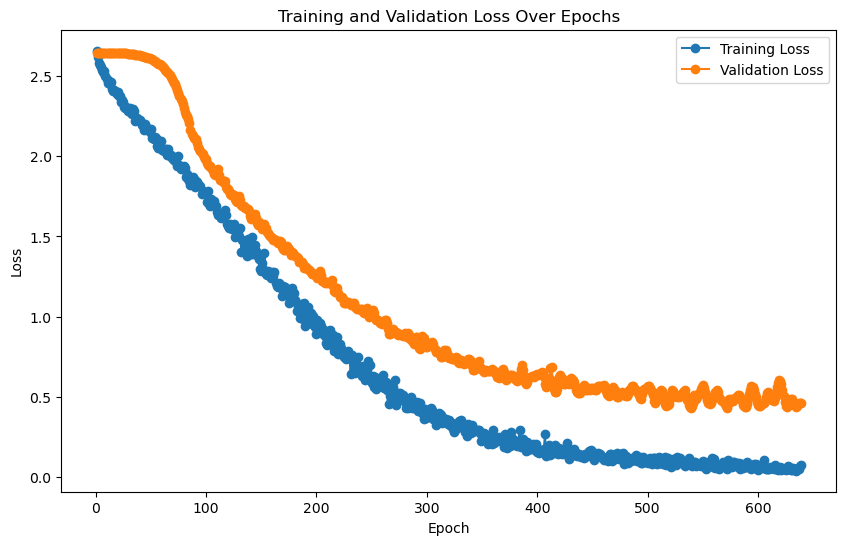

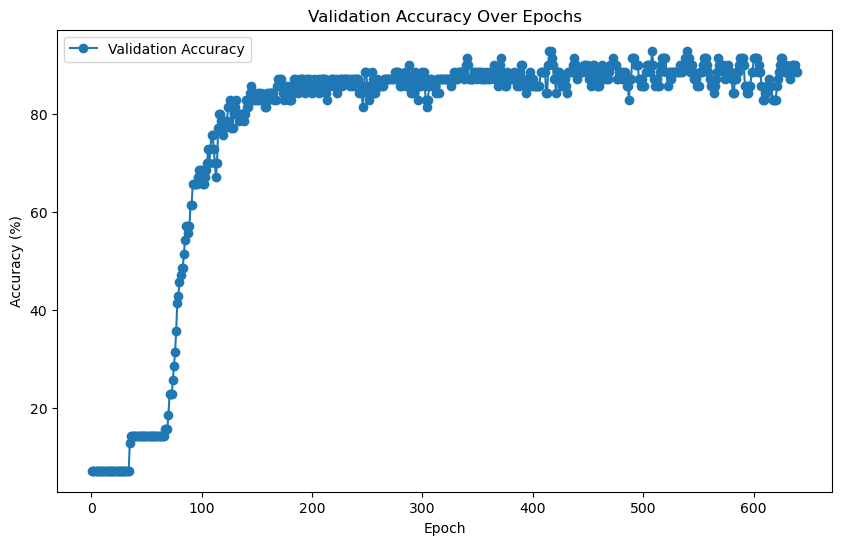


Evaluating on the test set...
    Test Batch [1/13], Loss: 0.1300

Final Test Loss: 0.3856, Test Accuracy: 90.03%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/13 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 3108 samples with 64 features each
LOG: Labels shape: (3108,)

LOG: Training features shape: (70, 64), Training labels shape: (70,)
LOG: Validation features shape: (70, 64), Validation labels shape: (70,)
LOG: Test features shape: (3108, 64), Test labels shape: (3108,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 62.86%

Validation Classification Report:
               precision    recall  f1-sco

C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 3108 samples with 64 features each
LOG: Labels shape: (3108,)
Train reps shape: (70, 64)
Train labels shape: (70,)
Val reps shape: (70, 64)
Val labels shape: (70,)
Test reps shape: (3108, 64)
Test labels shape: (3108,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.8133  |  Val Loss: 2.7195
Validation loss improved from inf to 2.7195.
[Epoch 2/1000] Train Loss: 2.7108  |  Val Loss: 2.6687
Validation loss improved from 2.7195 to 2.6687.
[Epoch 3/1000] Train Loss: 2.6639  |  Val Loss: 2.6392
Validation loss improved from 2.6687 to 2.6392.
[Epoch 4/1000] Train Loss: 2.6401  |  Val Loss: 2.6236
Validation loss improved from 2.6392 to 2.6236.
[Epoch 5/1000] Train Loss: 2.6243  |  Val Loss: 2.6155
Validation loss improved from 2.6236 to 2.6155.
[Epoch 6/1000] Train Loss: 2.6163  |  Val Loss: 2.6164
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 7/1000] Train Loss: 2.6167  |  Val Loss: 2.6133
Validation loss improved from 2.6155 to 2.6133.


[Epoch 8/1000] Train Loss: 2.6137  |  Val Loss: 2.6063
Validation loss improved from 2.6133 to 2.6063.
[Epoch 9/1000] Train Loss: 2.6067  |  Val Loss: 2.6010
Validation loss improved from 2.6063 to 2.6010.
[Epoch 10/1000] Train Loss: 2.6014  |  Val Loss: 2.6028
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 11/1000] Train Loss: 2.6013  |  Val Loss: 2.6005
Validation loss improved from 2.6010 to 2.6005.
[Epoch 12/1000] Train Loss: 2.5996  |  Val Loss: 2.5991
Validation loss improved from 2.6005 to 2.5991.
[Epoch 13/1000] Train Loss: 2.5975  |  Val Loss: 2.5958
Validation loss improved from 2.5991 to 2.5958.
[Epoch 14/1000] Train Loss: 2.5957  |  Val Loss: 2.5944
Validation loss improved from 2.5958 to 2.5944.
[Epoch 15/1000] Train Loss: 2.5961  |  Val Loss: 2.5941
Validation loss improved from 2.5944 to 2.5941.
[Epoch 16/1000] Train Loss: 2.5958  |  Val Loss: 2.5915
Validation loss improved from 2.5941 to 2.5915.
[Epoch 17/1000] Train Loss: 2.5927  |  Val Loss: 2.5873
Vali

[Epoch 31/1000] Train Loss: 2.5406  |  Val Loss: 2.5385
Validation loss improved from 2.5413 to 2.5385.
[Epoch 32/1000] Train Loss: 2.5356  |  Val Loss: 2.5324
Validation loss improved from 2.5385 to 2.5324.
[Epoch 33/1000] Train Loss: 2.5301  |  Val Loss: 2.5254
Validation loss improved from 2.5324 to 2.5254.
[Epoch 34/1000] Train Loss: 2.5223  |  Val Loss: 2.5161
Validation loss improved from 2.5254 to 2.5161.
[Epoch 35/1000] Train Loss: 2.5149  |  Val Loss: 2.5127
Validation loss improved from 2.5161 to 2.5127.
[Epoch 36/1000] Train Loss: 2.5126  |  Val Loss: 2.5120
Validation loss improved from 2.5127 to 2.5120.
[Epoch 37/1000] Train Loss: 2.5119  |  Val Loss: 2.5059
Validation loss improved from 2.5120 to 2.5059.
[Epoch 38/1000] Train Loss: 2.5042  |  Val Loss: 2.4995
Validation loss improved from 2.5059 to 2.4995.
[Epoch 39/1000] Train Loss: 2.5005  |  Val Loss: 2.4942
Validation loss improved from 2.4995 to 2.4942.
[Epoch 40/1000] Train Loss: 2.4952  |  Val Loss: 2.4832
Validati

[Epoch 44/1000] Train Loss: 2.4459  |  Val Loss: 2.4437
Validation loss improved from 2.4473 to 2.4437.
[Epoch 45/1000] Train Loss: 2.4437  |  Val Loss: 2.4399
Validation loss improved from 2.4437 to 2.4399.
[Epoch 46/1000] Train Loss: 2.4389  |  Val Loss: 2.4302
Validation loss improved from 2.4399 to 2.4302.
[Epoch 47/1000] Train Loss: 2.4281  |  Val Loss: 2.4190
Validation loss improved from 2.4302 to 2.4190.
[Epoch 48/1000] Train Loss: 2.4185  |  Val Loss: 2.4132
Validation loss improved from 2.4190 to 2.4132.
[Epoch 49/1000] Train Loss: 2.4122  |  Val Loss: 2.4077
Validation loss improved from 2.4132 to 2.4077.
[Epoch 50/1000] Train Loss: 2.4046  |  Val Loss: 2.3966
Validation loss improved from 2.4077 to 2.3966.
[Epoch 51/1000] Train Loss: 2.3912  |  Val Loss: 2.3783
Validation loss improved from 2.3966 to 2.3783.
[Epoch 52/1000] Train Loss: 2.3753  |  Val Loss: 2.3629
Validation loss improved from 2.3783 to 2.3629.
[Epoch 53/1000] Train Loss: 2.3591  |  Val Loss: 2.3513
Validati

[Epoch 70/1000] Train Loss: 2.1935  |  Val Loss: 2.1899
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 71/1000] Train Loss: 2.1867  |  Val Loss: 2.1353
Validation loss improved from 2.1539 to 2.1353.
[Epoch 72/1000] Train Loss: 2.1233  |  Val Loss: 2.1186
Validation loss improved from 2.1353 to 2.1186.
[Epoch 73/1000] Train Loss: 2.1084  |  Val Loss: 2.1502
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 74/1000] Train Loss: 2.1341  |  Val Loss: 2.1083
Validation loss improved from 2.1186 to 2.1083.
[Epoch 75/1000] Train Loss: 2.0943  |  Val Loss: 2.0725
Validation loss improved from 2.1083 to 2.0725.
[Epoch 76/1000] Train Loss: 2.0604  |  Val Loss: 2.0646
Validation loss improved from 2.0725 to 2.0646.
[Epoch 77/1000] Train Loss: 2.0533  |  Val Loss: 2.0471
Validation loss improved from 2.0646 to 2.0471.
[Epoch 78/1000] Train Loss: 2.0378  |  Val Loss: 2.0331
Validation loss improved from 2.0471 to 2.0331.
[Epoch 79/1000] Train Loss: 2.0184  |  Val Loss: 2.0

[Epoch 82/1000] Train Loss: 1.9931  |  Val Loss: 1.9983
Validation loss improved from 2.0047 to 1.9983.
[Epoch 83/1000] Train Loss: 1.9836  |  Val Loss: 1.9879
Validation loss improved from 1.9983 to 1.9879.
[Epoch 84/1000] Train Loss: 1.9744  |  Val Loss: 1.9699
Validation loss improved from 1.9879 to 1.9699.
[Epoch 85/1000] Train Loss: 1.9569  |  Val Loss: 1.9503
Validation loss improved from 1.9699 to 1.9503.
[Epoch 86/1000] Train Loss: 1.9422  |  Val Loss: 1.9422
Validation loss improved from 1.9503 to 1.9422.
[Epoch 87/1000] Train Loss: 1.9312  |  Val Loss: 1.9429
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 88/1000] Train Loss: 1.9315  |  Val Loss: 1.9271
Validation loss improved from 1.9422 to 1.9271.
[Epoch 89/1000] Train Loss: 1.9142  |  Val Loss: 1.9038
Validation loss improved from 1.9271 to 1.9038.
[Epoch 90/1000] Train Loss: 1.8997  |  Val Loss: 1.9020
Validation loss improved from 1.9038 to 1.9020.
[Epoch 91/1000] Train Loss: 1.8965  |  Val Loss: 1.8785
Va

[Epoch 111/1000] Train Loss: 1.7269  |  Val Loss: 1.7309
Validation loss improved from 1.7343 to 1.7309.
[Epoch 112/1000] Train Loss: 1.7144  |  Val Loss: 1.7026
Validation loss improved from 1.7309 to 1.7026.
[Epoch 113/1000] Train Loss: 1.6812  |  Val Loss: 1.7219
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 114/1000] Train Loss: 1.6900  |  Val Loss: 1.7018
Validation loss improved from 1.7026 to 1.7018.
[Epoch 115/1000] Train Loss: 1.6820  |  Val Loss: 1.7024
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 116/1000] Train Loss: 1.6741  |  Val Loss: 1.6970
Validation loss improved from 1.7018 to 1.6970.
[Epoch 117/1000] Train Loss: 1.6626  |  Val Loss: 1.7065
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 118/1000] Train Loss: 1.6703  |  Val Loss: 1.6942
Validation loss improved from 1.6970 to 1.6942.
[Epoch 119/1000] Train Loss: 1.6556  |  Val Loss: 1.6662
Validation loss improved from 1.6942 to 1.6662.
[Epoch 120/1000] Train Loss: 1.6397  

[Epoch 126/1000] Train Loss: 1.6446  |  Val Loss: 1.6482
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 127/1000] Train Loss: 1.6231  |  Val Loss: 1.6519
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 128/1000] Train Loss: 1.6182  |  Val Loss: 1.6163
Validation loss improved from 1.6441 to 1.6163.
[Epoch 129/1000] Train Loss: 1.5820  |  Val Loss: 1.6154
Validation loss improved from 1.6163 to 1.6154.
[Epoch 130/1000] Train Loss: 1.5878  |  Val Loss: 1.6277
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 131/1000] Train Loss: 1.5983  |  Val Loss: 1.6157
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 132/1000] Train Loss: 1.5854  |  Val Loss: 1.6228
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 133/1000] Train Loss: 1.5824  |  Val Loss: 1.5931
Validation loss improved from 1.6154 to 1.5931.
[Epoch 134/1000] Train Loss: 1.5526  |  Val Loss: 1.5802
Validation loss improved from 1.5931 to 1.5802.
[Epoch 135/1000] Train Lo

[Epoch 151/1000] Train Loss: 1.5812  |  Val Loss: 1.5926
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 152/1000] Train Loss: 1.5330  |  Val Loss: 1.4965
Validation loss improved from 1.5280 to 1.4965.
[Epoch 153/1000] Train Loss: 1.4645  |  Val Loss: 1.5570
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 154/1000] Train Loss: 1.5425  |  Val Loss: 1.5397
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 155/1000] Train Loss: 1.5179  |  Val Loss: 1.5007
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 156/1000] Train Loss: 1.4558  |  Val Loss: 1.5441
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 157/1000] Train Loss: 1.4855  |  Val Loss: 1.5151
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 158/1000] Train Loss: 1.4626  |  Val Loss: 1.5380
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 159/1000] Train Loss: 1.4957  |  Val Loss: 1.5639
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 

[Epoch 165/1000] Train Loss: 1.4359  |  Val Loss: 1.5302
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 166/1000] Train Loss: 1.4456  |  Val Loss: 1.5554
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 167/1000] Train Loss: 1.4623  |  Val Loss: 1.5433
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 168/1000] Train Loss: 1.4722  |  Val Loss: 1.5532
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 169/1000] Train Loss: 1.4835  |  Val Loss: 1.5746
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 170/1000] Train Loss: 1.4993  |  Val Loss: 1.5275
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 171/1000] Train Loss: 1.4758  |  Val Loss: 1.5341
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 172/1000] Train Loss: 1.4980  |  Val Loss: 1.4996
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 173/1000] Train Loss: 1.4524  |  Val Loss: 1.4664
Validation loss improved from 1.4892 to 1.4664.
[Epoch

[Epoch 194/1000] Train Loss: 1.3681  |  Val Loss: 1.4692
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 195/1000] Train Loss: 1.3974  |  Val Loss: 1.4544
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 196/1000] Train Loss: 1.3831  |  Val Loss: 1.4666
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 197/1000] Train Loss: 1.3944  |  Val Loss: 1.4157
Validation loss improved from 1.4220 to 1.4157.
[Epoch 198/1000] Train Loss: 1.3515  |  Val Loss: 1.4054
Validation loss improved from 1.4157 to 1.4054.
[Epoch 199/1000] Train Loss: 1.3400  |  Val Loss: 1.4046
Validation loss improved from 1.4054 to 1.4046.
[Epoch 200/1000] Train Loss: 1.3315  |  Val Loss: 1.3998
Validation loss improved from 1.4046 to 1.3998.
[Epoch 201/1000] Train Loss: 1.3266  |  Val Loss: 1.3964
Validation loss improved from 1.3998 to 1.3964.
[Epoch 202/1000] Train Loss: 1.3251  |  Val Loss: 1.3996
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 203/1000] Train Loss:

[Epoch 205/1000] Train Loss: 1.3260  |  Val Loss: 1.4004
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 206/1000] Train Loss: 1.3089  |  Val Loss: 1.4311
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 207/1000] Train Loss: 1.3296  |  Val Loss: 1.3997
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 208/1000] Train Loss: 1.3111  |  Val Loss: 1.3993
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 209/1000] Train Loss: 1.3125  |  Val Loss: 1.4335
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 210/1000] Train Loss: 1.3386  |  Val Loss: 1.4460
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 211/1000] Train Loss: 1.3479  |  Val Loss: 1.4058
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 212/1000] Train Loss: 1.3182  |  Val Loss: 1.3972
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 213/1000] Train Loss: 1.3039  |  Val Loss: 1.4044
!! Validation loss did NOT improve !! Patience: 12/10

[Epoch 236/1000] Train Loss: 1.2698  |  Val Loss: 1.4968
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 237/1000] Train Loss: 1.3617  |  Val Loss: 1.3988
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 238/1000] Train Loss: 1.2863  |  Val Loss: 1.3609
Validation loss improved from 1.3662 to 1.3609.
[Epoch 239/1000] Train Loss: 1.2759  |  Val Loss: 1.3554
Validation loss improved from 1.3609 to 1.3554.
[Epoch 240/1000] Train Loss: 1.2843  |  Val Loss: 1.3510
Validation loss improved from 1.3554 to 1.3510.
[Epoch 241/1000] Train Loss: 1.2774  |  Val Loss: 1.3500
Validation loss improved from 1.3510 to 1.3500.
[Epoch 242/1000] Train Loss: 1.2570  |  Val Loss: 1.3841
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 243/1000] Train Loss: 1.2620  |  Val Loss: 1.4093
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 244/1000] Train Loss: 1.2787  |  Val Loss: 1.3695
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 245/1000] Train Lo

[Epoch 246/1000] Train Loss: 1.2582  |  Val Loss: 1.3838
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 247/1000] Train Loss: 1.3073  |  Val Loss: 1.3786
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 248/1000] Train Loss: 1.2923  |  Val Loss: 1.3476
Validation loss improved from 1.3500 to 1.3476.
[Epoch 249/1000] Train Loss: 1.2277  |  Val Loss: 1.3953
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 250/1000] Train Loss: 1.2617  |  Val Loss: 1.4193
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 251/1000] Train Loss: 1.2831  |  Val Loss: 1.3883
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 252/1000] Train Loss: 1.2571  |  Val Loss: 1.3653
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 253/1000] Train Loss: 1.2476  |  Val Loss: 1.3635
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 254/1000] Train Loss: 1.2556  |  Val Loss: 1.3615
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 

[Epoch 277/1000] Train Loss: 1.2536  |  Val Loss: 1.3951
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 278/1000] Train Loss: 1.2744  |  Val Loss: 1.4372
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 279/1000] Train Loss: 1.3183  |  Val Loss: 1.3863
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 280/1000] Train Loss: 1.2675  |  Val Loss: 1.3856
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 281/1000] Train Loss: 1.2385  |  Val Loss: 1.3797
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 282/1000] Train Loss: 1.2467  |  Val Loss: 1.3672
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 283/1000] Train Loss: 1.2190  |  Val Loss: 1.4555
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 284/1000] Train Loss: 1.2707  |  Val Loss: 1.4886
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 285/1000] Train Loss: 1.2888  |  Val Loss: 1.3514
!! Validation loss did NOT improve !! Patience:

[Epoch 289/1000] Train Loss: 1.3625  |  Val Loss: 1.3727
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 290/1000] Train Loss: 1.2407  |  Val Loss: 1.4368
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 291/1000] Train Loss: 1.3632  |  Val Loss: 1.4555
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 292/1000] Train Loss: 1.3629  |  Val Loss: 1.4314
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 293/1000] Train Loss: 1.2969  |  Val Loss: 1.5746
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 294/1000] Train Loss: 1.4103  |  Val Loss: 1.3982
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 295/1000] Train Loss: 1.2740  |  Val Loss: 1.5100
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 296/1000] Train Loss: 1.3926  |  Val Loss: 1.3868
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 297/1000] Train Loss: 1.2350  |  Val Loss: 1.4871
!! Validation loss did NOT improve !! Patience:

[Epoch 320/1000] Train Loss: 1.2742  |  Val Loss: 1.3602
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 321/1000] Train Loss: 1.2173  |  Val Loss: 1.3989
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 322/1000] Train Loss: 1.2257  |  Val Loss: 1.3752
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 323/1000] Train Loss: 1.2048  |  Val Loss: 1.3435
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 324/1000] Train Loss: 1.2182  |  Val Loss: 1.3624
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 325/1000] Train Loss: 1.2422  |  Val Loss: 1.4054
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 326/1000] Train Loss: 1.2457  |  Val Loss: 1.4654
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 327/1000] Train Loss: 1.2777  |  Val Loss: 1.3729
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 328/1000] Train Loss: 1.1878  |  Val Loss: 1.3451
!! Validation loss did NOT improve !! Patience:

[Epoch 332/1000] Train Loss: 1.2205  |  Val Loss: 1.4255
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 333/1000] Train Loss: 1.2132  |  Val Loss: 1.3740
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 334/1000] Train Loss: 1.1939  |  Val Loss: 1.3498
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 335/1000] Train Loss: 1.1915  |  Val Loss: 1.3254
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 336/1000] Train Loss: 1.1667  |  Val Loss: 1.3146
Validation loss improved from 1.3199 to 1.3146.
[Epoch 337/1000] Train Loss: 1.1683  |  Val Loss: 1.3383
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 338/1000] Train Loss: 1.1771  |  Val Loss: 1.4023
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 339/1000] Train Loss: 1.2209  |  Val Loss: 1.3626
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 340/1000] Train Loss: 1.1965  |  Val Loss: 1.3549
!! Validation loss did NOT improve !! Patience: 4/100
[Ep

[Epoch 366/1000] Train Loss: 1.1516  |  Val Loss: 1.4781
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 367/1000] Train Loss: 1.2684  |  Val Loss: 1.4208
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 368/1000] Train Loss: 1.2114  |  Val Loss: 1.3139
Validation loss improved from 1.3146 to 1.3139.
[Epoch 369/1000] Train Loss: 1.1968  |  Val Loss: 1.4988
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 370/1000] Train Loss: 1.4046  |  Val Loss: 1.3615
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 371/1000] Train Loss: 1.2350  |  Val Loss: 1.3703
!! Validation loss did NOT improve !! Patience: 3/100


[Epoch 372/1000] Train Loss: 1.1746  |  Val Loss: 1.5920
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 373/1000] Train Loss: 1.3531  |  Val Loss: 1.3819
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 374/1000] Train Loss: 1.1602  |  Val Loss: 1.4038
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 375/1000] Train Loss: 1.2918  |  Val Loss: 1.4434
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 376/1000] Train Loss: 1.3402  |  Val Loss: 1.3138
Validation loss improved from 1.3139 to 1.3138.
[Epoch 377/1000] Train Loss: 1.1549  |  Val Loss: 1.3714
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 378/1000] Train Loss: 1.1672  |  Val Loss: 1.3687
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 379/1000] Train Loss: 1.1602  |  Val Loss: 1.3268
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 380/1000] Train Loss: 1.1714  |  Val Loss: 1.3423
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 

[Epoch 410/1000] Train Loss: 1.1495  |  Val Loss: 1.3365
!! Validation loss did NOT improve !! Patience: 3/100


[Epoch 411/1000] Train Loss: 1.1565  |  Val Loss: 1.3158
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 412/1000] Train Loss: 1.1470  |  Val Loss: 1.3153
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 413/1000] Train Loss: 1.1767  |  Val Loss: 1.3125
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 414/1000] Train Loss: 1.1292  |  Val Loss: 1.5128
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 415/1000] Train Loss: 1.2775  |  Val Loss: 1.3849
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 416/1000] Train Loss: 1.1676  |  Val Loss: 1.3192
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 417/1000] Train Loss: 1.1707  |  Val Loss: 1.3596
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 418/1000] Train Loss: 1.2242  |  Val Loss: 1.3053
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 419/1000] Train Loss: 1.1434  |  Val Loss: 1.3196
!! Validation loss did NOT improve !! Patience: 12/10

[Epoch 455/1000] Train Loss: 1.1091  |  Val Loss: 1.3358
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 456/1000] Train Loss: 1.1034  |  Val Loss: 1.3212
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 457/1000] Train Loss: 1.1244  |  Val Loss: 1.3225
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 458/1000] Train Loss: 1.1272  |  Val Loss: 1.3672
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 459/1000] Train Loss: 1.1239  |  Val Loss: 1.5159
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 460/1000] Train Loss: 1.2440  |  Val Loss: 1.3972
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 461/1000] Train Loss: 1.1421  |  Val Loss: 1.3345
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 462/1000] Train Loss: 1.1608  |  Val Loss: 1.3840
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 463/1000] Train Loss: 1.2212  |  Val Loss: 1.3268
!! Validation loss did NOT improve !! Patience:

[Epoch 498/1000] Train Loss: 1.1289  |  Val Loss: 1.4301
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 499/1000] Train Loss: 1.1312  |  Val Loss: 1.3716
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 500/1000] Train Loss: 1.1111  |  Val Loss: 1.3460
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 501/1000] Train Loss: 1.1215  |  Val Loss: 1.3392
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 502/1000] Train Loss: 1.1322  |  Val Loss: 1.3325
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 503/1000] Train Loss: 1.1207  |  Val Loss: 1.3762
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 504/1000] Train Loss: 1.1283  |  Val Loss: 1.4518
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 505/1000] Train Loss: 1.1690  |  Val Loss: 1.3773
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 506/1000] Train Loss: 1.1100  |  Val Loss: 1.3649
!! Validation loss did NOT improve !! Patience:

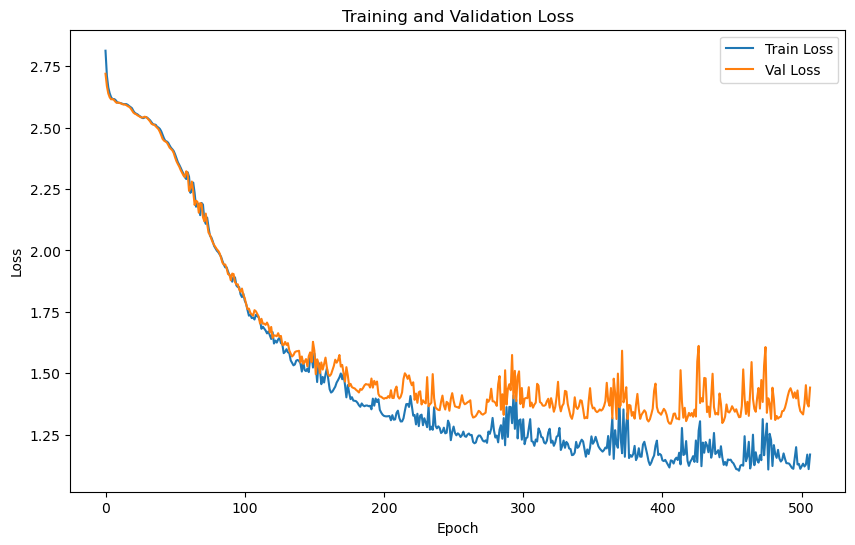

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 1.5569 | Test Accuracy: 32.59%


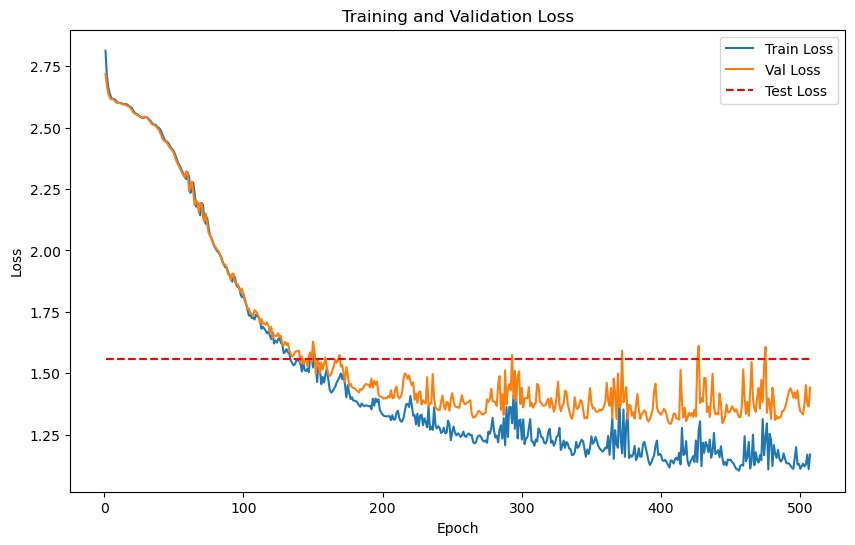

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 3108 samples with 64 features each
LOG: Labels shape: (3108,)


Train embeddings shape: (70, 64), 
Train labels shape: (70,)


Val embeddings shape: (70, 64), 
Val labels shape: (70,)


Test embeddings shape: (3108, 64), 
Test labels shape: (3108,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5, 9: 5, 10: 5, 11: 5, 12: 5, 13: 5}
Training batch size: 70


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training
    Batch [1/1], Train Loss: 7.6244
Epoch [1/2000], Avg Train Loss: 7.6244
Epoch [1/2000], Avg Val Loss: 3.4432
Validation loss improved from inf to 3.4432. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 8.1034
Epoch [2/2000], Avg Train Loss: 8.1034
Epoch [2/2000], Avg Val Loss: 3.4278
Validation loss improved from 3.4432 to 3.4278. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 7.9381
Epoch [3/2000], Avg Train Loss: 7.9381
Epoch [3/2000], Avg Val Loss: 3.4130
Validation loss improved from 3.4278 to 3.4130. Saving model...

LOG: Epoch [4/2000] - Training


    Batch [1/1], Train Loss: 7.6682
Epoch [4/2000], Avg Train Loss: 7.6682
Epoch [4/2000], Avg Val Loss: 3.3991
Validation loss improved from 3.4130 to 3.3991. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 7.5717
Epoch [5/2000], Avg Train Loss: 7.5717
Epoch [5/2000], Avg Val Loss: 3.3860
Validation loss improved from 3.3991 to 3.3860. Saving model...

LOG: Epoch [6/2000] - Training
    Batch [1/1], Train Loss: 7.4758
Epoch [6/2000], Avg Train Loss: 7.4758
Epoch [6/2000], Avg Val Loss: 3.3733
Validation loss improved from 3.3860 to 3.3733. Saving model...

LOG: Epoch [7/2000] - Training
    Batch [1/1], Train Loss: 7.4006
Epoch [7/2000], Avg Train Loss: 7.4006
Epoch [7/2000], Avg Val Loss: 3.3610
Validation loss improved from 3.3733 to 3.3610. Saving model...

LOG: Epoch [8/2000] - Training
    Batch [1/1], Train Loss: 7.4230
Epoch [8/2000], Avg Train Loss: 7.4230
Epoch [8/2000], Avg Val Loss: 3.3494
Validation loss improved from 3.3610 to 3.3494. Saving m

    Batch [1/1], Train Loss: 7.0147
Epoch [17/2000], Avg Train Loss: 7.0147
Epoch [17/2000], Avg Val Loss: 3.2681
Validation loss improved from 3.2753 to 3.2681. Saving model...

LOG: Epoch [18/2000] - Training
    Batch [1/1], Train Loss: 6.9886
Epoch [18/2000], Avg Train Loss: 6.9886
Epoch [18/2000], Avg Val Loss: 3.2613
Validation loss improved from 3.2681 to 3.2613. Saving model...

LOG: Epoch [19/2000] - Training
    Batch [1/1], Train Loss: 7.1982
Epoch [19/2000], Avg Train Loss: 7.1982
Epoch [19/2000], Avg Val Loss: 3.2550
Validation loss improved from 3.2613 to 3.2550. Saving model...

LOG: Epoch [20/2000] - Training
    Batch [1/1], Train Loss: 6.9872
Epoch [20/2000], Avg Train Loss: 6.9872
Epoch [20/2000], Avg Val Loss: 3.2489
Validation loss improved from 3.2550 to 3.2489. Saving model...

LOG: Epoch [21/2000] - Training
    Batch [1/1], Train Loss: 6.7433
Epoch [21/2000], Avg Train Loss: 6.7433
Epoch [21/2000], Avg Val Loss: 3.2431
Validation loss improved from 3.2489 to 3.

    Batch [1/1], Train Loss: 6.2907
Epoch [28/2000], Avg Train Loss: 6.2907
Epoch [28/2000], Avg Val Loss: 3.2110
Validation loss improved from 3.2148 to 3.2110. Saving model...

LOG: Epoch [29/2000] - Training
    Batch [1/1], Train Loss: 5.7866
Epoch [29/2000], Avg Train Loss: 5.7866
Epoch [29/2000], Avg Val Loss: 3.2076
Validation loss improved from 3.2110 to 3.2076. Saving model...

LOG: Epoch [30/2000] - Training
    Batch [1/1], Train Loss: 6.1301
Epoch [30/2000], Avg Train Loss: 6.1301
Epoch [30/2000], Avg Val Loss: 3.2045
Validation loss improved from 3.2076 to 3.2045. Saving model...

LOG: Epoch [31/2000] - Training
    Batch [1/1], Train Loss: 6.1118
Epoch [31/2000], Avg Train Loss: 6.1118
Epoch [31/2000], Avg Val Loss: 3.2016
Validation loss improved from 3.2045 to 3.2016. Saving model...

LOG: Epoch [32/2000] - Training
    Batch [1/1], Train Loss: 6.0353
Epoch [32/2000], Avg Train Loss: 6.0353
Epoch [32/2000], Avg Val Loss: 3.1988
Validation loss improved from 3.2016 to 3.

    Batch [1/1], Train Loss: 5.3374
Epoch [48/2000], Avg Train Loss: 5.3374
Epoch [48/2000], Avg Val Loss: 3.1748
Validation loss improved from 3.1755 to 3.1748. Saving model...

LOG: Epoch [49/2000] - Training
    Batch [1/1], Train Loss: 5.4296
Epoch [49/2000], Avg Train Loss: 5.4296
Epoch [49/2000], Avg Val Loss: 3.1743
Validation loss improved from 3.1748 to 3.1743. Saving model...

LOG: Epoch [50/2000] - Training
    Batch [1/1], Train Loss: 5.1873
Epoch [50/2000], Avg Train Loss: 5.1873
Epoch [50/2000], Avg Val Loss: 3.1738
Validation loss improved from 3.1743 to 3.1738. Saving model...

LOG: Epoch [51/2000] - Training
    Batch [1/1], Train Loss: 5.1113
Epoch [51/2000], Avg Train Loss: 5.1113
Epoch [51/2000], Avg Val Loss: 3.1733
Validation loss improved from 3.1738 to 3.1733. Saving model...

LOG: Epoch [52/2000] - Training
    Batch [1/1], Train Loss: 5.3865
Epoch [52/2000], Avg Train Loss: 5.3865
Epoch [52/2000], Avg Val Loss: 3.1730
Validation loss improved from 3.1733 to 3.

    Batch [1/1], Train Loss: 4.7547
Epoch [65/2000], Avg Train Loss: 4.7547
Epoch [65/2000], Avg Val Loss: 3.1739
Validation loss did not improve. Patience: 8/100

LOG: Epoch [66/2000] - Training
    Batch [1/1], Train Loss: 4.8342
Epoch [66/2000], Avg Train Loss: 4.8342
Epoch [66/2000], Avg Val Loss: 3.1742
Validation loss did not improve. Patience: 9/100

LOG: Epoch [67/2000] - Training
    Batch [1/1], Train Loss: 4.8770
Epoch [67/2000], Avg Train Loss: 4.8770
Epoch [67/2000], Avg Val Loss: 3.1746
Validation loss did not improve. Patience: 10/100

LOG: Epoch [68/2000] - Training
    Batch [1/1], Train Loss: 4.7462
Epoch [68/2000], Avg Train Loss: 4.7462
Epoch [68/2000], Avg Val Loss: 3.1750
Validation loss did not improve. Patience: 11/100

LOG: Epoch [69/2000] - Training
    Batch [1/1], Train Loss: 4.9422
Epoch [69/2000], Avg Train Loss: 4.9422
Epoch [69/2000], Avg Val Loss: 3.1755
Validation loss did not improve. Patience: 12/100

LOG: Epoch [70/2000] - Training
    Batch [1/1], 

    Batch [1/1], Train Loss: 4.7756
Epoch [74/2000], Avg Train Loss: 4.7756
Epoch [74/2000], Avg Val Loss: 3.1778
Validation loss did not improve. Patience: 17/100

LOG: Epoch [75/2000] - Training
    Batch [1/1], Train Loss: 4.7634
Epoch [75/2000], Avg Train Loss: 4.7634
Epoch [75/2000], Avg Val Loss: 3.1784
Validation loss did not improve. Patience: 18/100

LOG: Epoch [76/2000] - Training
    Batch [1/1], Train Loss: 4.6027
Epoch [76/2000], Avg Train Loss: 4.6027
Epoch [76/2000], Avg Val Loss: 3.1790
Validation loss did not improve. Patience: 19/100

LOG: Epoch [77/2000] - Training
    Batch [1/1], Train Loss: 4.5304
Epoch [77/2000], Avg Train Loss: 4.5304
Epoch [77/2000], Avg Val Loss: 3.1796
Validation loss did not improve. Patience: 20/100

LOG: Epoch [78/2000] - Training
    Batch [1/1], Train Loss: 4.6683
Epoch [78/2000], Avg Train Loss: 4.6683
Epoch [78/2000], Avg Val Loss: 3.1802
Validation loss did not improve. Patience: 21/100

LOG: Epoch [79/2000] - Training
    Batch [1/1]

    Batch [1/1], Train Loss: 4.4683
Epoch [95/2000], Avg Train Loss: 4.4683
Epoch [95/2000], Avg Val Loss: 3.1915
Validation loss did not improve. Patience: 38/100

LOG: Epoch [96/2000] - Training
    Batch [1/1], Train Loss: 4.2939
Epoch [96/2000], Avg Train Loss: 4.2939
Epoch [96/2000], Avg Val Loss: 3.1922
Validation loss did not improve. Patience: 39/100

LOG: Epoch [97/2000] - Training
    Batch [1/1], Train Loss: 4.2931
Epoch [97/2000], Avg Train Loss: 4.2931
Epoch [97/2000], Avg Val Loss: 3.1929
Validation loss did not improve. Patience: 40/100

LOG: Epoch [98/2000] - Training
    Batch [1/1], Train Loss: 4.1156
Epoch [98/2000], Avg Train Loss: 4.1156
Epoch [98/2000], Avg Val Loss: 3.1935
Validation loss did not improve. Patience: 41/100

LOG: Epoch [99/2000] - Training
    Batch [1/1], Train Loss: 4.2426
Epoch [99/2000], Avg Train Loss: 4.2426
Epoch [99/2000], Avg Val Loss: 3.1941
Validation loss did not improve. Patience: 42/100

LOG: Epoch [100/2000] - Training
    Batch [1/1

    Batch [1/1], Train Loss: 4.1219
Epoch [110/2000], Avg Train Loss: 4.1219
Epoch [110/2000], Avg Val Loss: 3.2005
Validation loss did not improve. Patience: 53/100

LOG: Epoch [111/2000] - Training
    Batch [1/1], Train Loss: 4.1264
Epoch [111/2000], Avg Train Loss: 4.1264
Epoch [111/2000], Avg Val Loss: 3.2010
Validation loss did not improve. Patience: 54/100

LOG: Epoch [112/2000] - Training
    Batch [1/1], Train Loss: 4.2456
Epoch [112/2000], Avg Train Loss: 4.2456
Epoch [112/2000], Avg Val Loss: 3.2015
Validation loss did not improve. Patience: 55/100

LOG: Epoch [113/2000] - Training
    Batch [1/1], Train Loss: 3.9525
Epoch [113/2000], Avg Train Loss: 3.9525
Epoch [113/2000], Avg Val Loss: 3.2020
Validation loss did not improve. Patience: 56/100

LOG: Epoch [114/2000] - Training
    Batch [1/1], Train Loss: 4.0043
Epoch [114/2000], Avg Train Loss: 4.0043
Epoch [114/2000], Avg Val Loss: 3.2024
Validation loss did not improve. Patience: 57/100

LOG: Epoch [115/2000] - Training


    Batch [1/1], Train Loss: 4.0387
Epoch [120/2000], Avg Train Loss: 4.0387
Epoch [120/2000], Avg Val Loss: 3.2047
Validation loss did not improve. Patience: 63/100

LOG: Epoch [121/2000] - Training
    Batch [1/1], Train Loss: 4.1926
Epoch [121/2000], Avg Train Loss: 4.1926
Epoch [121/2000], Avg Val Loss: 3.2051
Validation loss did not improve. Patience: 64/100

LOG: Epoch [122/2000] - Training
    Batch [1/1], Train Loss: 4.0155
Epoch [122/2000], Avg Train Loss: 4.0155
Epoch [122/2000], Avg Val Loss: 3.2054
Validation loss did not improve. Patience: 65/100

LOG: Epoch [123/2000] - Training
    Batch [1/1], Train Loss: 4.0281
Epoch [123/2000], Avg Train Loss: 4.0281
Epoch [123/2000], Avg Val Loss: 3.2057
Validation loss did not improve. Patience: 66/100

LOG: Epoch [124/2000] - Training
    Batch [1/1], Train Loss: 3.9631
Epoch [124/2000], Avg Train Loss: 3.9631
Epoch [124/2000], Avg Val Loss: 3.2060
Validation loss did not improve. Patience: 67/100

LOG: Epoch [125/2000] - Training


    Batch [1/1], Train Loss: 3.8458
Epoch [144/2000], Avg Train Loss: 3.8458
Epoch [144/2000], Avg Val Loss: 3.2109
Validation loss did not improve. Patience: 87/100

LOG: Epoch [145/2000] - Training
    Batch [1/1], Train Loss: 3.9277
Epoch [145/2000], Avg Train Loss: 3.9277
Epoch [145/2000], Avg Val Loss: 3.2110
Validation loss did not improve. Patience: 88/100

LOG: Epoch [146/2000] - Training
    Batch [1/1], Train Loss: 4.0433
Epoch [146/2000], Avg Train Loss: 4.0433
Epoch [146/2000], Avg Val Loss: 3.2112
Validation loss did not improve. Patience: 89/100

LOG: Epoch [147/2000] - Training
    Batch [1/1], Train Loss: 3.8247
Epoch [147/2000], Avg Train Loss: 3.8247
Epoch [147/2000], Avg Val Loss: 3.2114
Validation loss did not improve. Patience: 90/100

LOG: Epoch [148/2000] - Training
    Batch [1/1], Train Loss: 3.9875
Epoch [148/2000], Avg Train Loss: 3.9875
Epoch [148/2000], Avg Val Loss: 3.2116
Validation loss did not improve. Patience: 91/100

LOG: Epoch [149/2000] - Training


Epoch [155/2000], Avg Val Loss: 3.2124
Validation loss did not improve. Patience: 98/100

LOG: Epoch [156/2000] - Training
    Batch [1/1], Train Loss: 3.7793
Epoch [156/2000], Avg Train Loss: 3.7793
Epoch [156/2000], Avg Val Loss: 3.2125
Validation loss did not improve. Patience: 99/100

LOG: Epoch [157/2000] - Training
    Batch [1/1], Train Loss: 3.8617
Epoch [157/2000], Avg Train Loss: 3.8617
Epoch [157/2000], Avg Val Loss: 3.2126
Validation loss did not improve. Patience: 100/100
Early stopping triggered at epoch 157. No improvement for 100 epochs.


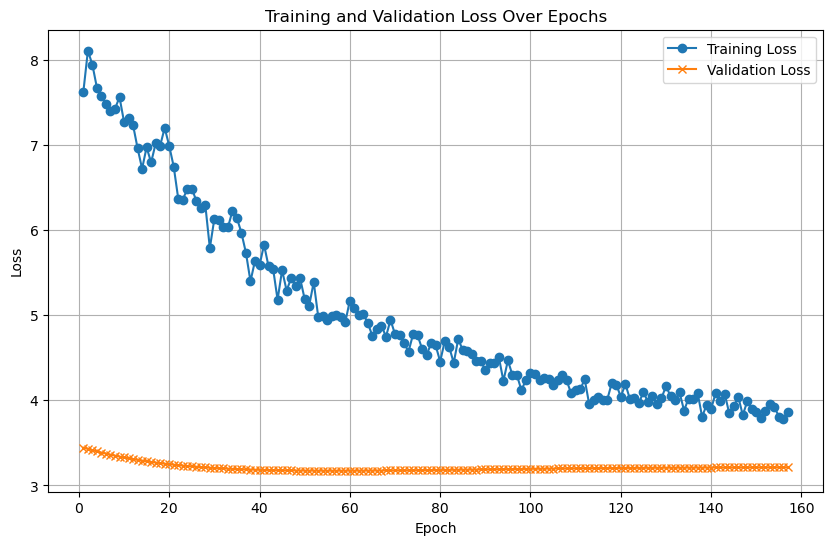

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/13], Loss: 4.5795



Test Loss: 4.7784


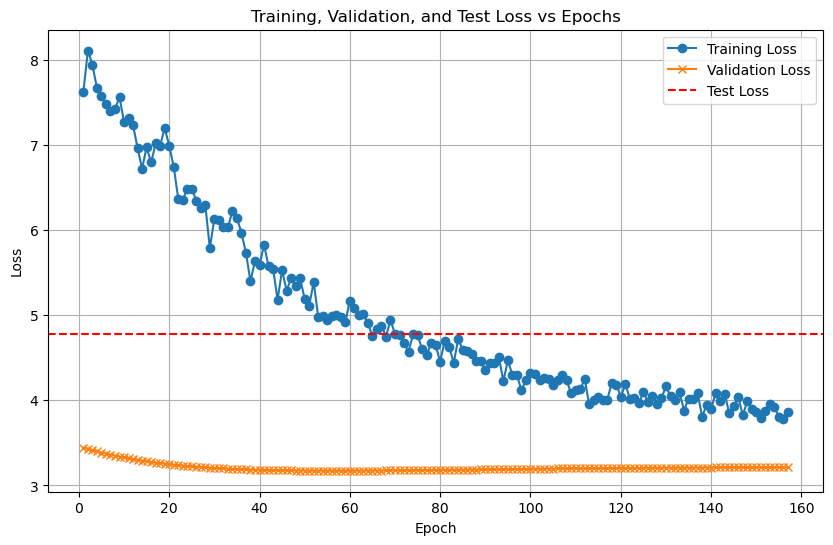

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/13 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (70, 128)
Train labels shape: (70,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (3108, 128)
Test labels shape: (3108,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 70.00%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.71      1.00      0.83         5
           2       0.40      0.40      0.40         5
           3       0.75      0.60      0.67         5
           4       0.50      0.20      0.29         5
           5       0.00      0.00      0.00         5
           6       0.80      0.80      0.80         5
           7       1.00      1.00      1.00         5
           8       0.50      1.00      0.67         5
           9       0.57      0.80      0.67         5
          10       0.75      0.60      0.67         5
          11       0.83      1.00      0.91         5
          12       0.50      0.60      0.55         5
          13       1.0

C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (70, 128)
Train labels shape: (70,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (3108, 128)
Test labels shape: (3108,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.5679  |  Val Loss: 2.5701
Validation loss improved from inf to 2.5701.
[Epoch 2/1000] Train Loss: 2.5607  |  Val Loss: 2.5654
Validation loss improved from 2.5701 to 2.5654.
[Epoch 3/1000] Train Loss: 2.5553  |  Val Loss: 2.5609
Validation loss improved from 2.5654 to 2.5609.
[Epoch 4/1000] Train Loss: 2.5504  |  Val Loss: 2.5563
Validation loss improved from 2.5609 to 2.5563.
[Epoch 5/1000] Train Loss: 2.5453  |  Val Loss: 2.5516
Validation loss improved from 2.5563 to 2.5516.
[Epoch 6/1000] Train Loss: 2.5404  |  Val Loss: 2.5465
Validation loss improved from 2.5516 to 2.5465.
[Epoch 7/1000] Train Loss: 2.5355  |  Val Loss: 2.5415
Validation loss improved from 2.5465 to 2.5415.
[Epoch 8/1000] Train Loss: 2.5304  |  Val Loss: 2.5368
Validation loss improved from 2.5415 to 2.5368.
[Epoch 9/1000] Train Loss: 2.5255  |  Val Loss: 2.5322
Validation loss improved from 2.5368 to 2.5322.
[Epoch 10/1000] Train Loss: 2.5207  |  Val Loss: 2.5278
Validation loss impr

[Epoch 27/1000] Train Loss: 2.4591  |  Val Loss: 2.4711
Validation loss improved from 2.4744 to 2.4711.
[Epoch 28/1000] Train Loss: 2.4550  |  Val Loss: 2.4676
Validation loss improved from 2.4711 to 2.4676.
[Epoch 29/1000] Train Loss: 2.4510  |  Val Loss: 2.4640
Validation loss improved from 2.4676 to 2.4640.
[Epoch 30/1000] Train Loss: 2.4470  |  Val Loss: 2.4603
Validation loss improved from 2.4640 to 2.4603.
[Epoch 31/1000] Train Loss: 2.4429  |  Val Loss: 2.4567
Validation loss improved from 2.4603 to 2.4567.
[Epoch 32/1000] Train Loss: 2.4385  |  Val Loss: 2.4531
Validation loss improved from 2.4567 to 2.4531.
[Epoch 33/1000] Train Loss: 2.4345  |  Val Loss: 2.4495
Validation loss improved from 2.4531 to 2.4495.
[Epoch 34/1000] Train Loss: 2.4305  |  Val Loss: 2.4459
Validation loss improved from 2.4495 to 2.4459.
[Epoch 35/1000] Train Loss: 2.4265  |  Val Loss: 2.4424
Validation loss improved from 2.4459 to 2.4424.
[Epoch 36/1000] Train Loss: 2.4226  |  Val Loss: 2.4390
Validati

[Epoch 40/1000] Train Loss: 2.4076  |  Val Loss: 2.4253
Validation loss improved from 2.4287 to 2.4253.
[Epoch 41/1000] Train Loss: 2.4041  |  Val Loss: 2.4218
Validation loss improved from 2.4253 to 2.4218.
[Epoch 42/1000] Train Loss: 2.4003  |  Val Loss: 2.4185
Validation loss improved from 2.4218 to 2.4185.
[Epoch 43/1000] Train Loss: 2.3969  |  Val Loss: 2.4153
Validation loss improved from 2.4185 to 2.4153.
[Epoch 44/1000] Train Loss: 2.3932  |  Val Loss: 2.4123
Validation loss improved from 2.4153 to 2.4123.
[Epoch 45/1000] Train Loss: 2.3897  |  Val Loss: 2.4094
Validation loss improved from 2.4123 to 2.4094.
[Epoch 46/1000] Train Loss: 2.3862  |  Val Loss: 2.4065
Validation loss improved from 2.4094 to 2.4065.
[Epoch 47/1000] Train Loss: 2.3825  |  Val Loss: 2.4036
Validation loss improved from 2.4065 to 2.4036.
[Epoch 48/1000] Train Loss: 2.3787  |  Val Loss: 2.4007
Validation loss improved from 2.4036 to 2.4007.
[Epoch 49/1000] Train Loss: 2.3750  |  Val Loss: 2.3976
Validati

[Epoch 70/1000] Train Loss: 2.2931  |  Val Loss: 2.3307
Validation loss improved from 2.3341 to 2.3307.
[Epoch 71/1000] Train Loss: 2.2894  |  Val Loss: 2.3274
Validation loss improved from 2.3307 to 2.3274.
[Epoch 72/1000] Train Loss: 2.2856  |  Val Loss: 2.3238
Validation loss improved from 2.3274 to 2.3238.
[Epoch 73/1000] Train Loss: 2.2818  |  Val Loss: 2.3203
Validation loss improved from 2.3238 to 2.3203.
[Epoch 74/1000] Train Loss: 2.2778  |  Val Loss: 2.3168
Validation loss improved from 2.3203 to 2.3168.
[Epoch 75/1000] Train Loss: 2.2741  |  Val Loss: 2.3132
Validation loss improved from 2.3168 to 2.3132.
[Epoch 76/1000] Train Loss: 2.2699  |  Val Loss: 2.3095
Validation loss improved from 2.3132 to 2.3095.
[Epoch 77/1000] Train Loss: 2.2660  |  Val Loss: 2.3057
Validation loss improved from 2.3095 to 2.3057.
[Epoch 78/1000] Train Loss: 2.2621  |  Val Loss: 2.3021
Validation loss improved from 2.3057 to 2.3021.
[Epoch 79/1000] Train Loss: 2.2583  |  Val Loss: 2.2986
Validati

[Epoch 83/1000] Train Loss: 2.2421  |  Val Loss: 2.2841
Validation loss improved from 2.2881 to 2.2841.
[Epoch 84/1000] Train Loss: 2.2378  |  Val Loss: 2.2801
Validation loss improved from 2.2841 to 2.2801.
[Epoch 85/1000] Train Loss: 2.2338  |  Val Loss: 2.2762
Validation loss improved from 2.2801 to 2.2762.
[Epoch 86/1000] Train Loss: 2.2293  |  Val Loss: 2.2724
Validation loss improved from 2.2762 to 2.2724.
[Epoch 87/1000] Train Loss: 2.2251  |  Val Loss: 2.2684
Validation loss improved from 2.2724 to 2.2684.
[Epoch 88/1000] Train Loss: 2.2208  |  Val Loss: 2.2643
Validation loss improved from 2.2684 to 2.2643.
[Epoch 89/1000] Train Loss: 2.2165  |  Val Loss: 2.2601
Validation loss improved from 2.2643 to 2.2601.
[Epoch 90/1000] Train Loss: 2.2123  |  Val Loss: 2.2562
Validation loss improved from 2.2601 to 2.2562.
[Epoch 91/1000] Train Loss: 2.2081  |  Val Loss: 2.2525
Validation loss improved from 2.2562 to 2.2525.
[Epoch 92/1000] Train Loss: 2.2043  |  Val Loss: 2.2489
Validati

[Epoch 113/1000] Train Loss: 2.1224  |  Val Loss: 2.1703
Validation loss improved from 2.1741 to 2.1703.
[Epoch 114/1000] Train Loss: 2.1184  |  Val Loss: 2.1666
Validation loss improved from 2.1703 to 2.1666.
[Epoch 115/1000] Train Loss: 2.1145  |  Val Loss: 2.1629
Validation loss improved from 2.1666 to 2.1629.
[Epoch 116/1000] Train Loss: 2.1106  |  Val Loss: 2.1595
Validation loss improved from 2.1629 to 2.1595.
[Epoch 117/1000] Train Loss: 2.1072  |  Val Loss: 2.1563
Validation loss improved from 2.1595 to 2.1563.
[Epoch 118/1000] Train Loss: 2.1038  |  Val Loss: 2.1531
Validation loss improved from 2.1563 to 2.1531.
[Epoch 119/1000] Train Loss: 2.1002  |  Val Loss: 2.1498
Validation loss improved from 2.1531 to 2.1498.
[Epoch 120/1000] Train Loss: 2.0966  |  Val Loss: 2.1463
Validation loss improved from 2.1498 to 2.1463.
[Epoch 121/1000] Train Loss: 2.0929  |  Val Loss: 2.1428
Validation loss improved from 2.1463 to 2.1428.
[Epoch 122/1000] Train Loss: 2.0891  |  Val Loss: 2.139

[Epoch 125/1000] Train Loss: 2.0778  |  Val Loss: 2.1277
Validation loss improved from 2.1314 to 2.1277.
[Epoch 126/1000] Train Loss: 2.0740  |  Val Loss: 2.1239
Validation loss improved from 2.1277 to 2.1239.
[Epoch 127/1000] Train Loss: 2.0704  |  Val Loss: 2.1202
Validation loss improved from 2.1239 to 2.1202.
[Epoch 128/1000] Train Loss: 2.0666  |  Val Loss: 2.1167
Validation loss improved from 2.1202 to 2.1167.
[Epoch 129/1000] Train Loss: 2.0629  |  Val Loss: 2.1133
Validation loss improved from 2.1167 to 2.1133.
[Epoch 130/1000] Train Loss: 2.0594  |  Val Loss: 2.1100
Validation loss improved from 2.1133 to 2.1100.
[Epoch 131/1000] Train Loss: 2.0556  |  Val Loss: 2.1067
Validation loss improved from 2.1100 to 2.1067.
[Epoch 132/1000] Train Loss: 2.0519  |  Val Loss: 2.1035
Validation loss improved from 2.1067 to 2.1035.
[Epoch 133/1000] Train Loss: 2.0484  |  Val Loss: 2.1003
Validation loss improved from 2.1035 to 2.1003.
[Epoch 134/1000] Train Loss: 2.0447  |  Val Loss: 2.096

[Epoch 157/1000] Train Loss: 1.9595  |  Val Loss: 2.0195
Validation loss improved from 2.0227 to 2.0195.
[Epoch 158/1000] Train Loss: 1.9554  |  Val Loss: 2.0163
Validation loss improved from 2.0195 to 2.0163.
[Epoch 159/1000] Train Loss: 1.9513  |  Val Loss: 2.0131
Validation loss improved from 2.0163 to 2.0131.
[Epoch 160/1000] Train Loss: 1.9477  |  Val Loss: 2.0101
Validation loss improved from 2.0131 to 2.0101.
[Epoch 161/1000] Train Loss: 1.9441  |  Val Loss: 2.0072
Validation loss improved from 2.0101 to 2.0072.
[Epoch 162/1000] Train Loss: 1.9407  |  Val Loss: 2.0044
Validation loss improved from 2.0072 to 2.0044.
[Epoch 163/1000] Train Loss: 1.9370  |  Val Loss: 2.0016
Validation loss improved from 2.0044 to 2.0016.


[Epoch 164/1000] Train Loss: 1.9332  |  Val Loss: 1.9987
Validation loss improved from 2.0016 to 1.9987.
[Epoch 165/1000] Train Loss: 1.9296  |  Val Loss: 1.9959
Validation loss improved from 1.9987 to 1.9959.
[Epoch 166/1000] Train Loss: 1.9262  |  Val Loss: 1.9934
Validation loss improved from 1.9959 to 1.9934.
[Epoch 167/1000] Train Loss: 1.9232  |  Val Loss: 1.9908
Validation loss improved from 1.9934 to 1.9908.
[Epoch 168/1000] Train Loss: 1.9199  |  Val Loss: 1.9877
Validation loss improved from 1.9908 to 1.9877.
[Epoch 169/1000] Train Loss: 1.9163  |  Val Loss: 1.9842
Validation loss improved from 1.9877 to 1.9842.
[Epoch 170/1000] Train Loss: 1.9126  |  Val Loss: 1.9805
Validation loss improved from 1.9842 to 1.9805.
[Epoch 171/1000] Train Loss: 1.9089  |  Val Loss: 1.9769
Validation loss improved from 1.9805 to 1.9769.
[Epoch 172/1000] Train Loss: 1.9053  |  Val Loss: 1.9732
Validation loss improved from 1.9769 to 1.9732.
[Epoch 173/1000] Train Loss: 1.9013  |  Val Loss: 1.969

[Epoch 198/1000] Train Loss: 1.8240  |  Val Loss: 1.9007
Validation loss improved from 1.9039 to 1.9007.


[Epoch 199/1000] Train Loss: 1.8210  |  Val Loss: 1.8978
Validation loss improved from 1.9007 to 1.8978.
[Epoch 200/1000] Train Loss: 1.8182  |  Val Loss: 1.8949
Validation loss improved from 1.8978 to 1.8949.
[Epoch 201/1000] Train Loss: 1.8152  |  Val Loss: 1.8920
Validation loss improved from 1.8949 to 1.8920.
[Epoch 202/1000] Train Loss: 1.8117  |  Val Loss: 1.8893
Validation loss improved from 1.8920 to 1.8893.
[Epoch 203/1000] Train Loss: 1.8085  |  Val Loss: 1.8871
Validation loss improved from 1.8893 to 1.8871.
[Epoch 204/1000] Train Loss: 1.8054  |  Val Loss: 1.8844
Validation loss improved from 1.8871 to 1.8844.
[Epoch 205/1000] Train Loss: 1.8019  |  Val Loss: 1.8817
Validation loss improved from 1.8844 to 1.8817.
[Epoch 206/1000] Train Loss: 1.7988  |  Val Loss: 1.8793
Validation loss improved from 1.8817 to 1.8793.
[Epoch 207/1000] Train Loss: 1.7961  |  Val Loss: 1.8767
Validation loss improved from 1.8793 to 1.8767.
[Epoch 208/1000] Train Loss: 1.7934  |  Val Loss: 1.874

[Epoch 239/1000] Train Loss: 1.7131  |  Val Loss: 1.8062
Validation loss improved from 1.8088 to 1.8062.
[Epoch 240/1000] Train Loss: 1.7108  |  Val Loss: 1.8036
Validation loss improved from 1.8062 to 1.8036.
[Epoch 241/1000] Train Loss: 1.7083  |  Val Loss: 1.8011
Validation loss improved from 1.8036 to 1.8011.
[Epoch 242/1000] Train Loss: 1.7056  |  Val Loss: 1.7986
Validation loss improved from 1.8011 to 1.7986.
[Epoch 243/1000] Train Loss: 1.7030  |  Val Loss: 1.7966
Validation loss improved from 1.7986 to 1.7966.
[Epoch 244/1000] Train Loss: 1.7004  |  Val Loss: 1.7951
Validation loss improved from 1.7966 to 1.7951.
[Epoch 245/1000] Train Loss: 1.6978  |  Val Loss: 1.7939
Validation loss improved from 1.7951 to 1.7939.
[Epoch 246/1000] Train Loss: 1.6956  |  Val Loss: 1.7929
Validation loss improved from 1.7939 to 1.7929.
[Epoch 247/1000] Train Loss: 1.6936  |  Val Loss: 1.7919
Validation loss improved from 1.7929 to 1.7919.
[Epoch 248/1000] Train Loss: 1.6910  |  Val Loss: 1.790

[Epoch 281/1000] Train Loss: 1.6157  |  Val Loss: 1.7278
Validation loss improved from 1.7293 to 1.7278.
[Epoch 282/1000] Train Loss: 1.6135  |  Val Loss: 1.7261
Validation loss improved from 1.7278 to 1.7261.
[Epoch 283/1000] Train Loss: 1.6112  |  Val Loss: 1.7241
Validation loss improved from 1.7261 to 1.7241.
[Epoch 284/1000] Train Loss: 1.6085  |  Val Loss: 1.7226
Validation loss improved from 1.7241 to 1.7226.
[Epoch 285/1000] Train Loss: 1.6061  |  Val Loss: 1.7212
Validation loss improved from 1.7226 to 1.7212.
[Epoch 286/1000] Train Loss: 1.6035  |  Val Loss: 1.7199
Validation loss improved from 1.7212 to 1.7199.
[Epoch 287/1000] Train Loss: 1.6011  |  Val Loss: 1.7188
Validation loss improved from 1.7199 to 1.7188.
[Epoch 288/1000] Train Loss: 1.5985  |  Val Loss: 1.7177
Validation loss improved from 1.7188 to 1.7177.
[Epoch 289/1000] Train Loss: 1.5964  |  Val Loss: 1.7164
Validation loss improved from 1.7177 to 1.7164.
[Epoch 290/1000] Train Loss: 1.5942  |  Val Loss: 1.714

[Epoch 319/1000] Train Loss: 1.5332  |  Val Loss: 1.6642
Validation loss improved from 1.6662 to 1.6642.
[Epoch 320/1000] Train Loss: 1.5310  |  Val Loss: 1.6623
Validation loss improved from 1.6642 to 1.6623.
[Epoch 321/1000] Train Loss: 1.5287  |  Val Loss: 1.6602
Validation loss improved from 1.6623 to 1.6602.
[Epoch 322/1000] Train Loss: 1.5265  |  Val Loss: 1.6580
Validation loss improved from 1.6602 to 1.6580.
[Epoch 323/1000] Train Loss: 1.5241  |  Val Loss: 1.6558
Validation loss improved from 1.6580 to 1.6558.
[Epoch 324/1000] Train Loss: 1.5221  |  Val Loss: 1.6540
Validation loss improved from 1.6558 to 1.6540.
[Epoch 325/1000] Train Loss: 1.5197  |  Val Loss: 1.6525
Validation loss improved from 1.6540 to 1.6525.
[Epoch 326/1000] Train Loss: 1.5178  |  Val Loss: 1.6508
Validation loss improved from 1.6525 to 1.6508.
[Epoch 327/1000] Train Loss: 1.5157  |  Val Loss: 1.6493
Validation loss improved from 1.6508 to 1.6493.
[Epoch 328/1000] Train Loss: 1.5141  |  Val Loss: 1.648

[Epoch 362/1000] Train Loss: 1.4514  |  Val Loss: 1.5987
Validation loss improved from 1.5997 to 1.5987.
[Epoch 363/1000] Train Loss: 1.4497  |  Val Loss: 1.5977
Validation loss improved from 1.5987 to 1.5977.
[Epoch 364/1000] Train Loss: 1.4480  |  Val Loss: 1.5970
Validation loss improved from 1.5977 to 1.5970.
[Epoch 365/1000] Train Loss: 1.4460  |  Val Loss: 1.5964
Validation loss improved from 1.5970 to 1.5964.
[Epoch 366/1000] Train Loss: 1.4443  |  Val Loss: 1.5958
Validation loss improved from 1.5964 to 1.5958.
[Epoch 367/1000] Train Loss: 1.4426  |  Val Loss: 1.5951
Validation loss improved from 1.5958 to 1.5951.
[Epoch 368/1000] Train Loss: 1.4405  |  Val Loss: 1.5943
Validation loss improved from 1.5951 to 1.5943.
[Epoch 369/1000] Train Loss: 1.4385  |  Val Loss: 1.5929
Validation loss improved from 1.5943 to 1.5929.
[Epoch 370/1000] Train Loss: 1.4367  |  Val Loss: 1.5913
Validation loss improved from 1.5929 to 1.5913.
[Epoch 371/1000] Train Loss: 1.4350  |  Val Loss: 1.589

[Epoch 403/1000] Train Loss: 1.3768  |  Val Loss: 1.5485
Validation loss improved from 1.5509 to 1.5485.
[Epoch 404/1000] Train Loss: 1.3747  |  Val Loss: 1.5459
Validation loss improved from 1.5485 to 1.5459.
[Epoch 405/1000] Train Loss: 1.3727  |  Val Loss: 1.5435
Validation loss improved from 1.5459 to 1.5435.
[Epoch 406/1000] Train Loss: 1.3705  |  Val Loss: 1.5412
Validation loss improved from 1.5435 to 1.5412.
[Epoch 407/1000] Train Loss: 1.3682  |  Val Loss: 1.5394
Validation loss improved from 1.5412 to 1.5394.
[Epoch 408/1000] Train Loss: 1.3661  |  Val Loss: 1.5380
Validation loss improved from 1.5394 to 1.5380.
[Epoch 409/1000] Train Loss: 1.3637  |  Val Loss: 1.5370
Validation loss improved from 1.5380 to 1.5370.
[Epoch 410/1000] Train Loss: 1.3616  |  Val Loss: 1.5361
Validation loss improved from 1.5370 to 1.5361.
[Epoch 411/1000] Train Loss: 1.3596  |  Val Loss: 1.5354
Validation loss improved from 1.5361 to 1.5354.
[Epoch 412/1000] Train Loss: 1.3579  |  Val Loss: 1.535

[Epoch 445/1000] Train Loss: 1.3004  |  Val Loss: 1.4970
Validation loss improved from 1.4979 to 1.4970.
[Epoch 446/1000] Train Loss: 1.2984  |  Val Loss: 1.4962
Validation loss improved from 1.4970 to 1.4962.
[Epoch 447/1000] Train Loss: 1.2974  |  Val Loss: 1.4950
Validation loss improved from 1.4962 to 1.4950.
[Epoch 448/1000] Train Loss: 1.2962  |  Val Loss: 1.4933
Validation loss improved from 1.4950 to 1.4933.
[Epoch 449/1000] Train Loss: 1.2951  |  Val Loss: 1.4910
Validation loss improved from 1.4933 to 1.4910.
[Epoch 450/1000] Train Loss: 1.2939  |  Val Loss: 1.4884
Validation loss improved from 1.4910 to 1.4884.
[Epoch 451/1000] Train Loss: 1.2924  |  Val Loss: 1.4858
Validation loss improved from 1.4884 to 1.4858.
[Epoch 452/1000] Train Loss: 1.2906  |  Val Loss: 1.4838
Validation loss improved from 1.4858 to 1.4838.
[Epoch 453/1000] Train Loss: 1.2891  |  Val Loss: 1.4826
Validation loss improved from 1.4838 to 1.4826.
[Epoch 454/1000] Train Loss: 1.2878  |  Val Loss: 1.481

[Epoch 486/1000] Train Loss: 1.2310  |  Val Loss: 1.4370
Validation loss improved from 1.4396 to 1.4370.
[Epoch 487/1000] Train Loss: 1.2301  |  Val Loss: 1.4345
Validation loss improved from 1.4370 to 1.4345.
[Epoch 488/1000] Train Loss: 1.2288  |  Val Loss: 1.4324
Validation loss improved from 1.4345 to 1.4324.
[Epoch 489/1000] Train Loss: 1.2275  |  Val Loss: 1.4312
Validation loss improved from 1.4324 to 1.4312.
[Epoch 490/1000] Train Loss: 1.2266  |  Val Loss: 1.4305
Validation loss improved from 1.4312 to 1.4305.
[Epoch 491/1000] Train Loss: 1.2249  |  Val Loss: 1.4291
Validation loss improved from 1.4305 to 1.4291.
[Epoch 492/1000] Train Loss: 1.2228  |  Val Loss: 1.4273
Validation loss improved from 1.4291 to 1.4273.
[Epoch 493/1000] Train Loss: 1.2208  |  Val Loss: 1.4258
Validation loss improved from 1.4273 to 1.4258.
[Epoch 494/1000] Train Loss: 1.2188  |  Val Loss: 1.4246
Validation loss improved from 1.4258 to 1.4246.
[Epoch 495/1000] Train Loss: 1.2173  |  Val Loss: 1.423

[Epoch 531/1000] Train Loss: 1.1601  |  Val Loss: 1.3964
Validation loss improved from 1.3993 to 1.3964.
[Epoch 532/1000] Train Loss: 1.1579  |  Val Loss: 1.3936
Validation loss improved from 1.3964 to 1.3936.
[Epoch 533/1000] Train Loss: 1.1564  |  Val Loss: 1.3909
Validation loss improved from 1.3936 to 1.3909.
[Epoch 534/1000] Train Loss: 1.1546  |  Val Loss: 1.3886
Validation loss improved from 1.3909 to 1.3886.
[Epoch 535/1000] Train Loss: 1.1531  |  Val Loss: 1.3864
Validation loss improved from 1.3886 to 1.3864.
[Epoch 536/1000] Train Loss: 1.1516  |  Val Loss: 1.3847
Validation loss improved from 1.3864 to 1.3847.
[Epoch 537/1000] Train Loss: 1.1492  |  Val Loss: 1.3840
Validation loss improved from 1.3847 to 1.3840.
[Epoch 538/1000] Train Loss: 1.1478  |  Val Loss: 1.3842
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 539/1000] Train Loss: 1.1460  |  Val Loss: 1.3850
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 540/1000] Train Loss: 1.1447  |  Val

[Epoch 569/1000] Train Loss: 1.1006  |  Val Loss: 1.3633
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 570/1000] Train Loss: 1.0992  |  Val Loss: 1.3635
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 571/1000] Train Loss: 1.0982  |  Val Loss: 1.3630
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 572/1000] Train Loss: 1.0966  |  Val Loss: 1.3617
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 573/1000] Train Loss: 1.0945  |  Val Loss: 1.3594
Validation loss improved from 1.3599 to 1.3594.
[Epoch 574/1000] Train Loss: 1.0923  |  Val Loss: 1.3564
Validation loss improved from 1.3594 to 1.3564.
[Epoch 575/1000] Train Loss: 1.0897  |  Val Loss: 1.3537
Validation loss improved from 1.3564 to 1.3537.
[Epoch 576/1000] Train Loss: 1.0872  |  Val Loss: 1.3514
Validation loss improved from 1.3537 to 1.3514.
[Epoch 577/1000] Train Loss: 1.0858  |  Val Loss: 1.3489
Validation loss improved from 1.3514 to 1.3489.
[Epoch 578/1000] Train Loss: 1.

[Epoch 613/1000] Train Loss: 1.0304  |  Val Loss: 1.3095
Validation loss improved from 1.3140 to 1.3095.
[Epoch 614/1000] Train Loss: 1.0286  |  Val Loss: 1.3051
Validation loss improved from 1.3095 to 1.3051.
[Epoch 615/1000] Train Loss: 1.0269  |  Val Loss: 1.3007
Validation loss improved from 1.3051 to 1.3007.
[Epoch 616/1000] Train Loss: 1.0265  |  Val Loss: 1.2970
Validation loss improved from 1.3007 to 1.2970.
[Epoch 617/1000] Train Loss: 1.0248  |  Val Loss: 1.2948
Validation loss improved from 1.2970 to 1.2948.
[Epoch 618/1000] Train Loss: 1.0229  |  Val Loss: 1.2937
Validation loss improved from 1.2948 to 1.2937.
[Epoch 619/1000] Train Loss: 1.0216  |  Val Loss: 1.2936
Validation loss improved from 1.2937 to 1.2936.
[Epoch 620/1000] Train Loss: 1.0198  |  Val Loss: 1.2941
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 621/1000] Train Loss: 1.0186  |  Val Loss: 1.2944
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 622/1000] Train Loss: 1.0175  |  Val

[Epoch 653/1000] Train Loss: 0.9720  |  Val Loss: 1.2765
Validation loss improved from 1.2766 to 1.2765.
[Epoch 654/1000] Train Loss: 0.9707  |  Val Loss: 1.2768
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 655/1000] Train Loss: 0.9693  |  Val Loss: 1.2772
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 656/1000] Train Loss: 0.9684  |  Val Loss: 1.2774
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 657/1000] Train Loss: 0.9671  |  Val Loss: 1.2777
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 658/1000] Train Loss: 0.9659  |  Val Loss: 1.2774
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 659/1000] Train Loss: 0.9644  |  Val Loss: 1.2762
Validation loss improved from 1.2765 to 1.2762.
[Epoch 660/1000] Train Loss: 0.9633  |  Val Loss: 1.2748
Validation loss improved from 1.2762 to 1.2748.
[Epoch 661/1000] Train Loss: 0.9616  |  Val Loss: 1.2731
Validation loss improved from 1.2748 to 1.2731.
[Epoch 662/1000] Train Lo

[Epoch 692/1000] Train Loss: 0.9163  |  Val Loss: 1.2483
Validation loss improved from 1.2488 to 1.2483.
[Epoch 693/1000] Train Loss: 0.9147  |  Val Loss: 1.2472
Validation loss improved from 1.2483 to 1.2472.
[Epoch 694/1000] Train Loss: 0.9133  |  Val Loss: 1.2464
Validation loss improved from 1.2472 to 1.2464.
[Epoch 695/1000] Train Loss: 0.9122  |  Val Loss: 1.2458
Validation loss improved from 1.2464 to 1.2458.
[Epoch 696/1000] Train Loss: 0.9108  |  Val Loss: 1.2445
Validation loss improved from 1.2458 to 1.2445.
[Epoch 697/1000] Train Loss: 0.9092  |  Val Loss: 1.2423
Validation loss improved from 1.2445 to 1.2423.
[Epoch 698/1000] Train Loss: 0.9083  |  Val Loss: 1.2398
Validation loss improved from 1.2423 to 1.2398.
[Epoch 699/1000] Train Loss: 0.9070  |  Val Loss: 1.2374
Validation loss improved from 1.2398 to 1.2374.
[Epoch 700/1000] Train Loss: 0.9059  |  Val Loss: 1.2357
Validation loss improved from 1.2374 to 1.2357.
[Epoch 701/1000] Train Loss: 0.9042  |  Val Loss: 1.234

[Epoch 737/1000] Train Loss: 0.8565  |  Val Loss: 1.2220
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 738/1000] Train Loss: 0.8560  |  Val Loss: 1.2213
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 739/1000] Train Loss: 0.8549  |  Val Loss: 1.2205
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 740/1000] Train Loss: 0.8538  |  Val Loss: 1.2200
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 741/1000] Train Loss: 0.8523  |  Val Loss: 1.2193
Validation loss improved from 1.2194 to 1.2193.
[Epoch 742/1000] Train Loss: 0.8509  |  Val Loss: 1.2186
Validation loss improved from 1.2193 to 1.2186.
[Epoch 743/1000] Train Loss: 0.8489  |  Val Loss: 1.2182
Validation loss improved from 1.2186 to 1.2182.
[Epoch 744/1000] Train Loss: 0.8476  |  Val Loss: 1.2177
Validation loss improved from 1.2182 to 1.2177.
[Epoch 745/1000] Train Loss: 0.8462  |  Val Loss: 1.2171
Validation loss improved from 1.2177 to 1.2171.
[Epoch 746/1000] Train Loss: 0.

[Epoch 779/1000] Train Loss: 0.8031  |  Val Loss: 1.1806
Validation loss improved from 1.1811 to 1.1806.
[Epoch 780/1000] Train Loss: 0.8018  |  Val Loss: 1.1807
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 781/1000] Train Loss: 0.8009  |  Val Loss: 1.1819
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 782/1000] Train Loss: 0.8001  |  Val Loss: 1.1836
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 783/1000] Train Loss: 0.7998  |  Val Loss: 1.1844
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 784/1000] Train Loss: 0.7988  |  Val Loss: 1.1832
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 785/1000] Train Loss: 0.7975  |  Val Loss: 1.1806
Validation loss improved from 1.1806 to 1.1806.
[Epoch 786/1000] Train Loss: 0.7958  |  Val Loss: 1.1779
Validation loss improved from 1.1806 to 1.1779.
[Epoch 787/1000] Train Loss: 0.7945  |  Val Loss: 1.1752
Validation loss improved from 1.1779 to 1.1752.
[Epoch 788/1000] Train Lo

[Epoch 821/1000] Train Loss: 0.7534  |  Val Loss: 1.1521
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 822/1000] Train Loss: 0.7524  |  Val Loss: 1.1518
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 823/1000] Train Loss: 0.7510  |  Val Loss: 1.1517
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 824/1000] Train Loss: 0.7492  |  Val Loss: 1.1522
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 825/1000] Train Loss: 0.7482  |  Val Loss: 1.1530
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 826/1000] Train Loss: 0.7468  |  Val Loss: 1.1532
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 827/1000] Train Loss: 0.7455  |  Val Loss: 1.1528
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 828/1000] Train Loss: 0.7441  |  Val Loss: 1.1527
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 829/1000] Train Loss: 0.7431  |  Val Loss: 1.1533
!! Validation loss did NOT improve !! Patience: 11/100

[Epoch 864/1000] Train Loss: 0.7049  |  Val Loss: 1.1384
Validation loss improved from 1.1405 to 1.1384.
[Epoch 865/1000] Train Loss: 0.7039  |  Val Loss: 1.1361
Validation loss improved from 1.1384 to 1.1361.
[Epoch 866/1000] Train Loss: 0.7031  |  Val Loss: 1.1335
Validation loss improved from 1.1361 to 1.1335.
[Epoch 867/1000] Train Loss: 0.7021  |  Val Loss: 1.1306
Validation loss improved from 1.1335 to 1.1306.
[Epoch 868/1000] Train Loss: 0.7018  |  Val Loss: 1.1283
Validation loss improved from 1.1306 to 1.1283.
[Epoch 869/1000] Train Loss: 0.7007  |  Val Loss: 1.1273
Validation loss improved from 1.1283 to 1.1273.
[Epoch 870/1000] Train Loss: 0.6996  |  Val Loss: 1.1265
Validation loss improved from 1.1273 to 1.1265.
[Epoch 871/1000] Train Loss: 0.6986  |  Val Loss: 1.1259
Validation loss improved from 1.1265 to 1.1259.
[Epoch 872/1000] Train Loss: 0.6983  |  Val Loss: 1.1265
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 873/1000] Train Loss: 0.6980  |  Val Loss:

[Epoch 902/1000] Train Loss: 0.6689  |  Val Loss: 1.1401
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 903/1000] Train Loss: 0.6689  |  Val Loss: 1.1394
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 904/1000] Train Loss: 0.6696  |  Val Loss: 1.1391
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 905/1000] Train Loss: 0.6695  |  Val Loss: 1.1371
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 906/1000] Train Loss: 0.6682  |  Val Loss: 1.1350
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 907/1000] Train Loss: 0.6664  |  Val Loss: 1.1329
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 908/1000] Train Loss: 0.6642  |  Val Loss: 1.1304
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 909/1000] Train Loss: 0.6617  |  Val Loss: 1.1293
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 910/1000] Train Loss: 0.6598  |  Val Loss: 1.1278
!! Validation loss did NOT improve !! Patience:

[Epoch 942/1000] Train Loss: 0.6248  |  Val Loss: 1.1126
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 943/1000] Train Loss: 0.6237  |  Val Loss: 1.1111
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 944/1000] Train Loss: 0.6226  |  Val Loss: 1.1105
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 945/1000] Train Loss: 0.6225  |  Val Loss: 1.1114
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 946/1000] Train Loss: 0.6232  |  Val Loss: 1.1138
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 947/1000] Train Loss: 0.6233  |  Val Loss: 1.1172
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 948/1000] Train Loss: 0.6233  |  Val Loss: 1.1207
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 949/1000] Train Loss: 0.6230  |  Val Loss: 1.1238
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 950/1000] Train Loss: 0.6223  |  Val Loss: 1.1241
!! Validation loss did NOT improve !! Patience:

[Epoch 984/1000] Train Loss: 0.5854  |  Val Loss: 1.0989
Validation loss improved from 1.0990 to 1.0989.
[Epoch 985/1000] Train Loss: 0.5840  |  Val Loss: 1.1002
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 986/1000] Train Loss: 0.5831  |  Val Loss: 1.1027
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 987/1000] Train Loss: 0.5820  |  Val Loss: 1.1042
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 988/1000] Train Loss: 0.5812  |  Val Loss: 1.1050
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 989/1000] Train Loss: 0.5805  |  Val Loss: 1.1053
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 990/1000] Train Loss: 0.5800  |  Val Loss: 1.1043
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 991/1000] Train Loss: 0.5790  |  Val Loss: 1.1031
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 992/1000] Train Loss: 0.5779  |  Val Loss: 1.1021
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 

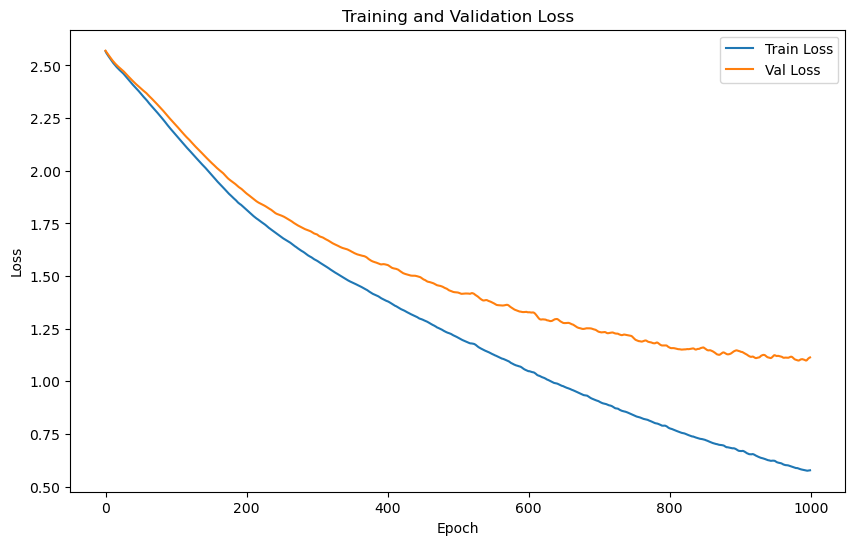

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 0.9867 | Test Accuracy: 67.66%


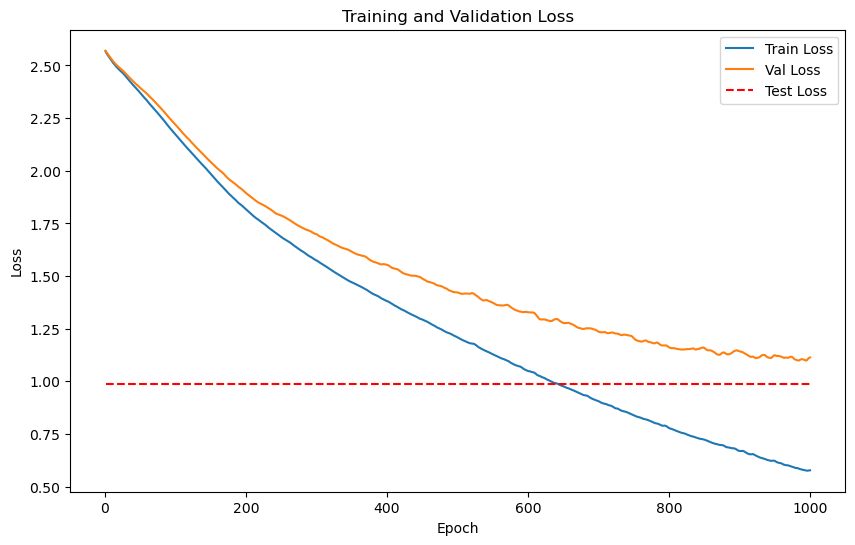

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 3108 samples with 64 features each
LOG: Labels shape: (3108,)


Train embeddings shape: (70, 64), 
Train labels shape: (70,)


Val embeddings shape: (70, 64), 
Val labels shape: (70,)


Test embeddings shape: (3108, 64), 
Test labels shape: (3108,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5, 9: 5, 10: 5, 11: 5, 12: 5, 13: 5}
Training batch size: 70


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 0.4903
LOG: Epoch [1/2000] - Validation
    Batch [1/2], Val Loss: 0.4711
    Batch [2/2], Val Loss: 0.2559
Epoch [1/2000], Avg Train Loss: 0.4903, Avg Val Loss: 0.3635

Validation loss improved from inf to 0.3635. Saving model...
LOG: Epoch [2/2000] - Training


    Batch [1/1], Train Loss: 0.4957
LOG: Epoch [2/2000] - Validation
    Batch [1/2], Val Loss: 0.4711
    Batch [2/2], Val Loss: 0.2573
Epoch [2/2000], Avg Train Loss: 0.4957, Avg Val Loss: 0.3642

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [3/2000] - Training


    Batch [1/1], Train Loss: 0.4971
LOG: Epoch [3/2000] - Validation
    Batch [1/2], Val Loss: 0.4709
    Batch [2/2], Val Loss: 0.2582
Epoch [3/2000], Avg Train Loss: 0.4971, Avg Val Loss: 0.3646

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [4/2000] - Training


    Batch [1/1], Train Loss: 0.4907
LOG: Epoch [4/2000] - Validation
    Batch [1/2], Val Loss: 0.4705
    Batch [2/2], Val Loss: 0.2576
Epoch [4/2000], Avg Train Loss: 0.4907, Avg Val Loss: 0.3641

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [5/2000] - Training


    Batch [1/1], Train Loss: 0.4858
LOG: Epoch [5/2000] - Validation
    Batch [1/2], Val Loss: 0.4701
    Batch [2/2], Val Loss: 0.2579
Epoch [5/2000], Avg Train Loss: 0.4858, Avg Val Loss: 0.3640

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [6/2000] - Training


    Batch [1/1], Train Loss: 0.4885
LOG: Epoch [6/2000] - Validation
    Batch [1/2], Val Loss: 0.4699
    Batch [2/2], Val Loss: 0.2582
Epoch [6/2000], Avg Train Loss: 0.4885, Avg Val Loss: 0.3640

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [7/2000] - Training


    Batch [1/1], Train Loss: 0.4871
LOG: Epoch [7/2000] - Validation
    Batch [1/2], Val Loss: 0.4694
    Batch [2/2], Val Loss: 0.2586
Epoch [7/2000], Avg Train Loss: 0.4871, Avg Val Loss: 0.3640

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [8/2000] - Training


    Batch [1/1], Train Loss: 0.4752
LOG: Epoch [8/2000] - Validation
    Batch [1/2], Val Loss: 0.4692
    Batch [2/2], Val Loss: 0.2595
Epoch [8/2000], Avg Train Loss: 0.4752, Avg Val Loss: 0.3643

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [9/2000] - Training


    Batch [1/1], Train Loss: 0.4846
LOG: Epoch [9/2000] - Validation
    Batch [1/2], Val Loss: 0.4689
    Batch [2/2], Val Loss: 0.2641
Epoch [9/2000], Avg Train Loss: 0.4846, Avg Val Loss: 0.3665

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [10/2000] - Training


    Batch [1/1], Train Loss: 0.4877
LOG: Epoch [10/2000] - Validation
    Batch [1/2], Val Loss: 0.4689
    Batch [2/2], Val Loss: 0.2734
Epoch [10/2000], Avg Train Loss: 0.4877, Avg Val Loss: 0.3711

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [11/2000] - Training


    Batch [1/1], Train Loss: 0.4838
LOG: Epoch [11/2000] - Validation
    Batch [1/2], Val Loss: 0.4689
    Batch [2/2], Val Loss: 0.2827
Epoch [11/2000], Avg Train Loss: 0.4838, Avg Val Loss: 0.3758

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [12/2000] - Training


    Batch [1/1], Train Loss: 0.4866
LOG: Epoch [12/2000] - Validation
    Batch [1/2], Val Loss: 0.4689
    Batch [2/2], Val Loss: 0.2845
Epoch [12/2000], Avg Train Loss: 0.4866, Avg Val Loss: 0.3767

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [13/2000] - Training


    Batch [1/1], Train Loss: 0.4832
LOG: Epoch [13/2000] - Validation
    Batch [1/2], Val Loss: 0.4688
    Batch [2/2], Val Loss: 0.2808
Epoch [13/2000], Avg Train Loss: 0.4832, Avg Val Loss: 0.3748

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [14/2000] - Training


    Batch [1/1], Train Loss: 0.4767
LOG: Epoch [14/2000] - Validation
    Batch [1/2], Val Loss: 0.4681
    Batch [2/2], Val Loss: 0.2771
Epoch [14/2000], Avg Train Loss: 0.4767, Avg Val Loss: 0.3726

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [15/2000] - Training


    Batch [1/1], Train Loss: 0.4760
LOG: Epoch [15/2000] - Validation
    Batch [1/2], Val Loss: 0.4672
    Batch [2/2], Val Loss: 0.2666
Epoch [15/2000], Avg Train Loss: 0.4760, Avg Val Loss: 0.3669

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [16/2000] - Training


    Batch [1/1], Train Loss: 0.4812
LOG: Epoch [16/2000] - Validation
    Batch [1/2], Val Loss: 0.4672
    Batch [2/2], Val Loss: 0.2539
Epoch [16/2000], Avg Train Loss: 0.4812, Avg Val Loss: 0.3606

Validation loss improved from 0.3635 to 0.3606. Saving model...
LOG: Epoch [17/2000] - Training


    Batch [1/1], Train Loss: 0.4802
LOG: Epoch [17/2000] - Validation
    Batch [1/2], Val Loss: 0.4681
    Batch [2/2], Val Loss: 0.2411
Epoch [17/2000], Avg Train Loss: 0.4802, Avg Val Loss: 0.3546

Validation loss improved from 0.3606 to 0.3546. Saving model...
LOG: Epoch [18/2000] - Training
    Batch [1/1], Train Loss: 0.4825
LOG: Epoch [18/2000] - Validation


    Batch [1/2], Val Loss: 0.4688
    Batch [2/2], Val Loss: 0.2297
Epoch [18/2000], Avg Train Loss: 0.4825, Avg Val Loss: 0.3492

Validation loss improved from 0.3546 to 0.3492. Saving model...
LOG: Epoch [19/2000] - Training
    Batch [1/1], Train Loss: 0.4720
LOG: Epoch [19/2000] - Validation


    Batch [1/2], Val Loss: 0.4694
    Batch [2/2], Val Loss: 0.2197
Epoch [19/2000], Avg Train Loss: 0.4720, Avg Val Loss: 0.3445

Validation loss improved from 0.3492 to 0.3445. Saving model...
LOG: Epoch [20/2000] - Training
    Batch [1/1], Train Loss: 0.4676
LOG: Epoch [20/2000] - Validation


    Batch [1/2], Val Loss: 0.4698
    Batch [2/2], Val Loss: 0.2121
Epoch [20/2000], Avg Train Loss: 0.4676, Avg Val Loss: 0.3410

Validation loss improved from 0.3445 to 0.3410. Saving model...
LOG: Epoch [21/2000] - Training
    Batch [1/1], Train Loss: 0.4720
LOG: Epoch [21/2000] - Validation


    Batch [1/2], Val Loss: 0.4698
    Batch [2/2], Val Loss: 0.2058
Epoch [21/2000], Avg Train Loss: 0.4720, Avg Val Loss: 0.3378

Validation loss improved from 0.3410 to 0.3378. Saving model...
LOG: Epoch [22/2000] - Training
    Batch [1/1], Train Loss: 0.4808
LOG: Epoch [22/2000] - Validation


    Batch [1/2], Val Loss: 0.4696
    Batch [2/2], Val Loss: 0.2018
Epoch [22/2000], Avg Train Loss: 0.4808, Avg Val Loss: 0.3357

Validation loss improved from 0.3378 to 0.3357. Saving model...
LOG: Epoch [23/2000] - Training
    Batch [1/1], Train Loss: 0.4661
LOG: Epoch [23/2000] - Validation


    Batch [1/2], Val Loss: 0.4689
    Batch [2/2], Val Loss: 0.2008
Epoch [23/2000], Avg Train Loss: 0.4661, Avg Val Loss: 0.3348

Validation loss improved from 0.3357 to 0.3348. Saving model...
LOG: Epoch [24/2000] - Training
    Batch [1/1], Train Loss: 0.4730
LOG: Epoch [24/2000] - Validation


    Batch [1/2], Val Loss: 0.4680
    Batch [2/2], Val Loss: 0.2004
Epoch [24/2000], Avg Train Loss: 0.4730, Avg Val Loss: 0.3342

Validation loss improved from 0.3348 to 0.3342. Saving model...
LOG: Epoch [25/2000] - Training
    Batch [1/1], Train Loss: 0.4659
LOG: Epoch [25/2000] - Validation


    Batch [1/2], Val Loss: 0.4664
    Batch [2/2], Val Loss: 0.2009
Epoch [25/2000], Avg Train Loss: 0.4659, Avg Val Loss: 0.3337

Validation loss improved from 0.3342 to 0.3337. Saving model...
LOG: Epoch [26/2000] - Training


    Batch [1/1], Train Loss: 0.4685
LOG: Epoch [26/2000] - Validation
    Batch [1/2], Val Loss: 0.4648
    Batch [2/2], Val Loss: 0.2029
Epoch [26/2000], Avg Train Loss: 0.4685, Avg Val Loss: 0.3338

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [27/2000] - Training


    Batch [1/1], Train Loss: 0.4691
LOG: Epoch [27/2000] - Validation
    Batch [1/2], Val Loss: 0.4626
    Batch [2/2], Val Loss: 0.2053
Epoch [27/2000], Avg Train Loss: 0.4691, Avg Val Loss: 0.3339

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [28/2000] - Training


    Batch [1/1], Train Loss: 0.4649
LOG: Epoch [28/2000] - Validation
    Batch [1/2], Val Loss: 0.4614
    Batch [2/2], Val Loss: 0.2075
Epoch [28/2000], Avg Train Loss: 0.4649, Avg Val Loss: 0.3345

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [29/2000] - Training


    Batch [1/1], Train Loss: 0.4646
LOG: Epoch [29/2000] - Validation
    Batch [1/2], Val Loss: 0.4605
    Batch [2/2], Val Loss: 0.2097
Epoch [29/2000], Avg Train Loss: 0.4646, Avg Val Loss: 0.3351

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [30/2000] - Training


    Batch [1/1], Train Loss: 0.4619
LOG: Epoch [30/2000] - Validation
    Batch [1/2], Val Loss: 0.4599
    Batch [2/2], Val Loss: 0.2122
Epoch [30/2000], Avg Train Loss: 0.4619, Avg Val Loss: 0.3361

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [31/2000] - Training


    Batch [1/1], Train Loss: 0.4529
LOG: Epoch [31/2000] - Validation
    Batch [1/2], Val Loss: 0.4589
    Batch [2/2], Val Loss: 0.2142
Epoch [31/2000], Avg Train Loss: 0.4529, Avg Val Loss: 0.3366

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [32/2000] - Training


    Batch [1/1], Train Loss: 0.4651
LOG: Epoch [32/2000] - Validation
    Batch [1/2], Val Loss: 0.4577
    Batch [2/2], Val Loss: 0.2161
Epoch [32/2000], Avg Train Loss: 0.4651, Avg Val Loss: 0.3369

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [33/2000] - Training


    Batch [1/1], Train Loss: 0.4554
LOG: Epoch [33/2000] - Validation
    Batch [1/2], Val Loss: 0.4564
    Batch [2/2], Val Loss: 0.2180
Epoch [33/2000], Avg Train Loss: 0.4554, Avg Val Loss: 0.3372

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [34/2000] - Training


    Batch [1/1], Train Loss: 0.4571
LOG: Epoch [34/2000] - Validation
    Batch [1/2], Val Loss: 0.4553
    Batch [2/2], Val Loss: 0.2197
Epoch [34/2000], Avg Train Loss: 0.4571, Avg Val Loss: 0.3375

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [35/2000] - Training


    Batch [1/1], Train Loss: 0.4577
LOG: Epoch [35/2000] - Validation
    Batch [1/2], Val Loss: 0.4544
    Batch [2/2], Val Loss: 0.2214
Epoch [35/2000], Avg Train Loss: 0.4577, Avg Val Loss: 0.3379

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [36/2000] - Training


    Batch [1/1], Train Loss: 0.4602
LOG: Epoch [36/2000] - Validation
    Batch [1/2], Val Loss: 0.4535
    Batch [2/2], Val Loss: 0.2232
Epoch [36/2000], Avg Train Loss: 0.4602, Avg Val Loss: 0.3383

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [37/2000] - Training


    Batch [1/1], Train Loss: 0.4637
LOG: Epoch [37/2000] - Validation
    Batch [1/2], Val Loss: 0.4526
    Batch [2/2], Val Loss: 0.2249
Epoch [37/2000], Avg Train Loss: 0.4637, Avg Val Loss: 0.3388

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [38/2000] - Training


    Batch [1/1], Train Loss: 0.4551
LOG: Epoch [38/2000] - Validation
    Batch [1/2], Val Loss: 0.4518
    Batch [2/2], Val Loss: 0.2268
Epoch [38/2000], Avg Train Loss: 0.4551, Avg Val Loss: 0.3393

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [39/2000] - Training


    Batch [1/1], Train Loss: 0.4543
LOG: Epoch [39/2000] - Validation
    Batch [1/2], Val Loss: 0.4510
    Batch [2/2], Val Loss: 0.2287
Epoch [39/2000], Avg Train Loss: 0.4543, Avg Val Loss: 0.3399

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [40/2000] - Training


    Batch [1/1], Train Loss: 0.4519
LOG: Epoch [40/2000] - Validation
    Batch [1/2], Val Loss: 0.4501
    Batch [2/2], Val Loss: 0.2307
Epoch [40/2000], Avg Train Loss: 0.4519, Avg Val Loss: 0.3404

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [41/2000] - Training


    Batch [1/1], Train Loss: 0.4547
LOG: Epoch [41/2000] - Validation
    Batch [1/2], Val Loss: 0.4494
    Batch [2/2], Val Loss: 0.2324
Epoch [41/2000], Avg Train Loss: 0.4547, Avg Val Loss: 0.3409

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [42/2000] - Training


    Batch [1/1], Train Loss: 0.4582
LOG: Epoch [42/2000] - Validation
    Batch [1/2], Val Loss: 0.4487
    Batch [2/2], Val Loss: 0.2338
Epoch [42/2000], Avg Train Loss: 0.4582, Avg Val Loss: 0.3413

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [43/2000] - Training


    Batch [1/1], Train Loss: 0.4598
LOG: Epoch [43/2000] - Validation
    Batch [1/2], Val Loss: 0.4481
    Batch [2/2], Val Loss: 0.2351
Epoch [43/2000], Avg Train Loss: 0.4598, Avg Val Loss: 0.3416

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [44/2000] - Training


    Batch [1/1], Train Loss: 0.4515
LOG: Epoch [44/2000] - Validation
    Batch [1/2], Val Loss: 0.4475
    Batch [2/2], Val Loss: 0.2362
Epoch [44/2000], Avg Train Loss: 0.4515, Avg Val Loss: 0.3418

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [45/2000] - Training


    Batch [1/1], Train Loss: 0.4601
LOG: Epoch [45/2000] - Validation
    Batch [1/2], Val Loss: 0.4471
    Batch [2/2], Val Loss: 0.2368
Epoch [45/2000], Avg Train Loss: 0.4601, Avg Val Loss: 0.3419

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [46/2000] - Training


    Batch [1/1], Train Loss: 0.4580
LOG: Epoch [46/2000] - Validation
    Batch [1/2], Val Loss: 0.4466
    Batch [2/2], Val Loss: 0.2373
Epoch [46/2000], Avg Train Loss: 0.4580, Avg Val Loss: 0.3420

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [47/2000] - Training
    Batch [1/1], Train Loss: 0.4517
LOG: Epoch [47/2000] - Validation


    Batch [1/2], Val Loss: 0.4462
    Batch [2/2], Val Loss: 0.2379
Epoch [47/2000], Avg Train Loss: 0.4517, Avg Val Loss: 0.3421

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [48/2000] - Training
    Batch [1/1], Train Loss: 0.4482
LOG: Epoch [48/2000] - Validation


    Batch [1/2], Val Loss: 0.4457
    Batch [2/2], Val Loss: 0.2384
Epoch [48/2000], Avg Train Loss: 0.4482, Avg Val Loss: 0.3421

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [49/2000] - Training
    Batch [1/1], Train Loss: 0.4584
LOG: Epoch [49/2000] - Validation
    Batch [1/2], Val Loss: 0.4454
    Batch [2/2], Val Loss: 0.2387
Epoch [49/2000], Avg Train Loss: 0.4584, Avg Val Loss: 0.3420

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [50/2000] - Training


    Batch [1/1], Train Loss: 0.4536
LOG: Epoch [50/2000] - Validation
    Batch [1/2], Val Loss: 0.4451
    Batch [2/2], Val Loss: 0.2388
Epoch [50/2000], Avg Train Loss: 0.4536, Avg Val Loss: 0.3419

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [51/2000] - Training


    Batch [1/1], Train Loss: 0.4499
LOG: Epoch [51/2000] - Validation
    Batch [1/2], Val Loss: 0.4447
    Batch [2/2], Val Loss: 0.2386
Epoch [51/2000], Avg Train Loss: 0.4499, Avg Val Loss: 0.3417

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [52/2000] - Training


    Batch [1/1], Train Loss: 0.4454
LOG: Epoch [52/2000] - Validation
    Batch [1/2], Val Loss: 0.4436
    Batch [2/2], Val Loss: 0.2396
Epoch [52/2000], Avg Train Loss: 0.4454, Avg Val Loss: 0.3416

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [53/2000] - Training


    Batch [1/1], Train Loss: 0.4444
LOG: Epoch [53/2000] - Validation
    Batch [1/2], Val Loss: 0.4426
    Batch [2/2], Val Loss: 0.2404
Epoch [53/2000], Avg Train Loss: 0.4444, Avg Val Loss: 0.3415

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [54/2000] - Training


    Batch [1/1], Train Loss: 0.4475
LOG: Epoch [54/2000] - Validation
    Batch [1/2], Val Loss: 0.4418
    Batch [2/2], Val Loss: 0.2410
Epoch [54/2000], Avg Train Loss: 0.4475, Avg Val Loss: 0.3414

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [55/2000] - Training


    Batch [1/1], Train Loss: 0.4477
LOG: Epoch [55/2000] - Validation
    Batch [1/2], Val Loss: 0.4412
    Batch [2/2], Val Loss: 0.2414
Epoch [55/2000], Avg Train Loss: 0.4477, Avg Val Loss: 0.3413

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [56/2000] - Training
    Batch [1/1], Train Loss: 0.4494
LOG: Epoch [56/2000] - Validation


    Batch [1/2], Val Loss: 0.4408
    Batch [2/2], Val Loss: 0.2419
Epoch [56/2000], Avg Train Loss: 0.4494, Avg Val Loss: 0.3413

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [57/2000] - Training
    Batch [1/1], Train Loss: 0.4454
LOG: Epoch [57/2000] - Validation


    Batch [1/2], Val Loss: 0.4403
    Batch [2/2], Val Loss: 0.2423
Epoch [57/2000], Avg Train Loss: 0.4454, Avg Val Loss: 0.3413

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [58/2000] - Training
    Batch [1/1], Train Loss: 0.4511
LOG: Epoch [58/2000] - Validation


    Batch [1/2], Val Loss: 0.4398
    Batch [2/2], Val Loss: 0.2426
Epoch [58/2000], Avg Train Loss: 0.4511, Avg Val Loss: 0.3412

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [59/2000] - Training
    Batch [1/1], Train Loss: 0.4470
LOG: Epoch [59/2000] - Validation


    Batch [1/2], Val Loss: 0.4392
    Batch [2/2], Val Loss: 0.2429
Epoch [59/2000], Avg Train Loss: 0.4470, Avg Val Loss: 0.3411

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [60/2000] - Training
    Batch [1/1], Train Loss: 0.4402
LOG: Epoch [60/2000] - Validation


    Batch [1/2], Val Loss: 0.4388
    Batch [2/2], Val Loss: 0.2432
Epoch [60/2000], Avg Train Loss: 0.4402, Avg Val Loss: 0.3410

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [61/2000] - Training
    Batch [1/1], Train Loss: 0.4418
LOG: Epoch [61/2000] - Validation


    Batch [1/2], Val Loss: 0.4384
    Batch [2/2], Val Loss: 0.2434
Epoch [61/2000], Avg Train Loss: 0.4418, Avg Val Loss: 0.3409

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [62/2000] - Training
    Batch [1/1], Train Loss: 0.4462
LOG: Epoch [62/2000] - Validation


    Batch [1/2], Val Loss: 0.4382
    Batch [2/2], Val Loss: 0.2437
Epoch [62/2000], Avg Train Loss: 0.4462, Avg Val Loss: 0.3409

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [63/2000] - Training
    Batch [1/1], Train Loss: 0.4454
LOG: Epoch [63/2000] - Validation


    Batch [1/2], Val Loss: 0.4381
    Batch [2/2], Val Loss: 0.2439
Epoch [63/2000], Avg Train Loss: 0.4454, Avg Val Loss: 0.3410

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [64/2000] - Training
    Batch [1/1], Train Loss: 0.4542
LOG: Epoch [64/2000] - Validation


    Batch [1/2], Val Loss: 0.4380
    Batch [2/2], Val Loss: 0.2442
Epoch [64/2000], Avg Train Loss: 0.4542, Avg Val Loss: 0.3411

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [65/2000] - Training
    Batch [1/1], Train Loss: 0.4506
LOG: Epoch [65/2000] - Validation
    Batch [1/2], Val Loss: 0.4380
    Batch [2/2], Val Loss: 0.2444
Epoch [65/2000], Avg Train Loss: 0.4506, Avg Val Loss: 0.3412

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [66/2000] - Training


    Batch [1/1], Train Loss: 0.4538
LOG: Epoch [66/2000] - Validation
    Batch [1/2], Val Loss: 0.4379
    Batch [2/2], Val Loss: 0.2446
Epoch [66/2000], Avg Train Loss: 0.4538, Avg Val Loss: 0.3413

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [67/2000] - Training


    Batch [1/1], Train Loss: 0.4436
LOG: Epoch [67/2000] - Validation
    Batch [1/2], Val Loss: 0.4379
    Batch [2/2], Val Loss: 0.2448
Epoch [67/2000], Avg Train Loss: 0.4436, Avg Val Loss: 0.3414

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [68/2000] - Training


    Batch [1/1], Train Loss: 0.4423
LOG: Epoch [68/2000] - Validation
    Batch [1/2], Val Loss: 0.4379
    Batch [2/2], Val Loss: 0.2450
Epoch [68/2000], Avg Train Loss: 0.4423, Avg Val Loss: 0.3415

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [69/2000] - Training


    Batch [1/1], Train Loss: 0.4476
LOG: Epoch [69/2000] - Validation
    Batch [1/2], Val Loss: 0.4379
    Batch [2/2], Val Loss: 0.2452
Epoch [69/2000], Avg Train Loss: 0.4476, Avg Val Loss: 0.3415

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [70/2000] - Training


    Batch [1/1], Train Loss: 0.4482
LOG: Epoch [70/2000] - Validation
    Batch [1/2], Val Loss: 0.4379
    Batch [2/2], Val Loss: 0.2453
Epoch [70/2000], Avg Train Loss: 0.4482, Avg Val Loss: 0.3416

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [71/2000] - Training


    Batch [1/1], Train Loss: 0.4466
LOG: Epoch [71/2000] - Validation
    Batch [1/2], Val Loss: 0.4379
    Batch [2/2], Val Loss: 0.2455
Epoch [71/2000], Avg Train Loss: 0.4466, Avg Val Loss: 0.3417

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [72/2000] - Training


    Batch [1/1], Train Loss: 0.4520
LOG: Epoch [72/2000] - Validation
    Batch [1/2], Val Loss: 0.4379
    Batch [2/2], Val Loss: 0.2456
Epoch [72/2000], Avg Train Loss: 0.4520, Avg Val Loss: 0.3418

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [73/2000] - Training


    Batch [1/1], Train Loss: 0.4342
LOG: Epoch [73/2000] - Validation
    Batch [1/2], Val Loss: 0.4379
    Batch [2/2], Val Loss: 0.2458
Epoch [73/2000], Avg Train Loss: 0.4342, Avg Val Loss: 0.3419

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [74/2000] - Training


    Batch [1/1], Train Loss: 0.4396
LOG: Epoch [74/2000] - Validation
    Batch [1/2], Val Loss: 0.4380
    Batch [2/2], Val Loss: 0.2459
Epoch [74/2000], Avg Train Loss: 0.4396, Avg Val Loss: 0.3419

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [75/2000] - Training


    Batch [1/1], Train Loss: 0.4456
LOG: Epoch [75/2000] - Validation
    Batch [1/2], Val Loss: 0.4380
    Batch [2/2], Val Loss: 0.2460
Epoch [75/2000], Avg Train Loss: 0.4456, Avg Val Loss: 0.3420

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [76/2000] - Training


    Batch [1/1], Train Loss: 0.4443
LOG: Epoch [76/2000] - Validation
    Batch [1/2], Val Loss: 0.4380
    Batch [2/2], Val Loss: 0.2461
Epoch [76/2000], Avg Train Loss: 0.4443, Avg Val Loss: 0.3421

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [77/2000] - Training


    Batch [1/1], Train Loss: 0.4519
LOG: Epoch [77/2000] - Validation
    Batch [1/2], Val Loss: 0.4380
    Batch [2/2], Val Loss: 0.2462
Epoch [77/2000], Avg Train Loss: 0.4519, Avg Val Loss: 0.3421

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [78/2000] - Training


    Batch [1/1], Train Loss: 0.4417
LOG: Epoch [78/2000] - Validation
    Batch [1/2], Val Loss: 0.4381
    Batch [2/2], Val Loss: 0.2465
Epoch [78/2000], Avg Train Loss: 0.4417, Avg Val Loss: 0.3423

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [79/2000] - Training


    Batch [1/1], Train Loss: 0.4391
LOG: Epoch [79/2000] - Validation
    Batch [1/2], Val Loss: 0.4383
    Batch [2/2], Val Loss: 0.2468
Epoch [79/2000], Avg Train Loss: 0.4391, Avg Val Loss: 0.3425

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [80/2000] - Training


    Batch [1/1], Train Loss: 0.4435
LOG: Epoch [80/2000] - Validation
    Batch [1/2], Val Loss: 0.4384
    Batch [2/2], Val Loss: 0.2471
Epoch [80/2000], Avg Train Loss: 0.4435, Avg Val Loss: 0.3427

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [81/2000] - Training


    Batch [1/1], Train Loss: 0.4365
LOG: Epoch [81/2000] - Validation
    Batch [1/2], Val Loss: 0.4385
    Batch [2/2], Val Loss: 0.2473
Epoch [81/2000], Avg Train Loss: 0.4365, Avg Val Loss: 0.3429

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [82/2000] - Training


    Batch [1/1], Train Loss: 0.4365
LOG: Epoch [82/2000] - Validation
    Batch [1/2], Val Loss: 0.4386
    Batch [2/2], Val Loss: 0.2476
Epoch [82/2000], Avg Train Loss: 0.4365, Avg Val Loss: 0.3431

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [83/2000] - Training
    Batch [1/1], Train Loss: 0.4456
LOG: Epoch [83/2000] - Validation


    Batch [1/2], Val Loss: 0.4387
    Batch [2/2], Val Loss: 0.2478
Epoch [83/2000], Avg Train Loss: 0.4456, Avg Val Loss: 0.3433

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [84/2000] - Training
    Batch [1/1], Train Loss: 0.4476
LOG: Epoch [84/2000] - Validation


    Batch [1/2], Val Loss: 0.4388
    Batch [2/2], Val Loss: 0.2480
Epoch [84/2000], Avg Train Loss: 0.4476, Avg Val Loss: 0.3434

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [85/2000] - Training
    Batch [1/1], Train Loss: 0.4462
LOG: Epoch [85/2000] - Validation


    Batch [1/2], Val Loss: 0.4389
    Batch [2/2], Val Loss: 0.2483
Epoch [85/2000], Avg Train Loss: 0.4462, Avg Val Loss: 0.3436

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [86/2000] - Training
    Batch [1/1], Train Loss: 0.4454
LOG: Epoch [86/2000] - Validation


    Batch [1/2], Val Loss: 0.4390
    Batch [2/2], Val Loss: 0.2485
Epoch [86/2000], Avg Train Loss: 0.4454, Avg Val Loss: 0.3437

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [87/2000] - Training
    Batch [1/1], Train Loss: 0.4352
LOG: Epoch [87/2000] - Validation


    Batch [1/2], Val Loss: 0.4390
    Batch [2/2], Val Loss: 0.2486
Epoch [87/2000], Avg Train Loss: 0.4352, Avg Val Loss: 0.3438

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [88/2000] - Training
    Batch [1/1], Train Loss: 0.4434
LOG: Epoch [88/2000] - Validation


    Batch [1/2], Val Loss: 0.4391
    Batch [2/2], Val Loss: 0.2488
Epoch [88/2000], Avg Train Loss: 0.4434, Avg Val Loss: 0.3440

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [89/2000] - Training
    Batch [1/1], Train Loss: 0.4448
LOG: Epoch [89/2000] - Validation


    Batch [1/2], Val Loss: 0.4392
    Batch [2/2], Val Loss: 0.2490
Epoch [89/2000], Avg Train Loss: 0.4448, Avg Val Loss: 0.3441

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [90/2000] - Training


    Batch [1/1], Train Loss: 0.4492
LOG: Epoch [90/2000] - Validation
    Batch [1/2], Val Loss: 0.4392
    Batch [2/2], Val Loss: 0.2491
Epoch [90/2000], Avg Train Loss: 0.4492, Avg Val Loss: 0.3442

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [91/2000] - Training


    Batch [1/1], Train Loss: 0.4495
LOG: Epoch [91/2000] - Validation
    Batch [1/2], Val Loss: 0.4393
    Batch [2/2], Val Loss: 0.2492
Epoch [91/2000], Avg Train Loss: 0.4495, Avg Val Loss: 0.3442

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [92/2000] - Training


    Batch [1/1], Train Loss: 0.4504
LOG: Epoch [92/2000] - Validation
    Batch [1/2], Val Loss: 0.4394
    Batch [2/2], Val Loss: 0.2493
Epoch [92/2000], Avg Train Loss: 0.4504, Avg Val Loss: 0.3443

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [93/2000] - Training


    Batch [1/1], Train Loss: 0.4509
LOG: Epoch [93/2000] - Validation
    Batch [1/2], Val Loss: 0.4394
    Batch [2/2], Val Loss: 0.2494
Epoch [93/2000], Avg Train Loss: 0.4509, Avg Val Loss: 0.3444

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [94/2000] - Training
    Batch [1/1], Train Loss: 0.4417
LOG: Epoch [94/2000] - Validation


    Batch [1/2], Val Loss: 0.4395
    Batch [2/2], Val Loss: 0.2495
Epoch [94/2000], Avg Train Loss: 0.4417, Avg Val Loss: 0.3445

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [95/2000] - Training


    Batch [1/1], Train Loss: 0.4433
LOG: Epoch [95/2000] - Validation
    Batch [1/2], Val Loss: 0.4395
    Batch [2/2], Val Loss: 0.2495
Epoch [95/2000], Avg Train Loss: 0.4433, Avg Val Loss: 0.3445

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [96/2000] - Training


    Batch [1/1], Train Loss: 0.4482
LOG: Epoch [96/2000] - Validation
    Batch [1/2], Val Loss: 0.4395
    Batch [2/2], Val Loss: 0.2496
Epoch [96/2000], Avg Train Loss: 0.4482, Avg Val Loss: 0.3446

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [97/2000] - Training


    Batch [1/1], Train Loss: 0.4400
LOG: Epoch [97/2000] - Validation
    Batch [1/2], Val Loss: 0.4396
    Batch [2/2], Val Loss: 0.2497
Epoch [97/2000], Avg Train Loss: 0.4400, Avg Val Loss: 0.3446

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [98/2000] - Training


    Batch [1/1], Train Loss: 0.4431
LOG: Epoch [98/2000] - Validation
    Batch [1/2], Val Loss: 0.4396
    Batch [2/2], Val Loss: 0.2497
Epoch [98/2000], Avg Train Loss: 0.4431, Avg Val Loss: 0.3446

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [99/2000] - Training


    Batch [1/1], Train Loss: 0.4510
LOG: Epoch [99/2000] - Validation
    Batch [1/2], Val Loss: 0.4396
    Batch [2/2], Val Loss: 0.2497
Epoch [99/2000], Avg Train Loss: 0.4510, Avg Val Loss: 0.3447

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [100/2000] - Training


    Batch [1/1], Train Loss: 0.4450
LOG: Epoch [100/2000] - Validation
    Batch [1/2], Val Loss: 0.4396
    Batch [2/2], Val Loss: 0.2498
Epoch [100/2000], Avg Train Loss: 0.4450, Avg Val Loss: 0.3447

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [101/2000] - Training
    Batch [1/1], Train Loss: 0.4501
LOG: Epoch [101/2000] - Validation


    Batch [1/2], Val Loss: 0.4396
    Batch [2/2], Val Loss: 0.2498
Epoch [101/2000], Avg Train Loss: 0.4501, Avg Val Loss: 0.3447

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [102/2000] - Training
    Batch [1/1], Train Loss: 0.4429
LOG: Epoch [102/2000] - Validation


    Batch [1/2], Val Loss: 0.4397
    Batch [2/2], Val Loss: 0.2498
Epoch [102/2000], Avg Train Loss: 0.4429, Avg Val Loss: 0.3447

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [103/2000] - Training
    Batch [1/1], Train Loss: 0.4430
LOG: Epoch [103/2000] - Validation


    Batch [1/2], Val Loss: 0.4397
    Batch [2/2], Val Loss: 0.2499
Epoch [103/2000], Avg Train Loss: 0.4430, Avg Val Loss: 0.3448

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [104/2000] - Training


    Batch [1/1], Train Loss: 0.4418
LOG: Epoch [104/2000] - Validation
    Batch [1/2], Val Loss: 0.4397
    Batch [2/2], Val Loss: 0.2499
Epoch [104/2000], Avg Train Loss: 0.4418, Avg Val Loss: 0.3448

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [105/2000] - Training


    Batch [1/1], Train Loss: 0.4504
LOG: Epoch [105/2000] - Validation
    Batch [1/2], Val Loss: 0.4397
    Batch [2/2], Val Loss: 0.2500
Epoch [105/2000], Avg Train Loss: 0.4504, Avg Val Loss: 0.3449

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [106/2000] - Training


    Batch [1/1], Train Loss: 0.4470
LOG: Epoch [106/2000] - Validation
    Batch [1/2], Val Loss: 0.4398
    Batch [2/2], Val Loss: 0.2500
Epoch [106/2000], Avg Train Loss: 0.4470, Avg Val Loss: 0.3449

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [107/2000] - Training


    Batch [1/1], Train Loss: 0.4426
LOG: Epoch [107/2000] - Validation
    Batch [1/2], Val Loss: 0.4398
    Batch [2/2], Val Loss: 0.2501
Epoch [107/2000], Avg Train Loss: 0.4426, Avg Val Loss: 0.3449

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [108/2000] - Training


    Batch [1/1], Train Loss: 0.4433
LOG: Epoch [108/2000] - Validation
    Batch [1/2], Val Loss: 0.4398
    Batch [2/2], Val Loss: 0.2501
Epoch [108/2000], Avg Train Loss: 0.4433, Avg Val Loss: 0.3450

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [109/2000] - Training


    Batch [1/1], Train Loss: 0.4531
LOG: Epoch [109/2000] - Validation
    Batch [1/2], Val Loss: 0.4398
    Batch [2/2], Val Loss: 0.2501
Epoch [109/2000], Avg Train Loss: 0.4531, Avg Val Loss: 0.3450

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [110/2000] - Training


    Batch [1/1], Train Loss: 0.4417
LOG: Epoch [110/2000] - Validation
    Batch [1/2], Val Loss: 0.4399
    Batch [2/2], Val Loss: 0.2501
Epoch [110/2000], Avg Train Loss: 0.4417, Avg Val Loss: 0.3450

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [111/2000] - Training


    Batch [1/1], Train Loss: 0.4500
LOG: Epoch [111/2000] - Validation
    Batch [1/2], Val Loss: 0.4399
    Batch [2/2], Val Loss: 0.2502
Epoch [111/2000], Avg Train Loss: 0.4500, Avg Val Loss: 0.3450

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [112/2000] - Training


    Batch [1/1], Train Loss: 0.4550
LOG: Epoch [112/2000] - Validation
    Batch [1/2], Val Loss: 0.4399
    Batch [2/2], Val Loss: 0.2502
Epoch [112/2000], Avg Train Loss: 0.4550, Avg Val Loss: 0.3450

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [113/2000] - Training


    Batch [1/1], Train Loss: 0.4383
LOG: Epoch [113/2000] - Validation
    Batch [1/2], Val Loss: 0.4399
    Batch [2/2], Val Loss: 0.2502
Epoch [113/2000], Avg Train Loss: 0.4383, Avg Val Loss: 0.3451

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [114/2000] - Training


    Batch [1/1], Train Loss: 0.4440
LOG: Epoch [114/2000] - Validation
    Batch [1/2], Val Loss: 0.4399
    Batch [2/2], Val Loss: 0.2502
Epoch [114/2000], Avg Train Loss: 0.4440, Avg Val Loss: 0.3451

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [115/2000] - Training


    Batch [1/1], Train Loss: 0.4468
LOG: Epoch [115/2000] - Validation
    Batch [1/2], Val Loss: 0.4399
    Batch [2/2], Val Loss: 0.2502
Epoch [115/2000], Avg Train Loss: 0.4468, Avg Val Loss: 0.3451

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [116/2000] - Training


    Batch [1/1], Train Loss: 0.4417
LOG: Epoch [116/2000] - Validation
    Batch [1/2], Val Loss: 0.4399
    Batch [2/2], Val Loss: 0.2503
Epoch [116/2000], Avg Train Loss: 0.4417, Avg Val Loss: 0.3451

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [117/2000] - Training


    Batch [1/1], Train Loss: 0.4458
LOG: Epoch [117/2000] - Validation
    Batch [1/2], Val Loss: 0.4399
    Batch [2/2], Val Loss: 0.2503
Epoch [117/2000], Avg Train Loss: 0.4458, Avg Val Loss: 0.3451

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [118/2000] - Training
    Batch [1/1], Train Loss: 0.4490
LOG: Epoch [118/2000] - Validation


    Batch [1/2], Val Loss: 0.4400
    Batch [2/2], Val Loss: 0.2503
Epoch [118/2000], Avg Train Loss: 0.4490, Avg Val Loss: 0.3451

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [119/2000] - Training
    Batch [1/1], Train Loss: 0.4492
LOG: Epoch [119/2000] - Validation


    Batch [1/2], Val Loss: 0.4400
    Batch [2/2], Val Loss: 0.2503
Epoch [119/2000], Avg Train Loss: 0.4492, Avg Val Loss: 0.3451

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [120/2000] - Training
    Batch [1/1], Train Loss: 0.4519
LOG: Epoch [120/2000] - Validation


    Batch [1/2], Val Loss: 0.4400
    Batch [2/2], Val Loss: 0.2503
Epoch [120/2000], Avg Train Loss: 0.4519, Avg Val Loss: 0.3451

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [121/2000] - Training
    Batch [1/1], Train Loss: 0.4367
LOG: Epoch [121/2000] - Validation


    Batch [1/2], Val Loss: 0.4400
    Batch [2/2], Val Loss: 0.2503
Epoch [121/2000], Avg Train Loss: 0.4367, Avg Val Loss: 0.3451

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [122/2000] - Training
    Batch [1/1], Train Loss: 0.4472
LOG: Epoch [122/2000] - Validation


    Batch [1/2], Val Loss: 0.4400
    Batch [2/2], Val Loss: 0.2503
Epoch [122/2000], Avg Train Loss: 0.4472, Avg Val Loss: 0.3451

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [123/2000] - Training
    Batch [1/1], Train Loss: 0.4503
LOG: Epoch [123/2000] - Validation


    Batch [1/2], Val Loss: 0.4400
    Batch [2/2], Val Loss: 0.2503
Epoch [123/2000], Avg Train Loss: 0.4503, Avg Val Loss: 0.3452

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [124/2000] - Training
    Batch [1/1], Train Loss: 0.4446
LOG: Epoch [124/2000] - Validation


    Batch [1/2], Val Loss: 0.4400
    Batch [2/2], Val Loss: 0.2503
Epoch [124/2000], Avg Train Loss: 0.4446, Avg Val Loss: 0.3452

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [125/2000] - Training
    Batch [1/1], Train Loss: 0.4429
LOG: Epoch [125/2000] - Validation


    Batch [1/2], Val Loss: 0.4400
    Batch [2/2], Val Loss: 0.2503
Epoch [125/2000], Avg Train Loss: 0.4429, Avg Val Loss: 0.3452

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 125!!
No improvement for 100 epochs


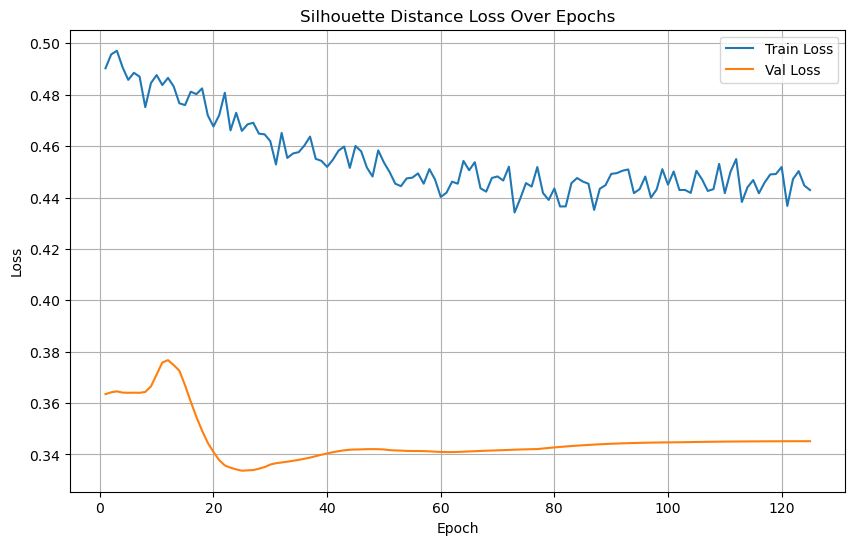

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/49], Loss: 0.1717
Test Batch [20/49], Loss: 0.3021
Test Batch [30/49], Loss: 0.3875


Test Batch [40/49], Loss: 0.2159

Test Loss: 0.3380


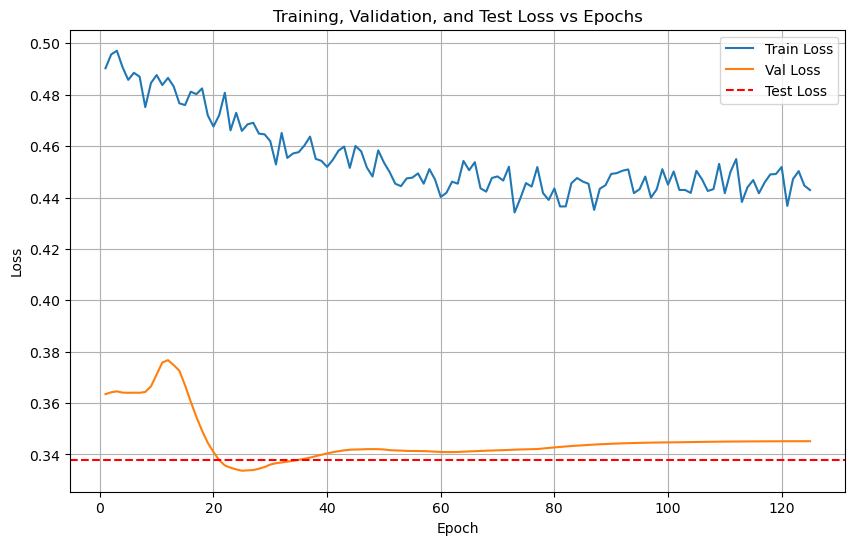

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...


  Processed batch 10/49 for test dataset.
  Processed batch 20/49 for test dataset.


  Processed batch 30/49 for test dataset.
  Processed batch 40/49 for test dataset.


Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (70, 128)
Train labels shape: (70,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (3108, 128)
Test labels shape: (3108,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 74.29%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      0.60      0.75         5
           2       0.50      0.40      0.44         5
           3       0.75      0.60      0.67         5
           4       0.75      0.60      0.67         5
           5       0.50      0.20      0.29         5
           6       0.71      1.00      0.83         5
           7       0.83      1.00      0.91         5
           8       0.50      0.80      0.62         5
           9       0.71      1.00      0.83         5
          10       1.00      0.80      0.89         5
          11       0.83      1.00      0.91         5
          12       0.50      0.60      0.55         5
          13       1.0

## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (70, 128)
Train labels shape: (70,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (3108, 128)
Test labels shape: (3108,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.6656  |  Val Loss: 2.6655
Validation loss improved from inf to 2.6655.
[Epoch 2/1000] Train Loss: 2.6571  |  Val Loss: 2.6597
Validation loss improved from 2.6655 to 2.6597.
[Epoch 3/1000] Train Loss: 2.6492  |  Val Loss: 2.6543
Validation loss improved from 2.6597 to 2.6543.
[Epoch 4/1000] Train Loss: 2.6427  |  Val Loss: 2.6492
Validation loss improved from 2.6543 to 2.6492.
[Epoch 5/1000] Train Loss: 2.6358  |  Val Loss: 2.6444
Validation loss improved from 2.6492 to 2.6444.
[Epoch 6/1000] Train Loss: 2.6294  |  Val Loss: 2.6395
Validation loss improved from 2.6444 to 2.6395.
[Epoch 7/1000] Train Loss: 2.6236  |  Val Loss: 2.6347
Validation loss improved from 2.6395 to 2.6347.
[Epoch 8/1000] Train Loss: 2.6175  |  Val Loss: 2.6302
Validation loss improved from 2.6347 to 2.6302.
[Epoch 9/1000] Train Loss: 2.6117  |  Val Loss: 2.6259
Validation loss improved from 2.6302 to 2.6259.
[Epoch 10/1000] Train Loss: 2.6064  |  Val Loss: 2.6217
Validation loss impr

[Epoch 27/1000] Train Loss: 2.5114  |  Val Loss: 2.5478
Validation loss improved from 2.5516 to 2.5478.
[Epoch 28/1000] Train Loss: 2.5065  |  Val Loss: 2.5440
Validation loss improved from 2.5478 to 2.5440.
[Epoch 29/1000] Train Loss: 2.5015  |  Val Loss: 2.5404
Validation loss improved from 2.5440 to 2.5404.
[Epoch 30/1000] Train Loss: 2.4967  |  Val Loss: 2.5367
Validation loss improved from 2.5404 to 2.5367.
[Epoch 31/1000] Train Loss: 2.4917  |  Val Loss: 2.5331
Validation loss improved from 2.5367 to 2.5331.
[Epoch 32/1000] Train Loss: 2.4869  |  Val Loss: 2.5294
Validation loss improved from 2.5331 to 2.5294.
[Epoch 33/1000] Train Loss: 2.4819  |  Val Loss: 2.5257
Validation loss improved from 2.5294 to 2.5257.
[Epoch 34/1000] Train Loss: 2.4769  |  Val Loss: 2.5218
Validation loss improved from 2.5257 to 2.5218.
[Epoch 35/1000] Train Loss: 2.4721  |  Val Loss: 2.5179
Validation loss improved from 2.5218 to 2.5179.
[Epoch 36/1000] Train Loss: 2.4668  |  Val Loss: 2.5140
Validati

[Epoch 38/1000] Train Loss: 2.4565  |  Val Loss: 2.5057
Validation loss improved from 2.5099 to 2.5057.
[Epoch 39/1000] Train Loss: 2.4517  |  Val Loss: 2.5015
Validation loss improved from 2.5057 to 2.5015.
[Epoch 40/1000] Train Loss: 2.4463  |  Val Loss: 2.4975
Validation loss improved from 2.5015 to 2.4975.
[Epoch 41/1000] Train Loss: 2.4412  |  Val Loss: 2.4937
Validation loss improved from 2.4975 to 2.4937.
[Epoch 42/1000] Train Loss: 2.4363  |  Val Loss: 2.4897
Validation loss improved from 2.4937 to 2.4897.
[Epoch 43/1000] Train Loss: 2.4314  |  Val Loss: 2.4858
Validation loss improved from 2.4897 to 2.4858.
[Epoch 44/1000] Train Loss: 2.4265  |  Val Loss: 2.4818
Validation loss improved from 2.4858 to 2.4818.
[Epoch 45/1000] Train Loss: 2.4213  |  Val Loss: 2.4777
Validation loss improved from 2.4818 to 2.4777.
[Epoch 46/1000] Train Loss: 2.4162  |  Val Loss: 2.4735
Validation loss improved from 2.4777 to 2.4735.
[Epoch 47/1000] Train Loss: 2.4112  |  Val Loss: 2.4693
Validati

[Epoch 64/1000] Train Loss: 2.3377  |  Val Loss: 2.4104
Validation loss improved from 2.4137 to 2.4104.
[Epoch 65/1000] Train Loss: 2.3337  |  Val Loss: 2.4070
Validation loss improved from 2.4104 to 2.4070.
[Epoch 66/1000] Train Loss: 2.3296  |  Val Loss: 2.4035
Validation loss improved from 2.4070 to 2.4035.
[Epoch 67/1000] Train Loss: 2.3254  |  Val Loss: 2.4000
Validation loss improved from 2.4035 to 2.4000.
[Epoch 68/1000] Train Loss: 2.3210  |  Val Loss: 2.3965
Validation loss improved from 2.4000 to 2.3965.
[Epoch 69/1000] Train Loss: 2.3169  |  Val Loss: 2.3931
Validation loss improved from 2.3965 to 2.3931.
[Epoch 70/1000] Train Loss: 2.3128  |  Val Loss: 2.3898
Validation loss improved from 2.3931 to 2.3898.
[Epoch 71/1000] Train Loss: 2.3087  |  Val Loss: 2.3865
Validation loss improved from 2.3898 to 2.3865.


[Epoch 72/1000] Train Loss: 2.3048  |  Val Loss: 2.3831
Validation loss improved from 2.3865 to 2.3831.
[Epoch 73/1000] Train Loss: 2.3008  |  Val Loss: 2.3798
Validation loss improved from 2.3831 to 2.3798.
[Epoch 74/1000] Train Loss: 2.2967  |  Val Loss: 2.3762
Validation loss improved from 2.3798 to 2.3762.
[Epoch 75/1000] Train Loss: 2.2930  |  Val Loss: 2.3726
Validation loss improved from 2.3762 to 2.3726.
[Epoch 76/1000] Train Loss: 2.2888  |  Val Loss: 2.3692
Validation loss improved from 2.3726 to 2.3692.
[Epoch 77/1000] Train Loss: 2.2850  |  Val Loss: 2.3660
Validation loss improved from 2.3692 to 2.3660.
[Epoch 78/1000] Train Loss: 2.2811  |  Val Loss: 2.3629
Validation loss improved from 2.3660 to 2.3629.
[Epoch 79/1000] Train Loss: 2.2774  |  Val Loss: 2.3597
Validation loss improved from 2.3629 to 2.3597.
[Epoch 80/1000] Train Loss: 2.2734  |  Val Loss: 2.3564
Validation loss improved from 2.3597 to 2.3564.
[Epoch 81/1000] Train Loss: 2.2695  |  Val Loss: 2.3531
Validati

[Epoch 102/1000] Train Loss: 2.1762  |  Val Loss: 2.2738
Validation loss improved from 2.2779 to 2.2738.
[Epoch 103/1000] Train Loss: 2.1714  |  Val Loss: 2.2695
Validation loss improved from 2.2738 to 2.2695.
[Epoch 104/1000] Train Loss: 2.1665  |  Val Loss: 2.2650
Validation loss improved from 2.2695 to 2.2650.
[Epoch 105/1000] Train Loss: 2.1615  |  Val Loss: 2.2606
Validation loss improved from 2.2650 to 2.2606.
[Epoch 106/1000] Train Loss: 2.1563  |  Val Loss: 2.2562
Validation loss improved from 2.2606 to 2.2562.
[Epoch 107/1000] Train Loss: 2.1513  |  Val Loss: 2.2516
Validation loss improved from 2.2562 to 2.2516.
[Epoch 108/1000] Train Loss: 2.1461  |  Val Loss: 2.2472
Validation loss improved from 2.2516 to 2.2472.
[Epoch 109/1000] Train Loss: 2.1409  |  Val Loss: 2.2428
Validation loss improved from 2.2472 to 2.2428.
[Epoch 110/1000] Train Loss: 2.1357  |  Val Loss: 2.2385
Validation loss improved from 2.2428 to 2.2385.
[Epoch 111/1000] Train Loss: 2.1306  |  Val Loss: 2.234

[Epoch 112/1000] Train Loss: 2.1256  |  Val Loss: 2.2297
Validation loss improved from 2.2342 to 2.2297.
[Epoch 113/1000] Train Loss: 2.1206  |  Val Loss: 2.2253
Validation loss improved from 2.2297 to 2.2253.
[Epoch 114/1000] Train Loss: 2.1153  |  Val Loss: 2.2211
Validation loss improved from 2.2253 to 2.2211.
[Epoch 115/1000] Train Loss: 2.1102  |  Val Loss: 2.2169
Validation loss improved from 2.2211 to 2.2169.
[Epoch 116/1000] Train Loss: 2.1051  |  Val Loss: 2.2127
Validation loss improved from 2.2169 to 2.2127.
[Epoch 117/1000] Train Loss: 2.1002  |  Val Loss: 2.2086
Validation loss improved from 2.2127 to 2.2086.
[Epoch 118/1000] Train Loss: 2.0951  |  Val Loss: 2.2044
Validation loss improved from 2.2086 to 2.2044.
[Epoch 119/1000] Train Loss: 2.0901  |  Val Loss: 2.1999
Validation loss improved from 2.2044 to 2.1999.
[Epoch 120/1000] Train Loss: 2.0852  |  Val Loss: 2.1954
Validation loss improved from 2.1999 to 2.1954.
[Epoch 121/1000] Train Loss: 2.0798  |  Val Loss: 2.191

[Epoch 144/1000] Train Loss: 1.9484  |  Val Loss: 2.0823
Validation loss improved from 2.0868 to 2.0823.
[Epoch 145/1000] Train Loss: 1.9426  |  Val Loss: 2.0776
Validation loss improved from 2.0823 to 2.0776.
[Epoch 146/1000] Train Loss: 1.9370  |  Val Loss: 2.0729
Validation loss improved from 2.0776 to 2.0729.
[Epoch 147/1000] Train Loss: 1.9312  |  Val Loss: 2.0682
Validation loss improved from 2.0729 to 2.0682.
[Epoch 148/1000] Train Loss: 1.9254  |  Val Loss: 2.0636
Validation loss improved from 2.0682 to 2.0636.
[Epoch 149/1000] Train Loss: 1.9196  |  Val Loss: 2.0591
Validation loss improved from 2.0636 to 2.0591.
[Epoch 150/1000] Train Loss: 1.9142  |  Val Loss: 2.0548
Validation loss improved from 2.0591 to 2.0548.
[Epoch 151/1000] Train Loss: 1.9086  |  Val Loss: 2.0505
Validation loss improved from 2.0548 to 2.0505.
[Epoch 152/1000] Train Loss: 1.9030  |  Val Loss: 2.0463
Validation loss improved from 2.0505 to 2.0463.
[Epoch 153/1000] Train Loss: 1.8975  |  Val Loss: 2.042

[Epoch 155/1000] Train Loss: 1.8864  |  Val Loss: 2.0336
Validation loss improved from 2.0379 to 2.0336.
[Epoch 156/1000] Train Loss: 1.8809  |  Val Loss: 2.0293
Validation loss improved from 2.0336 to 2.0293.
[Epoch 157/1000] Train Loss: 1.8753  |  Val Loss: 2.0250
Validation loss improved from 2.0293 to 2.0250.
[Epoch 158/1000] Train Loss: 1.8697  |  Val Loss: 2.0206
Validation loss improved from 2.0250 to 2.0206.
[Epoch 159/1000] Train Loss: 1.8643  |  Val Loss: 2.0162
Validation loss improved from 2.0206 to 2.0162.
[Epoch 160/1000] Train Loss: 1.8587  |  Val Loss: 2.0116
Validation loss improved from 2.0162 to 2.0116.
[Epoch 161/1000] Train Loss: 1.8533  |  Val Loss: 2.0067
Validation loss improved from 2.0116 to 2.0067.
[Epoch 162/1000] Train Loss: 1.8476  |  Val Loss: 2.0018
Validation loss improved from 2.0067 to 2.0018.
[Epoch 163/1000] Train Loss: 1.8414  |  Val Loss: 1.9969
Validation loss improved from 2.0018 to 1.9969.
[Epoch 164/1000] Train Loss: 1.8356  |  Val Loss: 1.991

[Epoch 186/1000] Train Loss: 1.7079  |  Val Loss: 1.8908
Validation loss improved from 1.8954 to 1.8908.
[Epoch 187/1000] Train Loss: 1.7021  |  Val Loss: 1.8862
Validation loss improved from 1.8908 to 1.8862.
[Epoch 188/1000] Train Loss: 1.6965  |  Val Loss: 1.8816
Validation loss improved from 1.8862 to 1.8816.
[Epoch 189/1000] Train Loss: 1.6908  |  Val Loss: 1.8772
Validation loss improved from 1.8816 to 1.8772.
[Epoch 190/1000] Train Loss: 1.6854  |  Val Loss: 1.8728
Validation loss improved from 1.8772 to 1.8728.
[Epoch 191/1000] Train Loss: 1.6801  |  Val Loss: 1.8684
Validation loss improved from 1.8728 to 1.8684.
[Epoch 192/1000] Train Loss: 1.6748  |  Val Loss: 1.8641
Validation loss improved from 1.8684 to 1.8641.
[Epoch 193/1000] Train Loss: 1.6692  |  Val Loss: 1.8600
Validation loss improved from 1.8641 to 1.8600.
[Epoch 194/1000] Train Loss: 1.6638  |  Val Loss: 1.8558
Validation loss improved from 1.8600 to 1.8558.
[Epoch 195/1000] Train Loss: 1.6585  |  Val Loss: 1.851

[Epoch 198/1000] Train Loss: 1.6427  |  Val Loss: 1.8393
Validation loss improved from 1.8435 to 1.8393.
[Epoch 199/1000] Train Loss: 1.6373  |  Val Loss: 1.8353
Validation loss improved from 1.8393 to 1.8353.
[Epoch 200/1000] Train Loss: 1.6319  |  Val Loss: 1.8312
Validation loss improved from 1.8353 to 1.8312.
[Epoch 201/1000] Train Loss: 1.6266  |  Val Loss: 1.8272
Validation loss improved from 1.8312 to 1.8272.
[Epoch 202/1000] Train Loss: 1.6215  |  Val Loss: 1.8231
Validation loss improved from 1.8272 to 1.8231.
[Epoch 203/1000] Train Loss: 1.6163  |  Val Loss: 1.8190
Validation loss improved from 1.8231 to 1.8190.
[Epoch 204/1000] Train Loss: 1.6112  |  Val Loss: 1.8150
Validation loss improved from 1.8190 to 1.8150.
[Epoch 205/1000] Train Loss: 1.6062  |  Val Loss: 1.8107
Validation loss improved from 1.8150 to 1.8107.
[Epoch 206/1000] Train Loss: 1.6010  |  Val Loss: 1.8064
Validation loss improved from 1.8107 to 1.8064.
[Epoch 207/1000] Train Loss: 1.5956  |  Val Loss: 1.802

[Epoch 232/1000] Train Loss: 1.4614  |  Val Loss: 1.7042
Validation loss improved from 1.7078 to 1.7042.
[Epoch 233/1000] Train Loss: 1.4564  |  Val Loss: 1.7006
Validation loss improved from 1.7042 to 1.7006.
[Epoch 234/1000] Train Loss: 1.4514  |  Val Loss: 1.6969
Validation loss improved from 1.7006 to 1.6969.
[Epoch 235/1000] Train Loss: 1.4464  |  Val Loss: 1.6932
Validation loss improved from 1.6969 to 1.6932.
[Epoch 236/1000] Train Loss: 1.4414  |  Val Loss: 1.6895
Validation loss improved from 1.6932 to 1.6895.
[Epoch 237/1000] Train Loss: 1.4363  |  Val Loss: 1.6858
Validation loss improved from 1.6895 to 1.6858.
[Epoch 238/1000] Train Loss: 1.4313  |  Val Loss: 1.6820
Validation loss improved from 1.6858 to 1.6820.
[Epoch 239/1000] Train Loss: 1.4264  |  Val Loss: 1.6781
Validation loss improved from 1.6820 to 1.6781.
[Epoch 240/1000] Train Loss: 1.4215  |  Val Loss: 1.6741
Validation loss improved from 1.6781 to 1.6741.


[Epoch 241/1000] Train Loss: 1.4166  |  Val Loss: 1.6699
Validation loss improved from 1.6741 to 1.6699.
[Epoch 242/1000] Train Loss: 1.4117  |  Val Loss: 1.6657
Validation loss improved from 1.6699 to 1.6657.
[Epoch 243/1000] Train Loss: 1.4067  |  Val Loss: 1.6616
Validation loss improved from 1.6657 to 1.6616.
[Epoch 244/1000] Train Loss: 1.4016  |  Val Loss: 1.6576
Validation loss improved from 1.6616 to 1.6576.
[Epoch 245/1000] Train Loss: 1.3967  |  Val Loss: 1.6536
Validation loss improved from 1.6576 to 1.6536.
[Epoch 246/1000] Train Loss: 1.3915  |  Val Loss: 1.6497
Validation loss improved from 1.6536 to 1.6497.
[Epoch 247/1000] Train Loss: 1.3867  |  Val Loss: 1.6457
Validation loss improved from 1.6497 to 1.6457.
[Epoch 248/1000] Train Loss: 1.3819  |  Val Loss: 1.6419
Validation loss improved from 1.6457 to 1.6419.
[Epoch 249/1000] Train Loss: 1.3771  |  Val Loss: 1.6382
Validation loss improved from 1.6419 to 1.6382.
[Epoch 250/1000] Train Loss: 1.3726  |  Val Loss: 1.634

[Epoch 272/1000] Train Loss: 1.2618  |  Val Loss: 1.5536
Validation loss improved from 1.5573 to 1.5536.
[Epoch 273/1000] Train Loss: 1.2566  |  Val Loss: 1.5499
Validation loss improved from 1.5536 to 1.5499.
[Epoch 274/1000] Train Loss: 1.2517  |  Val Loss: 1.5461
Validation loss improved from 1.5499 to 1.5461.
[Epoch 275/1000] Train Loss: 1.2470  |  Val Loss: 1.5423
Validation loss improved from 1.5461 to 1.5423.
[Epoch 276/1000] Train Loss: 1.2418  |  Val Loss: 1.5386
Validation loss improved from 1.5423 to 1.5386.
[Epoch 277/1000] Train Loss: 1.2370  |  Val Loss: 1.5349
Validation loss improved from 1.5386 to 1.5349.
[Epoch 278/1000] Train Loss: 1.2321  |  Val Loss: 1.5314
Validation loss improved from 1.5349 to 1.5314.
[Epoch 279/1000] Train Loss: 1.2271  |  Val Loss: 1.5280
Validation loss improved from 1.5314 to 1.5280.
[Epoch 280/1000] Train Loss: 1.2220  |  Val Loss: 1.5249
Validation loss improved from 1.5280 to 1.5249.


[Epoch 281/1000] Train Loss: 1.2172  |  Val Loss: 1.5219
Validation loss improved from 1.5249 to 1.5219.
[Epoch 282/1000] Train Loss: 1.2124  |  Val Loss: 1.5189
Validation loss improved from 1.5219 to 1.5189.
[Epoch 283/1000] Train Loss: 1.2074  |  Val Loss: 1.5159
Validation loss improved from 1.5189 to 1.5159.
[Epoch 284/1000] Train Loss: 1.2025  |  Val Loss: 1.5128
Validation loss improved from 1.5159 to 1.5128.
[Epoch 285/1000] Train Loss: 1.1974  |  Val Loss: 1.5097
Validation loss improved from 1.5128 to 1.5097.
[Epoch 286/1000] Train Loss: 1.1927  |  Val Loss: 1.5065
Validation loss improved from 1.5097 to 1.5065.
[Epoch 287/1000] Train Loss: 1.1875  |  Val Loss: 1.5032
Validation loss improved from 1.5065 to 1.5032.
[Epoch 288/1000] Train Loss: 1.1823  |  Val Loss: 1.4997
Validation loss improved from 1.5032 to 1.4997.
[Epoch 289/1000] Train Loss: 1.1771  |  Val Loss: 1.4959
Validation loss improved from 1.4997 to 1.4959.
[Epoch 290/1000] Train Loss: 1.1716  |  Val Loss: 1.492

[Epoch 313/1000] Train Loss: 1.0599  |  Val Loss: 1.4170
Validation loss improved from 1.4197 to 1.4170.
[Epoch 314/1000] Train Loss: 1.0550  |  Val Loss: 1.4142
Validation loss improved from 1.4170 to 1.4142.
[Epoch 315/1000] Train Loss: 1.0502  |  Val Loss: 1.4112
Validation loss improved from 1.4142 to 1.4112.
[Epoch 316/1000] Train Loss: 1.0453  |  Val Loss: 1.4078
Validation loss improved from 1.4112 to 1.4078.
[Epoch 317/1000] Train Loss: 1.0402  |  Val Loss: 1.4042
Validation loss improved from 1.4078 to 1.4042.
[Epoch 318/1000] Train Loss: 1.0352  |  Val Loss: 1.4005
Validation loss improved from 1.4042 to 1.4005.
[Epoch 319/1000] Train Loss: 1.0301  |  Val Loss: 1.3972
Validation loss improved from 1.4005 to 1.3972.
[Epoch 320/1000] Train Loss: 1.0255  |  Val Loss: 1.3942
Validation loss improved from 1.3972 to 1.3942.
[Epoch 321/1000] Train Loss: 1.0210  |  Val Loss: 1.3913
Validation loss improved from 1.3942 to 1.3913.
[Epoch 322/1000] Train Loss: 1.0165  |  Val Loss: 1.388

[Epoch 323/1000] Train Loss: 1.0122  |  Val Loss: 1.3854
Validation loss improved from 1.3883 to 1.3854.
[Epoch 324/1000] Train Loss: 1.0076  |  Val Loss: 1.3824
Validation loss improved from 1.3854 to 1.3824.
[Epoch 325/1000] Train Loss: 1.0031  |  Val Loss: 1.3793
Validation loss improved from 1.3824 to 1.3793.
[Epoch 326/1000] Train Loss: 0.9985  |  Val Loss: 1.3760
Validation loss improved from 1.3793 to 1.3760.
[Epoch 327/1000] Train Loss: 0.9940  |  Val Loss: 1.3728
Validation loss improved from 1.3760 to 1.3728.
[Epoch 328/1000] Train Loss: 0.9892  |  Val Loss: 1.3697
Validation loss improved from 1.3728 to 1.3697.
[Epoch 329/1000] Train Loss: 0.9847  |  Val Loss: 1.3664
Validation loss improved from 1.3697 to 1.3664.
[Epoch 330/1000] Train Loss: 0.9802  |  Val Loss: 1.3632
Validation loss improved from 1.3664 to 1.3632.
[Epoch 331/1000] Train Loss: 0.9760  |  Val Loss: 1.3603
Validation loss improved from 1.3632 to 1.3603.
[Epoch 332/1000] Train Loss: 0.9715  |  Val Loss: 1.357

[Epoch 355/1000] Train Loss: 0.8771  |  Val Loss: 1.3010
Validation loss improved from 1.3033 to 1.3010.
[Epoch 356/1000] Train Loss: 0.8730  |  Val Loss: 1.2980
Validation loss improved from 1.3010 to 1.2980.
[Epoch 357/1000] Train Loss: 0.8689  |  Val Loss: 1.2950
Validation loss improved from 1.2980 to 1.2950.
[Epoch 358/1000] Train Loss: 0.8645  |  Val Loss: 1.2920
Validation loss improved from 1.2950 to 1.2920.
[Epoch 359/1000] Train Loss: 0.8603  |  Val Loss: 1.2891
Validation loss improved from 1.2920 to 1.2891.
[Epoch 360/1000] Train Loss: 0.8563  |  Val Loss: 1.2864
Validation loss improved from 1.2891 to 1.2864.
[Epoch 361/1000] Train Loss: 0.8522  |  Val Loss: 1.2840
Validation loss improved from 1.2864 to 1.2840.
[Epoch 362/1000] Train Loss: 0.8483  |  Val Loss: 1.2816
Validation loss improved from 1.2840 to 1.2816.
[Epoch 363/1000] Train Loss: 0.8445  |  Val Loss: 1.2792
Validation loss improved from 1.2816 to 1.2792.
[Epoch 364/1000] Train Loss: 0.8404  |  Val Loss: 1.276

[Epoch 365/1000] Train Loss: 0.8365  |  Val Loss: 1.2734
Validation loss improved from 1.2765 to 1.2734.
[Epoch 366/1000] Train Loss: 0.8326  |  Val Loss: 1.2699
Validation loss improved from 1.2734 to 1.2699.
[Epoch 367/1000] Train Loss: 0.8284  |  Val Loss: 1.2663
Validation loss improved from 1.2699 to 1.2663.
[Epoch 368/1000] Train Loss: 0.8240  |  Val Loss: 1.2623
Validation loss improved from 1.2663 to 1.2623.
[Epoch 369/1000] Train Loss: 0.8197  |  Val Loss: 1.2582
Validation loss improved from 1.2623 to 1.2582.
[Epoch 370/1000] Train Loss: 0.8153  |  Val Loss: 1.2544
Validation loss improved from 1.2582 to 1.2544.
[Epoch 371/1000] Train Loss: 0.8108  |  Val Loss: 1.2507
Validation loss improved from 1.2544 to 1.2507.
[Epoch 372/1000] Train Loss: 0.8065  |  Val Loss: 1.2473
Validation loss improved from 1.2507 to 1.2473.
[Epoch 373/1000] Train Loss: 0.8021  |  Val Loss: 1.2438
Validation loss improved from 1.2473 to 1.2438.
[Epoch 374/1000] Train Loss: 0.7979  |  Val Loss: 1.240

[Epoch 395/1000] Train Loss: 0.7192  |  Val Loss: 1.1922
Validation loss improved from 1.1939 to 1.1922.
[Epoch 396/1000] Train Loss: 0.7157  |  Val Loss: 1.1903
Validation loss improved from 1.1922 to 1.1903.
[Epoch 397/1000] Train Loss: 0.7121  |  Val Loss: 1.1882
Validation loss improved from 1.1903 to 1.1882.
[Epoch 398/1000] Train Loss: 0.7084  |  Val Loss: 1.1862
Validation loss improved from 1.1882 to 1.1862.
[Epoch 399/1000] Train Loss: 0.7050  |  Val Loss: 1.1838
Validation loss improved from 1.1862 to 1.1838.
[Epoch 400/1000] Train Loss: 0.7013  |  Val Loss: 1.1812
Validation loss improved from 1.1838 to 1.1812.
[Epoch 401/1000] Train Loss: 0.6979  |  Val Loss: 1.1786
Validation loss improved from 1.1812 to 1.1786.
[Epoch 402/1000] Train Loss: 0.6944  |  Val Loss: 1.1765
Validation loss improved from 1.1786 to 1.1765.
[Epoch 403/1000] Train Loss: 0.6910  |  Val Loss: 1.1744
Validation loss improved from 1.1765 to 1.1744.
[Epoch 404/1000] Train Loss: 0.6876  |  Val Loss: 1.172

[Epoch 408/1000] Train Loss: 0.6742  |  Val Loss: 1.1648
Validation loss improved from 1.1666 to 1.1648.
[Epoch 409/1000] Train Loss: 0.6708  |  Val Loss: 1.1629
Validation loss improved from 1.1648 to 1.1629.
[Epoch 410/1000] Train Loss: 0.6674  |  Val Loss: 1.1607
Validation loss improved from 1.1629 to 1.1607.
[Epoch 411/1000] Train Loss: 0.6639  |  Val Loss: 1.1584
Validation loss improved from 1.1607 to 1.1584.
[Epoch 412/1000] Train Loss: 0.6604  |  Val Loss: 1.1557
Validation loss improved from 1.1584 to 1.1557.
[Epoch 413/1000] Train Loss: 0.6568  |  Val Loss: 1.1526
Validation loss improved from 1.1557 to 1.1526.
[Epoch 414/1000] Train Loss: 0.6532  |  Val Loss: 1.1497
Validation loss improved from 1.1526 to 1.1497.
[Epoch 415/1000] Train Loss: 0.6496  |  Val Loss: 1.1472
Validation loss improved from 1.1497 to 1.1472.
[Epoch 416/1000] Train Loss: 0.6464  |  Val Loss: 1.1449
Validation loss improved from 1.1472 to 1.1449.
[Epoch 417/1000] Train Loss: 0.6432  |  Val Loss: 1.142

[Epoch 436/1000] Train Loss: 0.5860  |  Val Loss: 1.1096
Validation loss improved from 1.1113 to 1.1096.
[Epoch 437/1000] Train Loss: 0.5832  |  Val Loss: 1.1077
Validation loss improved from 1.1096 to 1.1077.
[Epoch 438/1000] Train Loss: 0.5804  |  Val Loss: 1.1062
Validation loss improved from 1.1077 to 1.1062.
[Epoch 439/1000] Train Loss: 0.5779  |  Val Loss: 1.1045
Validation loss improved from 1.1062 to 1.1045.
[Epoch 440/1000] Train Loss: 0.5755  |  Val Loss: 1.1026
Validation loss improved from 1.1045 to 1.1026.
[Epoch 441/1000] Train Loss: 0.5730  |  Val Loss: 1.1009
Validation loss improved from 1.1026 to 1.1009.
[Epoch 442/1000] Train Loss: 0.5702  |  Val Loss: 1.0994
Validation loss improved from 1.1009 to 1.0994.
[Epoch 443/1000] Train Loss: 0.5676  |  Val Loss: 1.0978
Validation loss improved from 1.0994 to 1.0978.
[Epoch 444/1000] Train Loss: 0.5650  |  Val Loss: 1.0958
Validation loss improved from 1.0978 to 1.0958.
[Epoch 445/1000] Train Loss: 0.5625  |  Val Loss: 1.093

[Epoch 448/1000] Train Loss: 0.5538  |  Val Loss: 1.0869
Validation loss improved from 1.0892 to 1.0869.
[Epoch 449/1000] Train Loss: 0.5505  |  Val Loss: 1.0847
Validation loss improved from 1.0869 to 1.0847.
[Epoch 450/1000] Train Loss: 0.5476  |  Val Loss: 1.0823
Validation loss improved from 1.0847 to 1.0823.
[Epoch 451/1000] Train Loss: 0.5448  |  Val Loss: 1.0799
Validation loss improved from 1.0823 to 1.0799.
[Epoch 452/1000] Train Loss: 0.5420  |  Val Loss: 1.0778
Validation loss improved from 1.0799 to 1.0778.
[Epoch 453/1000] Train Loss: 0.5394  |  Val Loss: 1.0761
Validation loss improved from 1.0778 to 1.0761.
[Epoch 454/1000] Train Loss: 0.5369  |  Val Loss: 1.0747
Validation loss improved from 1.0761 to 1.0747.
[Epoch 455/1000] Train Loss: 0.5345  |  Val Loss: 1.0730
Validation loss improved from 1.0747 to 1.0730.
[Epoch 456/1000] Train Loss: 0.5323  |  Val Loss: 1.0711
Validation loss improved from 1.0730 to 1.0711.
[Epoch 457/1000] Train Loss: 0.5300  |  Val Loss: 1.069

[Epoch 478/1000] Train Loss: 0.4820  |  Val Loss: 1.0475
Validation loss improved from 1.0492 to 1.0475.
[Epoch 479/1000] Train Loss: 0.4799  |  Val Loss: 1.0453
Validation loss improved from 1.0475 to 1.0453.
[Epoch 480/1000] Train Loss: 0.4773  |  Val Loss: 1.0432
Validation loss improved from 1.0453 to 1.0432.
[Epoch 481/1000] Train Loss: 0.4746  |  Val Loss: 1.0408
Validation loss improved from 1.0432 to 1.0408.
[Epoch 482/1000] Train Loss: 0.4721  |  Val Loss: 1.0381
Validation loss improved from 1.0408 to 1.0381.
[Epoch 483/1000] Train Loss: 0.4696  |  Val Loss: 1.0354
Validation loss improved from 1.0381 to 1.0354.
[Epoch 484/1000] Train Loss: 0.4672  |  Val Loss: 1.0329
Validation loss improved from 1.0354 to 1.0329.
[Epoch 485/1000] Train Loss: 0.4648  |  Val Loss: 1.0308
Validation loss improved from 1.0329 to 1.0308.
[Epoch 486/1000] Train Loss: 0.4627  |  Val Loss: 1.0294
Validation loss improved from 1.0308 to 1.0294.
[Epoch 487/1000] Train Loss: 0.4607  |  Val Loss: 1.028

[Epoch 488/1000] Train Loss: 0.4587  |  Val Loss: 1.0274
Validation loss improved from 1.0283 to 1.0274.
[Epoch 489/1000] Train Loss: 0.4570  |  Val Loss: 1.0265
Validation loss improved from 1.0274 to 1.0265.
[Epoch 490/1000] Train Loss: 0.4555  |  Val Loss: 1.0255
Validation loss improved from 1.0265 to 1.0255.
[Epoch 491/1000] Train Loss: 0.4537  |  Val Loss: 1.0244
Validation loss improved from 1.0255 to 1.0244.
[Epoch 492/1000] Train Loss: 0.4525  |  Val Loss: 1.0231
Validation loss improved from 1.0244 to 1.0231.
[Epoch 493/1000] Train Loss: 0.4506  |  Val Loss: 1.0219
Validation loss improved from 1.0231 to 1.0219.
[Epoch 494/1000] Train Loss: 0.4490  |  Val Loss: 1.0206
Validation loss improved from 1.0219 to 1.0206.
[Epoch 495/1000] Train Loss: 0.4472  |  Val Loss: 1.0194
Validation loss improved from 1.0206 to 1.0194.
[Epoch 496/1000] Train Loss: 0.4453  |  Val Loss: 1.0184
Validation loss improved from 1.0194 to 1.0184.
[Epoch 497/1000] Train Loss: 0.4434  |  Val Loss: 1.017

[Epoch 519/1000] Train Loss: 0.4016  |  Val Loss: 1.0045
Validation loss improved from 1.0058 to 1.0045.
[Epoch 520/1000] Train Loss: 0.4000  |  Val Loss: 1.0031
Validation loss improved from 1.0045 to 1.0031.
[Epoch 521/1000] Train Loss: 0.3982  |  Val Loss: 1.0013
Validation loss improved from 1.0031 to 1.0013.
[Epoch 522/1000] Train Loss: 0.3965  |  Val Loss: 0.9996
Validation loss improved from 1.0013 to 0.9996.
[Epoch 523/1000] Train Loss: 0.3949  |  Val Loss: 0.9979
Validation loss improved from 0.9996 to 0.9979.
[Epoch 524/1000] Train Loss: 0.3933  |  Val Loss: 0.9962
Validation loss improved from 0.9979 to 0.9962.
[Epoch 525/1000] Train Loss: 0.3915  |  Val Loss: 0.9947
Validation loss improved from 0.9962 to 0.9947.
[Epoch 526/1000] Train Loss: 0.3901  |  Val Loss: 0.9934
Validation loss improved from 0.9947 to 0.9934.
[Epoch 527/1000] Train Loss: 0.3888  |  Val Loss: 0.9924
Validation loss improved from 0.9934 to 0.9924.
[Epoch 528/1000] Train Loss: 0.3871  |  Val Loss: 0.991

[Epoch 531/1000] Train Loss: 0.3818  |  Val Loss: 0.9901
Validation loss improved from 0.9904 to 0.9901.
[Epoch 532/1000] Train Loss: 0.3802  |  Val Loss: 0.9899
Validation loss improved from 0.9901 to 0.9899.
[Epoch 533/1000] Train Loss: 0.3785  |  Val Loss: 0.9898
Validation loss improved from 0.9899 to 0.9898.
[Epoch 534/1000] Train Loss: 0.3769  |  Val Loss: 0.9897
Validation loss improved from 0.9898 to 0.9897.
[Epoch 535/1000] Train Loss: 0.3753  |  Val Loss: 0.9892
Validation loss improved from 0.9897 to 0.9892.
[Epoch 536/1000] Train Loss: 0.3741  |  Val Loss: 0.9888
Validation loss improved from 0.9892 to 0.9888.
[Epoch 537/1000] Train Loss: 0.3727  |  Val Loss: 0.9885
Validation loss improved from 0.9888 to 0.9885.
[Epoch 538/1000] Train Loss: 0.3713  |  Val Loss: 0.9885
Validation loss improved from 0.9885 to 0.9885.
[Epoch 539/1000] Train Loss: 0.3699  |  Val Loss: 0.9889
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 540/1000] Train Loss: 0.3688  |  Val Loss:

[Epoch 561/1000] Train Loss: 0.3359  |  Val Loss: 0.9733
Validation loss improved from 0.9740 to 0.9733.
[Epoch 562/1000] Train Loss: 0.3345  |  Val Loss: 0.9726
Validation loss improved from 0.9733 to 0.9726.
[Epoch 563/1000] Train Loss: 0.3331  |  Val Loss: 0.9722
Validation loss improved from 0.9726 to 0.9722.
[Epoch 564/1000] Train Loss: 0.3319  |  Val Loss: 0.9721
Validation loss improved from 0.9722 to 0.9721.
[Epoch 565/1000] Train Loss: 0.3306  |  Val Loss: 0.9720
Validation loss improved from 0.9721 to 0.9720.
[Epoch 566/1000] Train Loss: 0.3293  |  Val Loss: 0.9715
Validation loss improved from 0.9720 to 0.9715.
[Epoch 567/1000] Train Loss: 0.3280  |  Val Loss: 0.9708
Validation loss improved from 0.9715 to 0.9708.
[Epoch 568/1000] Train Loss: 0.3267  |  Val Loss: 0.9702
Validation loss improved from 0.9708 to 0.9702.
[Epoch 569/1000] Train Loss: 0.3253  |  Val Loss: 0.9694
Validation loss improved from 0.9702 to 0.9694.
[Epoch 570/1000] Train Loss: 0.3241  |  Val Loss: 0.968

[Epoch 573/1000] Train Loss: 0.3200  |  Val Loss: 0.9650
Validation loss improved from 0.9663 to 0.9650.
[Epoch 574/1000] Train Loss: 0.3187  |  Val Loss: 0.9635
Validation loss improved from 0.9650 to 0.9635.
[Epoch 575/1000] Train Loss: 0.3175  |  Val Loss: 0.9624
Validation loss improved from 0.9635 to 0.9624.
[Epoch 576/1000] Train Loss: 0.3166  |  Val Loss: 0.9616
Validation loss improved from 0.9624 to 0.9616.
[Epoch 577/1000] Train Loss: 0.3157  |  Val Loss: 0.9605
Validation loss improved from 0.9616 to 0.9605.
[Epoch 578/1000] Train Loss: 0.3145  |  Val Loss: 0.9596
Validation loss improved from 0.9605 to 0.9596.
[Epoch 579/1000] Train Loss: 0.3133  |  Val Loss: 0.9590
Validation loss improved from 0.9596 to 0.9590.
[Epoch 580/1000] Train Loss: 0.3120  |  Val Loss: 0.9586
Validation loss improved from 0.9590 to 0.9586.
[Epoch 581/1000] Train Loss: 0.3106  |  Val Loss: 0.9583
Validation loss improved from 0.9586 to 0.9583.
[Epoch 582/1000] Train Loss: 0.3094  |  Val Loss: 0.958

[Epoch 604/1000] Train Loss: 0.2852  |  Val Loss: 0.9468
Validation loss improved from 0.9470 to 0.9468.
[Epoch 605/1000] Train Loss: 0.2841  |  Val Loss: 0.9465
Validation loss improved from 0.9468 to 0.9465.
[Epoch 606/1000] Train Loss: 0.2832  |  Val Loss: 0.9457
Validation loss improved from 0.9465 to 0.9457.
[Epoch 607/1000] Train Loss: 0.2822  |  Val Loss: 0.9446
Validation loss improved from 0.9457 to 0.9446.
[Epoch 608/1000] Train Loss: 0.2811  |  Val Loss: 0.9436
Validation loss improved from 0.9446 to 0.9436.
[Epoch 609/1000] Train Loss: 0.2801  |  Val Loss: 0.9429
Validation loss improved from 0.9436 to 0.9429.
[Epoch 610/1000] Train Loss: 0.2792  |  Val Loss: 0.9425
Validation loss improved from 0.9429 to 0.9425.
[Epoch 611/1000] Train Loss: 0.2784  |  Val Loss: 0.9420
Validation loss improved from 0.9425 to 0.9420.
[Epoch 612/1000] Train Loss: 0.2775  |  Val Loss: 0.9412
Validation loss improved from 0.9420 to 0.9412.
[Epoch 613/1000] Train Loss: 0.2765  |  Val Loss: 0.940

[Epoch 617/1000] Train Loss: 0.2728  |  Val Loss: 0.9403
Validation loss improved from 0.9403 to 0.9403.
[Epoch 618/1000] Train Loss: 0.2716  |  Val Loss: 0.9403
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 619/1000] Train Loss: 0.2705  |  Val Loss: 0.9400
Validation loss improved from 0.9403 to 0.9400.
[Epoch 620/1000] Train Loss: 0.2693  |  Val Loss: 0.9398
Validation loss improved from 0.9400 to 0.9398.
[Epoch 621/1000] Train Loss: 0.2682  |  Val Loss: 0.9399
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 622/1000] Train Loss: 0.2670  |  Val Loss: 0.9400
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 623/1000] Train Loss: 0.2660  |  Val Loss: 0.9397
Validation loss improved from 0.9398 to 0.9397.
[Epoch 624/1000] Train Loss: 0.2650  |  Val Loss: 0.9395
Validation loss improved from 0.9397 to 0.9395.
[Epoch 625/1000] Train Loss: 0.2642  |  Val Loss: 0.9392
Validation loss improved from 0.9395 to 0.9392.
[Epoch 626/1000] Train Loss: 0.2633  

[Epoch 645/1000] Train Loss: 0.2467  |  Val Loss: 0.9296
Validation loss improved from 0.9301 to 0.9296.
[Epoch 646/1000] Train Loss: 0.2460  |  Val Loss: 0.9290
Validation loss improved from 0.9296 to 0.9290.
[Epoch 647/1000] Train Loss: 0.2451  |  Val Loss: 0.9285
Validation loss improved from 0.9290 to 0.9285.
[Epoch 648/1000] Train Loss: 0.2441  |  Val Loss: 0.9286
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 649/1000] Train Loss: 0.2430  |  Val Loss: 0.9288
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 650/1000] Train Loss: 0.2421  |  Val Loss: 0.9290
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 651/1000] Train Loss: 0.2414  |  Val Loss: 0.9293
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 652/1000] Train Loss: 0.2406  |  Val Loss: 0.9296
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 653/1000] Train Loss: 0.2399  |  Val Loss: 0.9300
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 654/1000] Tr

[Epoch 657/1000] Train Loss: 0.2371  |  Val Loss: 0.9307
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 658/1000] Train Loss: 0.2362  |  Val Loss: 0.9308
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 659/1000] Train Loss: 0.2353  |  Val Loss: 0.9313
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 660/1000] Train Loss: 0.2344  |  Val Loss: 0.9314
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 661/1000] Train Loss: 0.2333  |  Val Loss: 0.9310
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 662/1000] Train Loss: 0.2324  |  Val Loss: 0.9310
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 663/1000] Train Loss: 0.2316  |  Val Loss: 0.9311
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 664/1000] Train Loss: 0.2307  |  Val Loss: 0.9310
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 665/1000] Train Loss: 0.2299  |  Val Loss: 0.9308
!! Validation loss did NOT improve !! Patience:

[Epoch 687/1000] Train Loss: 0.2140  |  Val Loss: 0.9184
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 688/1000] Train Loss: 0.2135  |  Val Loss: 0.9186
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 689/1000] Train Loss: 0.2128  |  Val Loss: 0.9187
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 690/1000] Train Loss: 0.2122  |  Val Loss: 0.9189
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 691/1000] Train Loss: 0.2116  |  Val Loss: 0.9188
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 692/1000] Train Loss: 0.2109  |  Val Loss: 0.9188
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 693/1000] Train Loss: 0.2100  |  Val Loss: 0.9189
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 694/1000] Train Loss: 0.2095  |  Val Loss: 0.9187
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 695/1000] Train Loss: 0.2086  |  Val Loss: 0.9186
!! Validation loss did NOT improve !! Patience: 15

[Epoch 697/1000] Train Loss: 0.2073  |  Val Loss: 0.9175
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 698/1000] Train Loss: 0.2066  |  Val Loss: 0.9162
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 699/1000] Train Loss: 0.2058  |  Val Loss: 0.9150
Validation loss improved from 0.9153 to 0.9150.
[Epoch 700/1000] Train Loss: 0.2049  |  Val Loss: 0.9133
Validation loss improved from 0.9150 to 0.9133.
[Epoch 701/1000] Train Loss: 0.2040  |  Val Loss: 0.9113
Validation loss improved from 0.9133 to 0.9113.
[Epoch 702/1000] Train Loss: 0.2034  |  Val Loss: 0.9098
Validation loss improved from 0.9113 to 0.9098.
[Epoch 703/1000] Train Loss: 0.2027  |  Val Loss: 0.9087
Validation loss improved from 0.9098 to 0.9087.
[Epoch 704/1000] Train Loss: 0.2020  |  Val Loss: 0.9080
Validation loss improved from 0.9087 to 0.9080.
[Epoch 705/1000] Train Loss: 0.2015  |  Val Loss: 0.9073
Validation loss improved from 0.9080 to 0.9073.
[Epoch 706/1000] Train Loss: 0.2012  |  V

[Epoch 727/1000] Train Loss: 0.1886  |  Val Loss: 0.9084
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 728/1000] Train Loss: 0.1880  |  Val Loss: 0.9085
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 729/1000] Train Loss: 0.1874  |  Val Loss: 0.9087
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 730/1000] Train Loss: 0.1865  |  Val Loss: 0.9090
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 731/1000] Train Loss: 0.1853  |  Val Loss: 0.9095
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 732/1000] Train Loss: 0.1849  |  Val Loss: 0.9105
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 733/1000] Train Loss: 0.1848  |  Val Loss: 0.9116
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 734/1000] Train Loss: 0.1844  |  Val Loss: 0.9127
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 735/1000] Train Loss: 0.1840  |  Val Loss: 0.9134
!! Validation loss did NOT improve !! Patience:

[Epoch 743/1000] Train Loss: 0.1789  |  Val Loss: 0.9093
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 744/1000] Train Loss: 0.1782  |  Val Loss: 0.9085
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 745/1000] Train Loss: 0.1773  |  Val Loss: 0.9079
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 746/1000] Train Loss: 0.1766  |  Val Loss: 0.9076
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 747/1000] Train Loss: 0.1760  |  Val Loss: 0.9073
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 748/1000] Train Loss: 0.1754  |  Val Loss: 0.9070
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 749/1000] Train Loss: 0.1748  |  Val Loss: 0.9069
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 750/1000] Train Loss: 0.1743  |  Val Loss: 0.9070
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 751/1000] Train Loss: 0.1738  |  Val Loss: 0.9071
!! Validation loss did NOT improve !! Patience:

[Epoch 768/1000] Train Loss: 0.1651  |  Val Loss: 0.9097
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 769/1000] Train Loss: 0.1646  |  Val Loss: 0.9092
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 770/1000] Train Loss: 0.1641  |  Val Loss: 0.9091
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 771/1000] Train Loss: 0.1636  |  Val Loss: 0.9096
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 772/1000] Train Loss: 0.1632  |  Val Loss: 0.9099
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 773/1000] Train Loss: 0.1628  |  Val Loss: 0.9100
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 774/1000] Train Loss: 0.1623  |  Val Loss: 0.9100
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 775/1000] Train Loss: 0.1619  |  Val Loss: 0.9101
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 776/1000] Train Loss: 0.1615  |  Val Loss: 0.9105
!! Validation loss did NOT improve !! Patience:

[Epoch 783/1000] Train Loss: 0.1578  |  Val Loss: 0.9087
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 784/1000] Train Loss: 0.1574  |  Val Loss: 0.9083
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 785/1000] Train Loss: 0.1570  |  Val Loss: 0.9081
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 786/1000] Train Loss: 0.1566  |  Val Loss: 0.9078
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 787/1000] Train Loss: 0.1562  |  Val Loss: 0.9076
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 788/1000] Train Loss: 0.1557  |  Val Loss: 0.9075
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 789/1000] Train Loss: 0.1553  |  Val Loss: 0.9072
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 790/1000] Train Loss: 0.1548  |  Val Loss: 0.9071
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 791/1000] Train Loss: 0.1544  |  Val Loss: 0.9074
!! Validation loss did NOT improve !! Patience:

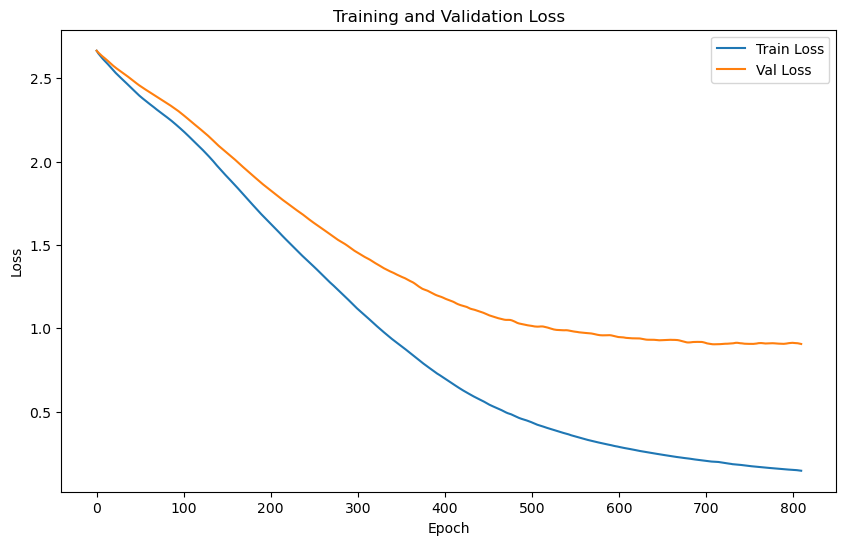

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 0.7111 | Test Accuracy: 77.73%


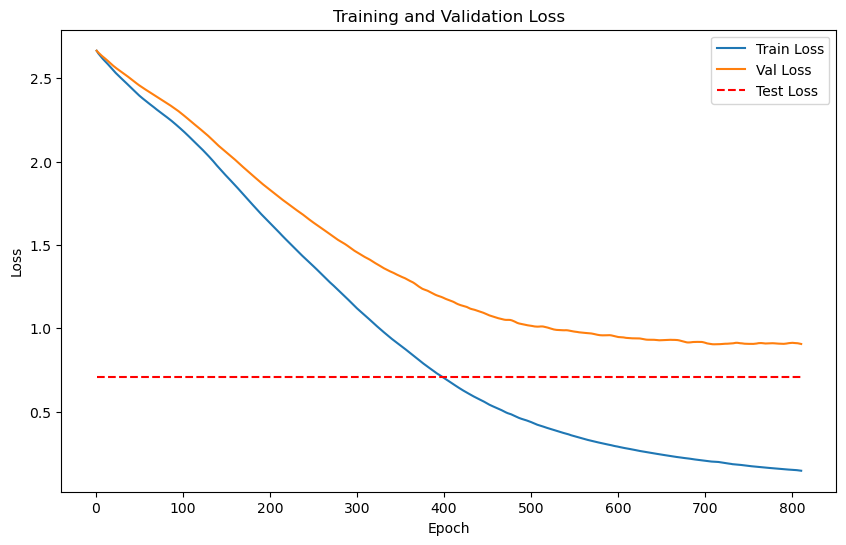

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


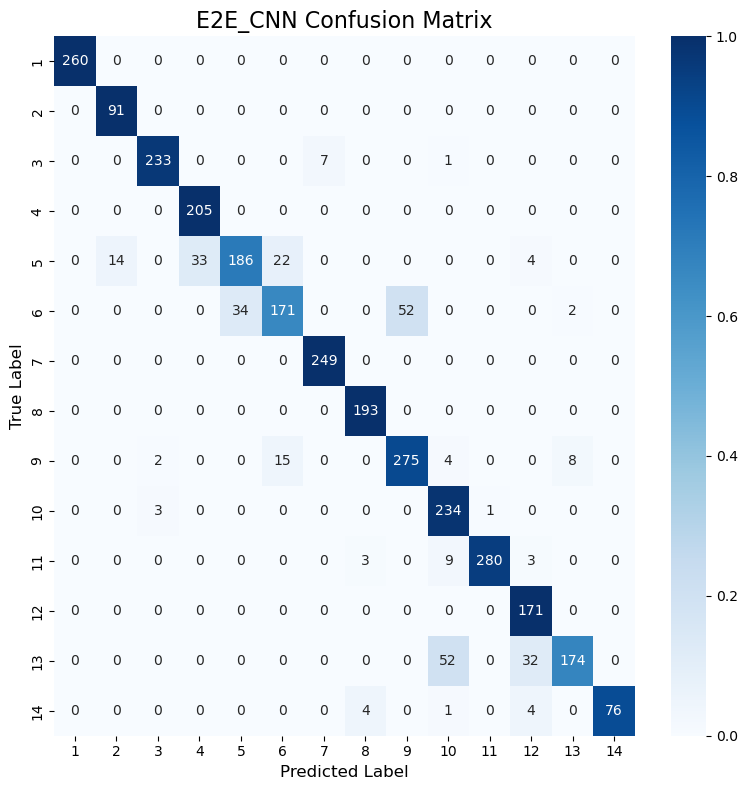

Classification Accuracy: 90.03%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


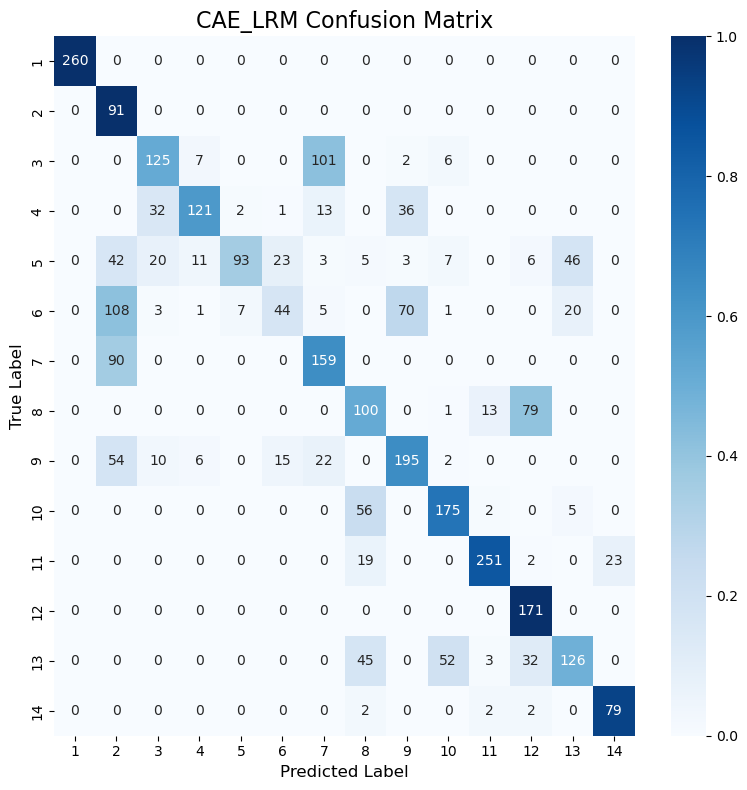

Classification Accuracy: 64.03%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


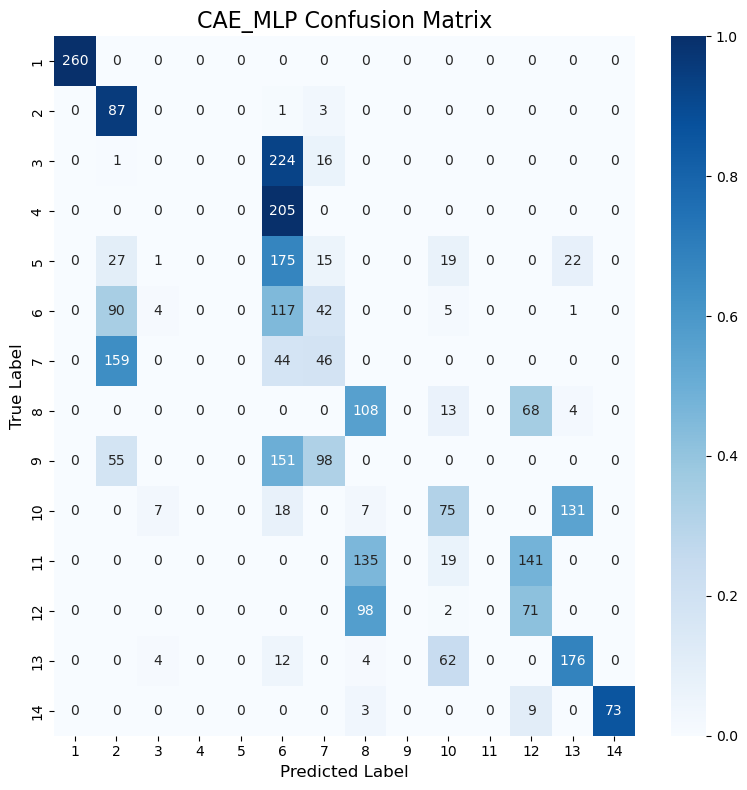

Classification Accuracy: 32.59%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


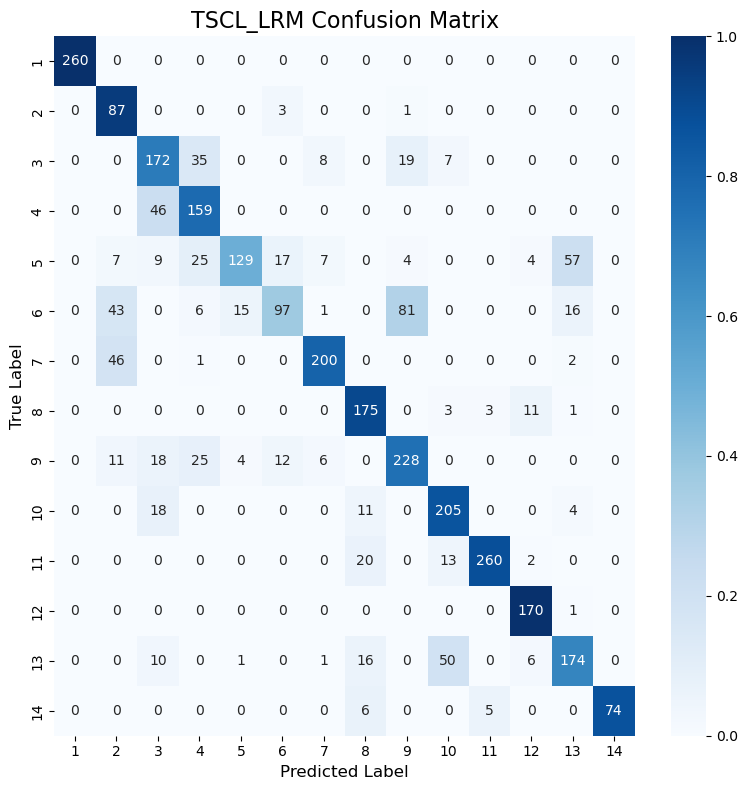

Classification Accuracy: 76.90%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


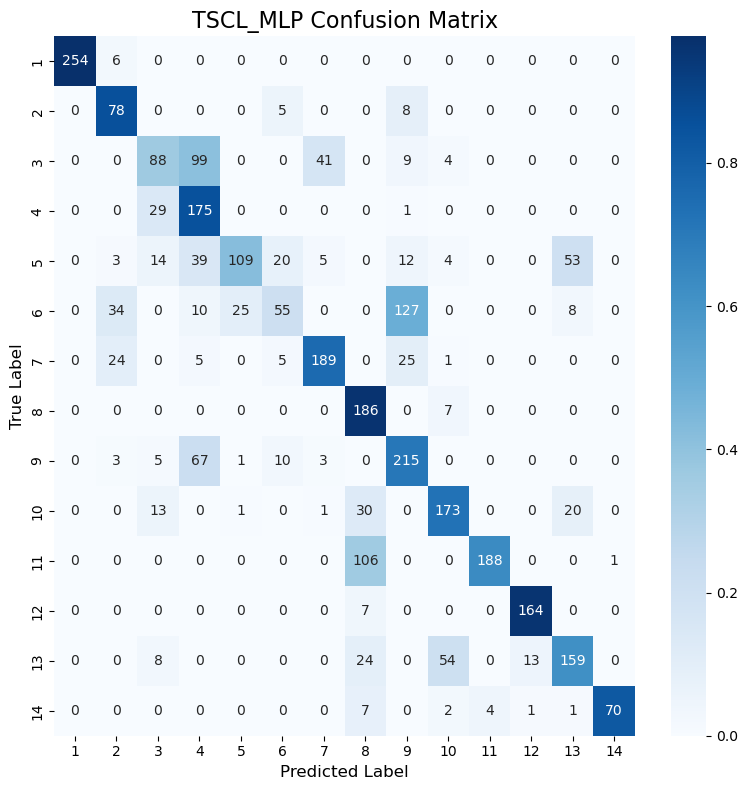

Classification Accuracy: 67.66%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


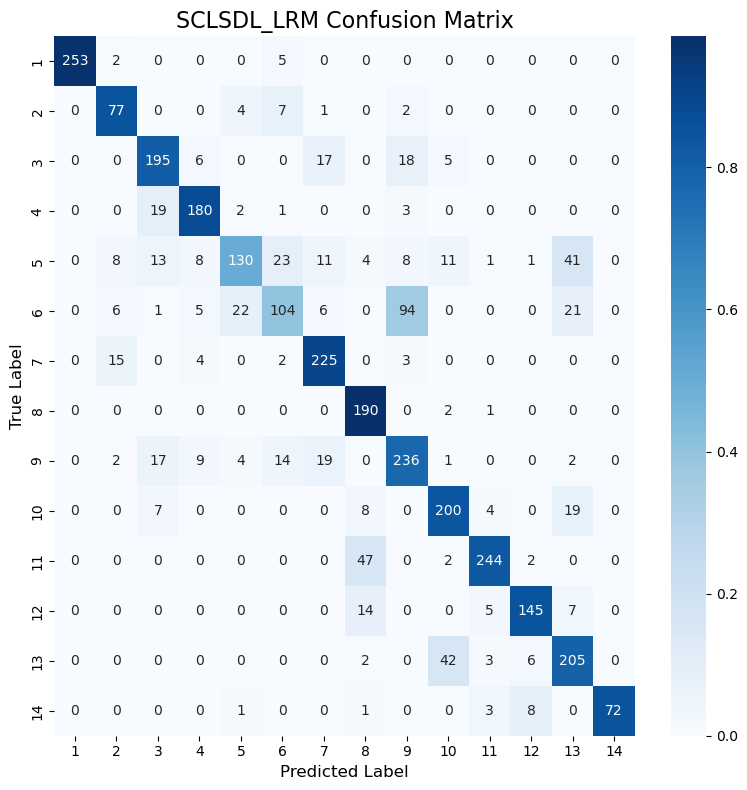

Classification Accuracy: 79.02%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


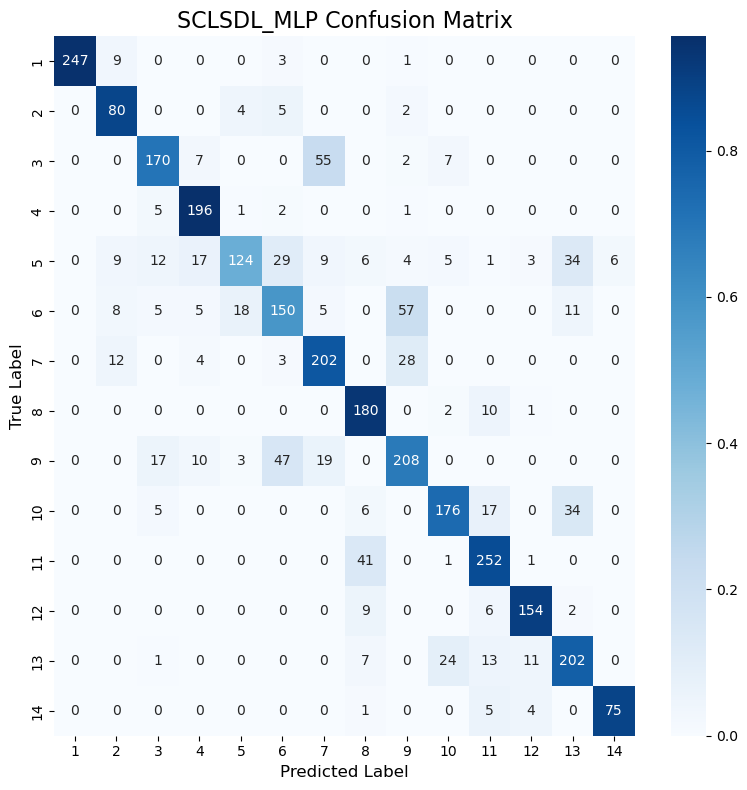

Classification Accuracy: 77.73%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          90.03
1    LRM (CAE)          64.03
2    MLP (CAE)          32.59
3     TSCL LRM          76.90
4     TSCL MLP          67.66
5  SCL_SDL LRM          79.02
6  SCL_SDL MLP          77.73

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          90.03
5  SCL_SDL LRM          79.02
6  SCL_SDL MLP          77.73
3     TSCL LRM          76.90
4     TSCL MLP          67.66
1    LRM (CAE)          64.03
2    MLP (CAE)          32.59
